In [9]:
import numpy as np
import asyncio
import pandas as pd
import sqlite3
import json
from datetime import datetime, timedelta, date
from collections import namedtuple, defaultdict
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from typing import List, Tuple, Dict
from sklearn.compose import ColumnTransformer
import warnings
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBRegressor
from copy import deepcopy
import os
import sys
import copy
import yfinance_ez as yf

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from finance_ml.variants.linear_model.main import main
from finance_ml.variants.linear_model.hyperparams import Hyperparams
from finance_ml.variants.linear_model.preprocessing import (apply_engineered_columns,
    preprocess_data, preprocess_quarterly_data, preprocess_stockpup_data, read_stock_info)
from finance_ml.utils.constants import (
    QuarterlyColumns, StockPupColumns, STOCKPUP_TABLE_NAME, QUARTERLY_DB_FILE_PATH,
    YF_QUARTERLY_TABLE_NAME, INDEX_COLUMNS, MISSING_SECTOR, MISSING_INDUSTRY,
    STOCK_GENERAL_INFO_CSV, FORMULAE, Q_DELTA_PREFIX, YOY_DELTA_PREFIX,
    QUARTER, YEAR, VS_MKT_IDX, CATEGORICAL_COLUMNS
)

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/ezras/projects/personal/finance_ml/finance_ml/variants/linear_model/metamodel.py:59: SyntaxWarning:

assertion is always true, perhaps remove parentheses?



In [10]:
hp = Hyperparams()
await main(hp)

/Users/ezras/projects/personal/finance_ml/finance_ml/variants/linear_model/preprocessing.py:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Initial combined data size: (64205, 37)
Output of delta 1 Quarters: (64205, 75)
Output of delta 4 Quarters: (64205, 103)
Output of delta 1 Quarters: (108, 37)
Output of delta 4 Quarters: (108, 39)
Output of comparison to market index: (64205, 106)
data preprocessed: (64205, 107)
fitting df of shape: (58765, 73)
QuarterFilter removed 13877 rows
QuarterFilter output size: (44888, 73)
[1]	valid_0's l1: 0.280143	valid_0's l2: 0.548709
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.278521	valid_0's l2: 0.54103
[3]	valid_0's l1: 0.276611	valid_0's l2: 0.533711
[4]	valid_0's l1: 0.275018	valid_0's l2: 0.528199
[5]	valid_0's l1: 0.273419	valid_0's l2: 0.522448
[6]	valid_0's l1: 0.272294	valid_0's l2: 0.517057
[7]	valid_0's l1: 0.271168	valid_0's l2: 0.512271
[8]	valid_0's l1: 0.270129	valid_0's l2: 0.508337
[9]	valid_0's l1: 0.26927	valid_0's l2: 0.504104
[10]	valid_0's l1: 0.268586	valid_0's l2: 0.502219
[11]	valid_0's l1: 0.267916	valid_0's l2: 0.499949
[12]	

PicklingError: Can't pickle <class 'finance_ml.variants.linear_model.metamodel.FinanceMLMetamodel'>: it's not the same object as finance_ml.variants.linear_model.metamodel.FinanceMLMetamodel

In [71]:
feature_importances = {'IssuanceOfStock': 0, 'Volume': 0, 'ShortLongTermDebt': 0, 'Sector': 0, 'Q_Delta_IncomeBeforeTax': 0, 'Q_Delta_IncomeTaxExpense': 0, 'Q_Delta_Depreciation': 0, 'Q_Delta_IssuanceOfStock': 0, 'Q_Delta_TotalAssets': 0, 'Q_Delta_Volume': 0, 'YOY_Delta_PriceEoQ': 0, 'YOY_Delta_GrossProfit': 0, 'YOY_Delta_ResearchDevelopment': 0, 'YOY_Delta_RepurchaseOfStock': 0, 'YOY_Delta_IssuanceOfStock': 0, 'YOY_Delta_Volume': 0, 'Depreciation': 1, 'Q_Delta_PriceEoQ': 1, 'Q_Delta_ResearchDevelopment': 1, 'Q_Delta_TotalOperatingExpenses': 1, 'Q_Delta_OperatingIncome': 1, 'Q_Delta_RepurchaseOfStock': 1, 'Q_Delta_TotalLiab': 1, 'YOY_Delta_DividendsPaid': 1, 'YOY_Delta_Depreciation': 1, 'GrossProfit': 2, 'RepurchaseOfStock': 2, 'Cash': 2, 'AvgPriceToEarningsRatio': 2, 'Q_Delta_GrossProfit': 2, 'Q_Delta_TotalRevenue': 2, 'Q_Delta_NetIncome': 2, 'Q_Delta_Cash': 2, 'Q_Delta_Earnings': 2, 'YOY_Delta_TotalOperatingExpenses': 2, 'YOY_Delta_IncomeTaxExpense': 2, 'YOY_Delta_ShortLongTermDebt': 2, 'ResearchDevelopment': 3, 'IncomeTaxExpense': 3, 'YOY_Delta_Cash': 3, 'YOY_Delta_Earnings': 3, 'IncomeBeforeTax': 4, 'Q_Delta_Ebit': 4, 'Q_Delta_DividendsPaid': 4, 'Q_Delta_CommonStock': 4, 'Q_Delta_LongTermDebt': 4, 'YOY_Delta_IncomeBeforeTax': 4, 'DividendsPaid': 5, 'TotalLiab': 5, 'Q_Delta_TotalStockholderEquity': 5, 'YOY_Delta_NetIncome': 5, 'TotalRevenue': 6, 'Q_Delta_ShortLongTermDebt': 6, 'YOY_Delta_PriceHigh': 6, 'YOY_Delta_LongTermDebt': 6, 'YOY_Delta_OperatingIncome': 7, 'YOY_Delta_CommonStock': 7, 'OperatingIncome': 8, 'DebtToEquityRatio': 8, 'YOY_Delta_TotalAssets': 8, 'TotalOperatingExpenses': 9, 'Earnings': 9, 'NetIncome': 10, 'AssetsToLiabilitiesRatio': 10, 'YOY_Delta_TotalStockholderEquity': 10, 'TotalAssets': 11, 'YOY_Delta_TotalRevenue': 11, 'CommonStock': 12, 'LongTermDebt': 12, 'Q_Delta_PriceAvg': 13, 'ProfitMargin': 14, 'PriceEoQ': 15, 'TotalStockholderEquity': 15, 'YOY_Delta_PriceAvg': 15, 'YOY_Delta_TotalLiab': 15, 'YOY_Delta_Ebit': 19, 'ReturnOnEquity': 20, 'Q_Delta_PriceLow': 22, 'YOY_Delta_PriceLow': 23, 'Volatility': 24, 'Q_Delta_PriceHigh': 24, 'Ebit': 25, 'Q_Delta_PriceAvg_vs_^DJI': 26, 'Quarter': 26, 'PriceAvg': 28, 'Volatility_vs_^DJI': 30, 'PriceHigh': 33, 'PriceToBookRatio': 37, 'PriceLow': 40, 'YOY_Delta_PriceAvg_vs_^DJI': 53, 'Industry': 108}
for f, i in sorted(zip(feature_importances.keys(), feature_importances.values()), key=lambda tup: tup[1]):
    print(f, i)

IssuanceOfStock 0
Volume 0
ShortLongTermDebt 0
Sector 0
Q_Delta_IncomeBeforeTax 0
Q_Delta_IncomeTaxExpense 0
Q_Delta_Depreciation 0
Q_Delta_IssuanceOfStock 0
Q_Delta_TotalAssets 0
Q_Delta_Volume 0
YOY_Delta_PriceEoQ 0
YOY_Delta_GrossProfit 0
YOY_Delta_ResearchDevelopment 0
YOY_Delta_RepurchaseOfStock 0
YOY_Delta_IssuanceOfStock 0
YOY_Delta_Volume 0
Depreciation 1
Q_Delta_PriceEoQ 1
Q_Delta_ResearchDevelopment 1
Q_Delta_TotalOperatingExpenses 1
Q_Delta_OperatingIncome 1
Q_Delta_RepurchaseOfStock 1
Q_Delta_TotalLiab 1
YOY_Delta_DividendsPaid 1
YOY_Delta_Depreciation 1
GrossProfit 2
RepurchaseOfStock 2
Cash 2
AvgPriceToEarningsRatio 2
Q_Delta_GrossProfit 2
Q_Delta_TotalRevenue 2
Q_Delta_NetIncome 2
Q_Delta_Cash 2
Q_Delta_Earnings 2
YOY_Delta_TotalOperatingExpenses 2
YOY_Delta_IncomeTaxExpense 2
YOY_Delta_ShortLongTermDebt 2
ResearchDevelopment 3
IncomeTaxExpense 3
YOY_Delta_Cash 3
YOY_Delta_Earnings 3
IncomeBeforeTax 4
Q_Delta_Ebit 4
Q_Delta_DividendsPaid 4
Q_Delta_CommonStock 4
Q_Delta_L

In [133]:
y_pred.astype('float').nlargest(10, columns=['PredictedAppreciation'])
# y_pred['PredictedAppreciation'].astype('float').sort_values(ascending=True)
# y_pred['PredictedAppreciation'].astype('float')

,,,PredictedAppreciation
TickerSymbol,Quarter,Year,
BTU,4,2020,6.351958
RIG,4,2020,4.569889
RRD,4,2020,1.581227
GCI,4,2020,1.193926
TSLA,4,2020,0.702394
AMZN,4,2020,0.699394
FMCC,4,2020,0.637104
NVDA,4,2020,0.556289
QCOM,4,2020,0.550177


In [139]:
import pickle

model_path = '/Users/ezras/projects/personal/finance_ml/finance_ml/models/linear-model-2021-03-15.pickle'
with open(model_path, 'rb') as f:
    trained_model = pickle.load(f)

In [147]:
sorted(trained_model.model.feature_importances_)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 4,
 5,
 5,
 6,
 6,
 8,
 8,
 8,
 9,
 10,
 12,
 14,
 15,
 16,
 17,
 21,
 23,
 23,
 23,
 25,
 26,
 26,
 28,
 28,
 28,
 29,
 29,
 30,
 34,
 34,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 38,
 40,
 40,
 42,
 42,
 44,
 44,
 45,
 49,
 50,
 51,
 56,
 61,
 62,
 71,
 72,
 85,
 97,
 103,
 112,
 117,
 126,
 149,
 155,
 355]

In [66]:
from finance_ml.utils.transforms import (
    NumericalScaler, CategoricalToDummy, QuarterFilter,
    OutlierExtractor, CategoricalToNumeric, Splitter)
from finance_ml.variants.linear_model.config import FEATURE_COLUMNS
from finance_ml.utils.constants import (
    TARGET_COLUMN, CATEGORICAL_COLUMNS, INDEX_COLUMNS)

start_date=datetime.now().date() - timedelta(days=90)
end_date = datetime.now().date()
date_filter = QuarterFilter(start_date=start_date, end_date=end_date)
# date_filter.fit(pred_df)

pipeline = copy.deepcopy(metamodel.data_pipeline)
pipeline.steps[0] = ('date_filter', date_filter)

df_transformed = pipeline.transform(pred_df)

pred = metamodel.model.predict(df_transformed)
predict_df = df_transformed[FEATURE_COLUMNS[0]].reset_index()
predict_df[TARGET_COLUMN] = pred
predict_df = predict_df.set_index(INDEX_COLUMNS).drop(columns=[FEATURE_COLUMNS[0]])
predict_df.nlargest(hp.N_STOCKS_TO_BUY, columns=[TARGET_COLUMN])

QuarterFilter removed 3594 rows
QuarterFilter output size: (76, 91)


,,,PredictedAppreciation
TickerSymbol,Quarter,Year,
GME,4,2020,0.791985
M,4,2020,0.288757
NKE,4,2020,0.247531
BBBY,4,2020,0.242830
LOW,4,2020,0.205946
HD,4,2020,0.200138
HIBB,4,2020,0.190788
NVDA,4,2020,0.189527
ORCL,4,2020,0.186634


In [11]:
from finance_ml.variants.linear_model.preprocessing  import preprocess_data
a = preprocess_data(hp)

/Users/ezras/projects/personal/finance_ml/finance_ml/variants/linear_model/preprocessing.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
a

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2000   59.630000      79.25     40.00       NaN   
                     2001   53.030000      68.00     38.06       NaN   
                     2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   
                     2020  162.280476     174.08    156.83    162.14   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2000                                                NaN   
                     2001                                                NaN   
                     2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
...                                                                      ...   
ZTS          4       2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   
                     2020  {"AtlanticEquities": 1, "Barclays": 1, "BofASe...   

                           Split          Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                    
A            1       2000    1.0  2.216000e+09           NaN  2.246000e+09   
                     2001    1.0  2.727000e+09           NaN  2.841000e+09   
                     2002    1.0  1.357000e+09           NaN  1.426000e+09   
                     2003    1.0  1.364000e+09           NaN  1.412000e+09   
                     2004    1.0  1.614000e+09           NaN  1.643000e+09   
...                          ...           ...           ...           ...   
ZTS          4       2016    1.0  1.218000e+09           NaN  1.277000e+09   
                     2017    1.0  1.413000e+09           NaN  1.460000e+09   
                     2018    1.0  1.474000e+09           NaN  1.564000e+09   
                     2019    NaN  5.990000e+08  1.169000e+09  1.674000e+09   
                     2020    NaN  5.300000e+08  1.221000e+09  1.807000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2000                  NaN                     NaN   
                     2001                  NaN                     NaN   
                     2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   
                     2020          133000000.0            1.277000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIn

In [22]:
idx = pd.IndexSlice
quarterly_df.loc[idx['AAPL', :, 2020]]

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
AAPL         1       2020  294.272581     326.32    223.76    247.07   
             2       2020  305.627460     365.87    239.83    352.99   
             3       2020  107.992698     133.95     90.13    112.09   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
AAPL         1       2020  {"AtlanticEquities": -1.0, "Baird": 1.0, "Bank...   
             2       2020  {"AtlanticEquities": -1.0, "Baird": 1.0, "Bank...   
             3       2020  {"ABGSundalCollier": -1.0, "Argus": 1.0, "Argu...   

                           Split          Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                    
AAPL         1       2020    NaN  1.285300e+10  2.237000e+10  5.831300e+10   
             2       2020    NaN  1.309100e+10  2.268000e+10  5.968500e+10   
             3       2020    4.0  1.477500e+10  2.468900e+10  6.469800e+10   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
AAPL         1       2020         4.565000e+09            4.546000e+10   
             2       2020         4.758000e+09            4.659400e+10   
             3       2020         4.978000e+09            4.992300e+10   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
TickerSymbol Quarter Year                                                       
AAPL         1       2020     1.313500e+10      1.886000e+09     1.285300e+10   
             2       2020     1.313700e+10      1.884000e+09     1.309100e+10   
             3       2020     1.490100e+10      2.228000e+09     1.477500e+10   

                              NetIncome  DividendsPaid  RepurchaseOfStock  \
TickerSymbol Quarter Year                                                   
AAPL         1       2020  1.124900e+10  -3.375000e+09      -1.876100e+10   
             2       2020  1.125300e+10  -3.656000e+09      -1.755900e+10   
             3       2020  1.267300e+10  -3.511000e+09      -1.758700e+10   

                           Depreciation  IssuanceOfStock  NetBorrowings  \
TickerSymbol Quarter Year                                                 
AAPL         1       2020  2.786000e+09      428000000.0            NaN   
             2       2020  2.752000e+09              NaN            NaN   
             3       2020  2.702000e+09      450000000.0   -703000000.0   

                            Investments          Cash   CommonStock  \
TickerSymbol Quarter Year                                             
AAPL         1       2020           NaN  4.017400e+10  4.803200e+10   
             2       2020           NaN  3.338300e+10  4.869600e+10   
             3       2020  7.468000e+09  3.801600e+10  5.077900e+10   

                            TotalAssets     TotalLiab  LongTermDebt  \
TickerSymbol Quarter Year                                             
AAPL         1       2020  3.204000e+11  2.419750e+11  8.908600e+10   
             2       2020  3.173440e+11  2.450620e+11  9.404800e+10   
             3       2020  3.238880e+11  2.585490e+11  9.866700e+10   

                                Revenue        Date  TotalStockholderEquity  \
TickerSymbol Quarter Year                                                     
AAPL         1       2020  5.380900e+10  2020-03-28            7.842500e+10   
             2       2020  6.404000e+10  2020-06-27            7.228200e+10   
             3       2020  9.181900e+10  2020-09-26            6.533900e+10   

                                Volume      Earnings  ShortLongTermDebt  \
TickerSymbol Quarter Year                                                 
AAPL         1       2020   51054200.0  1.004400e+10       1.039200e+10   
    

In [14]:
# idx = pd.IndexSlice
# quarterly_df.loc[idx['A', :, 2020]]
# quarterly_df.loc[('A',pd.IndexSlice(None),2020)]
# quarterly_df.loc[('A', 1, 2020)]
# model = main(hp)

,PriceAvg,PriceHigh,PriceLow,PriceEoQ,AvgRecommendations,Split,Ebit,GrossProfit,TotalRevenue,ResearchDevelopment,TotalOperatingExpenses,IncomeBeforeTax,IncomeTaxExpense,OperatingIncome,NetIncome,DividendsPaid,RepurchaseOfStock,Depreciation,IssuanceOfStock,NetBorrowings,Investments,Cash,CommonStock,TotalAssets,TotalLiab,LongTermDebt,Revenue,Date,TotalStockholderEquity,Volume,Earnings,ShortLongTermDebt,MarketCap,Volatility,Q_Delta_Volatility,YOY_Delta_Volatility
Quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,28632.395333,29551.42,27081.36,27081.36,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-26,NaN,513270000.0,NaN,NaN,NaN,0.086268,0.119077,-0.508288
2,23403.446984,27090.86,18591.93,24995.11,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-27,NaN,424380000.0,NaN,NaN,NaN,0.363149,3.209540,6.090743
3,27419.060625,29100.50,25706.09,27772.76,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-07,NaN,435030000.0,NaN,NaN,NaN,0.123797,-0.659100,0.283979
4,29210.583548,30606.48,26501.60,30391.60,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-06,NaN,350910000.0,NaN,NaN,NaN,0.140527,0.135138,0.822931


# Constants

In [60]:
DB_PATH = '/Users/ezras/projects/personal/finance_ml/data/quarterly_financial_data.db'
INFO_CSV_PATH = '/Users/ezras/projects/personal/finance_ml/data/stock_general_info.csv'
TABLE_NAME = 'yahoo_financial_data'
STOCKPUP_TABLE_NAME = 'stockpup_data'


DELTA_PREFIX = 'Delta_'
VS_MKT_IDX = '_vs_'
AVG_REC_SCORE_PREFIX = 'AvgRecScore_'

MISSING_SECTOR = 'MissingSector'
MISSING_INDUSTRY = 'MissingIndustry'

DAYS_PER_QUARTER = 90

MONTH_TO_QUARTER = {
    1: 4,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 2,
    8: 3,
    9: 3,
    10: 3,
    11: 4,
    12: 4
}
    

class StockPupColumns:
    """
    Our dataset comes from over 20 years of 10-Q and 10-K filings made by public companies
     with the U.S. Securities and Exchange Commission. We extract data from both text and
     XBRL filings, fix reporting mistakes, and normalize the data into quarterly time series
     of final restated values.
    """
    # Date Quarter Ends
    QUARTER_END = 'QuarterEnd'
    # The total number of common shares outstanding at the end of a given quarter, including all
    # classes of common stock.
    SHARES = 'Shares'
    # The number of shares the company had at the end of a given quarter, adjusted for splits to
    # be comparable to today's shares.
    SHARES_SPLIT_ADJUSTED = 'SharesSplitAdjusted'
    # If an investor started with 1 share of stock at the end of a given quarter, the split factor
    # for that quarter indicates how many shares the investor would own today as a result of
    # subsequent stock splits.
    SPLIT_FACTOR = 'SplitFactor'
    # Total assets at the end of a quarter.
    ASSETS = 'Assets'
    # Current assets at the end of a quarter.
    CURRENT_ASSETS = 'CurrentAssets'
    # Total liabilities at the end of a quarter.
    LIABILITIES = 'Liabilities'
    # Current liabilities at the end of a quarter.
    CURRENT_LIABILITIES = 'CurrentLiabilities'
    # Total shareholders' equity at the end of a quarter, including both common and preferred
    # stockholders.
    SHAREHOLDER_EQUITY = 'ShareholdersEquity'
    # Non-controlling or minority interest, if any, excluded from Shareholders equity.
    NON_CONTROLLING_INTEREST = 'NonControllingInterest'
    # Preferred equity, if any, included in Shareholders equity.
    PREFERRED_EQUITY = 'PreferredEquity'
    # Total Goodwill and all other Intangible assets, if any.
    GOODWILL_AND_INTANGIBLES = 'GoodwillIntangibles'
    # All long-term debt including capital lease obligations.
    LONG_TERM_DEBT = 'LongTermDebt'
    # Total revenue for a given quarter.
    REVENUE = 'Revenue'
    # Earnings or Net Income for a given quarter.
    EARNINGS = 'Earnings'
    # Earnings available for common stockholders - Net income minus earnings that must be
    # distributed to preferred shareholders. May be omitted when not reported by the company.
    EARNINGS_AVAILABLE_FOR_COMMON_STOCKHOLDERS = 'EarningsAvailableForCommonStockholders'
    # Basic earnings per share for a given quarter.
    EPS_BASIC = 'EPS_basic'
    # Diluted earnings per share.
    EPS_DILUTED = 'EPS_diluted'
    # Common stock dividends paid during a quarter per share, including all regular and special
    # dividends and distributions to common shareholders.
    DIVIDEND_PER_SHARE = 'DividendPerShare'
    # Cash produced by operating activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_OPERATING_ACTIVITES = 'CashFromOperatingActivities'
    # Cash produced by investing activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_INVESTING_ACTIVITIES = 'CashFromInvestingActivities'
    # Cash produced by financing activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_FINANCING_ACTIVITES = 'CashFromFinancingActivities'
    # Change in cash and cash equivalents during a given quarter, including Effect of Exchange
    # Rate Movements and Other Cash Change Adjustments, if any.
    CASH_CHANGE_DURING_PERIOD = 'CashChangeDuringPeriod'
    # Cash and cash equivalents at the end of a quarter, including Continuing and
    # Discontinued operations.
    CASH_AT_END_OF_PERIOD = 'CashAtEndOfPeriod'
    # Capital Expenditures are the cash outflows for long-term productive assets, net of cash
    # from disposals of capital assets.
    CAPITAL_EXPENDITURES = 'CapitalExpenditures'
    # The medium price per share of the company common stock during a given quarter. The prices
    # are as reported, and are not adjusted for subsequent dividends.
    PRICE = 'Price'  # Average price during quarter
    # The highest price per share of the company common stock during a given quarter.
    PRICE_HIGH = 'PriceHigh'
    # The lowest price of the company common stock during a quarter.
    PRICE_LOW = 'PriceLow'
    # Return on equity is the ratio of Earnings (available to common stockholders)
    # TTM (over the Trailing Twelve Months) to TTM average common shareholders' equity.
    ROE = 'ROE'
    # Return on assets is the ratio of total Earnings TTM to TTM average Assets.
    ROA = 'ROA'
    # Common stockholders' equity per share, also known as BVPS.
    BOOK_VALUE_OF_EQUITY_PER_SHARE = 'BookValueOfEquityPerShare'
    # The ratio of Price to Book value of equity per share as of the previous quarter.
    P_B_RATIO = 'P_B_ratio'
    # The ratio of Price to EPS diluted TTM as of the previous quarter.
    P_E_RATIO = 'P_E_ratio'
    # The aggregate amount of dividends paid per split-adjusted share of common stock from the
    # first available reporting quarter until a given quarter.
    CUM_DIVIDENDS_PER_SHARE = 'CumulativeDividendsPerShare'
    # The ratio of Dividends TTM to Earnings (available to common stockholders) TTM.
    DIVIDEND_PAYOUT_RATIO = 'DividendPayoutRatio'
    # The ratio of Long-term debt to common shareholders' equity (Shareholders equity minus
    # Preferred equity).
    LONG_TERM_DEBT_TO_EQUITY_RATIO = 'LongTermDebtToEquityRatio'
    # The ratio of common shareholders' equity (Shareholders equity minus Preferred equity) to
    # Assets.
    EQUITY_TO_ASSETS_RATIO = 'EquityToAssetsRatio'
    # The ratio of Earnings (available for common stockholders) TTM to Revenue TTM.
    NET_MARGIN = 'NetMargin'
    # The ratio of Revenue TTM to TTM average Assets.
    ASSET_TURNOVER = 'AssetTurnover'
    # Cash from operating activities minus the Capital Expenditures for a quarter.
    FREE_CASH_FLOW_PER_SHARE = 'FreeCashFlowPerShare'
    # The ratio of Current assets to Current liabilities.
    CURRENT_RATIO = 'CurrentRatio'
    
    @staticmethod
    def columns():
        return [getattr(StockPupColumns, col) for col in dir(StockPupColumns) if col[0] != '_' and col != 'columns']

class QuarterlyColumns:
    TICKER_SYMBOL = 'TickerSymbol'
    QUARTER = 'Quarter'
    YEAR = 'Year'
    PRICE_AVG = 'PriceAvg'
    PRICE_HI = 'PriceHigh'
    PRICE_LO = 'PriceLow'
    PRICE_AT_END_OF_QUARTER = 'PriceEoQ'
    AVG_RECOMMENDATIONS = 'AvgRecommendations'
    AVG_RECOMMENDATION_SCORE = 'AvgRecommendationScore'
    SPLIT = 'Split'
    EBIT = 'Ebit'
    PROFIT = 'GrossProfit'
    REVENUE = 'TotalRevenue'
    RND = 'ResearchDevelopment'
    OPERATING_EXPENSES = 'TotalOperatingExpenses'
    INCOME_PRETAX = 'IncomeBeforeTax'
    INCOME_TAX = 'IncomeTaxExpense'
    OPERATING_INCOME = 'OperatingIncome'
    NET_INCOME = 'NetIncome'
    DIVIDENDS = 'DividendsPaid'
    STOCK_REPURCHASED = 'RepurchaseOfStock'
    STOCK_ISSUED = 'IssuanceOfStock'
    DEPRECIATION = 'Depreciation'
    NET_BORROWINGS = 'NetBorrowings'
    INVESTMENTS = 'Investments'
    CASH = 'Cash'
    COMMON_STOCK = 'CommonStock'
    ASSETS = 'TotalAssets'
    LIABILITIES = 'TotalLiab'
    DEBT_LONG = 'LongTermDebt'
    DEBT_SHORT = 'ShortLongTermDebt'
    DATE = 'Date'
    VOLUME = 'Volume'
    EARNINGS = 'Earnings'
    STOCKHOLDER_EQUITY = 'TotalStockholderEquity'
    VOLATILITY = 'Volatility'
    SECTOR = 'Sector'
    INDUSTRY = 'Industry'
    MARKET_CAP = 'MarketCap'
    AGE_OF_DATA = 'AgeOfData'
    WORKING_CAPITAL_RATIO = 'AssetsToLiabilitiesRatio'
    AVG_PE_RATIO = 'AvgPriceToEarningsRatio'
    DEBT_EQUITY_RATIO = 'DebtToEquityRatio'
    ROE = 'ReturnOnEquity'
    PRICE_BOOK_RATIO = 'PriceToBookRatio'
    FCF = 'FreeCashFlow'
    PROFIT_MARGIN = 'ProfitMargin'
    
    @staticmethod
    def columns():
        return [getattr(QuarterlyColumns, col) for col in dir(QuarterlyColumns) if col[0] != '_' and col != 'columns']

INDEX_COLUMNS = [QuarterlyColumns.TICKER_SYMBOL, 
                 QuarterlyColumns.QUARTER, 
                 QuarterlyColumns.YEAR]
    
TICKER_SYMBOL, QUARTER, YEAR = 0, 1, 2

PRICE_ONLY_DELTA_COLUMNS = [
    QuarterlyColumns.PRICE_AVG,
    QuarterlyColumns.VOLATILITY
]

DELTA_COLUMNS = [
    QuarterlyColumns.PRICE_AVG,
    QuarterlyColumns.CASH,
    QuarterlyColumns.EARNINGS,
    QuarterlyColumns.AVG_PE_RATIO,
    QuarterlyColumns.DEBT_EQUITY_RATIO,
    QuarterlyColumns.ROE,
    QuarterlyColumns.WORKING_CAPITAL_RATIO,
    QuarterlyColumns.PRICE_BOOK_RATIO,
    QuarterlyColumns.PROFIT_MARGIN,
    QuarterlyColumns.OPERATING_INCOME
]

CATEGORICAL_COLUMNS = [
    QuarterlyColumns.QUARTER,
    QuarterlyColumns.SECTOR,
    QuarterlyColumns.INDUSTRY
]

VS_MARKET_INDICES_COLUMNS = [
    f'{Q_DELTA_PREFIX}_{QuarterlyColumns.PRICE_AVG}',
    QuarterlyColumns.VOLATILITY,
]

MARKET_INDICES = ['^DJI']  #, 'VTSAX', '^IXIC', '^GSPC', '^RUT', '^NYA']


FORMULAE = {
    QuarterlyColumns.VOLATILITY: lambda row: (
        row[QuarterlyColumns.PRICE_HI] - row[QuarterlyColumns.PRICE_LO]) / row[QuarterlyColumns.PRICE_AVG],

    QuarterlyColumns.WORKING_CAPITAL_RATIO: lambda row: (
        row[QuarterlyColumns.ASSETS] / row[QuarterlyColumns.LIABILITIES]),

    QuarterlyColumns.AGE_OF_DATA: lambda row: (
        datetime.now().date() - datetime.strptime(row[QuarterlyColumns.DATE], '%Y-%m-%d').date()).days/90,

    QuarterlyColumns.AVG_PE_RATIO: lambda row: (
        row[QuarterlyColumns.PRICE_AVG] / row[QuarterlyColumns.EARNINGS]),

    QuarterlyColumns.DEBT_EQUITY_RATIO: lambda row: (
        row[QuarterlyColumns.DEBT_LONG] + row[QuarterlyColumns.DEBT_SHORT]) / row[QuarterlyColumns.STOCKHOLDER_EQUITY],

    QuarterlyColumns.ROE: lambda row: (
        row[QuarterlyColumns.EARNINGS] - row[QuarterlyColumns.DIVIDENDS]) / row[QuarterlyColumns.STOCKHOLDER_EQUITY],

    QuarterlyColumns.PRICE_BOOK_RATIO: lambda row: (
        row[QuarterlyColumns.ASSETS] - row[QuarterlyColumns.LIABILITIES]) / row[QuarterlyColumns.MARKET_CAP],

    QuarterlyColumns.PROFIT_MARGIN: lambda row: (
        row[QuarterlyColumns.NET_INCOME] / row[QuarterlyColumns.REVENUE])
}

TARGET_COL_BASIS = f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}'
TARGET_COLUMN = f'NextQuarter_{TARGET_COL_BASIS}'

FEATURE_COLUMNS = [
    QuarterlyColumns.AGE_OF_DATA,
    QuarterlyColumns.VOLATILITY,
    QuarterlyColumns.AVG_RECOMMENDATION_SCORE,
    QuarterlyColumns.AVG_PE_RATIO,
    QuarterlyColumns.DEBT_EQUITY_RATIO,
    QuarterlyColumns.ROE,
    QuarterlyColumns.WORKING_CAPITAL_RATIO,
    QuarterlyColumns.PRICE_BOOK_RATIO,
    QuarterlyColumns.PROFIT_MARGIN
] + [
    f'{DELTA_PREFIX}{col}' for col in DELTA_COLUMNS
] + [
    f'{col}{VS_MKT_IDX}{mkt_idx}' for mkt_idx in MARKET_INDICES for col in VS_MARKET_INDICES_COLUMNS
]

In [3]:
class QuarterlyIndex:
    def __init__(self, ticker, quarter, year):
        assert isinstance(ticker, str)
        assert isinstance(quarter, int)
        assert isinstance(year, int)
        
        self.ticker = ticker
        self.quarter = quarter
        self.year = year
    
    def __repr__(self):
        return f"QuarterlyIndex {self.ticker} Q{self.quarter} {self.year}"
    
    def __lt__(self, qi):
        return self.quarter < qi.quarter if self.year == qi.year else self.year < qi.year 
    
    def __gt__(self, qi):
        return self.quarter > qi.quarter if self.year == qi.year else self.year > qi.year 
    
    def __le__(self, qi):
        return self.quarter <= qi.quarter if self.year == qi.year else self.year <= qi.year 
    
    def __ge__(self, qi):
        return self.quarter >= qi.quarter if self.year == qi.year else self.year >= qi.year 
    
    def __eq__(self, qi):
        return qi.ticker == self.ticker and qi.quarter == self.quarter and qi.year == self.year
    
    def __ne__(self, qi):
        return qi.ticker != self.ticker or qi.quarter != self.quarter or qi.year != self.year
    
    def __hash__(self):
        return self.to_tuple().__hash__()
    
    def time_travel(self, n: int):
        time_quarters = abs(n)
        
        num_years, num_quarters = divmod(time_quarters, 4)
        
        if n >= 0:
            new_quarter = self.quarter + num_quarters
            extra_year = 0
            if new_quarter > 4:
                extra_year, new_quarter = divmod(new_quarter, 4)
            new_year = self.year + num_years + extra_year
        else:
            new_quarter = self.quarter - num_quarters
            extra_year = 0
            if new_quarter < 1:
                new_quarter = 4 + new_quarter
                extra_year = 1
            new_year = self.year - num_years - extra_year
        
        return QuarterlyIndex(self.ticker, new_quarter, new_year)
    
    @classmethod
    def from_date(cls, dt: date):
        # shift date into the next month if it's at the end of a month
        new_date = dt + timedelta(days=15) if dt.day > 20 else dt

        q = MONTH_TO_QUARTER[new_date.month]

        year = new_date.year - 1 if new_date.month == 1 else new_date.year
        return cls('', q, year)
    
    def to_tuple(self):
        return (self.ticker, self.quarter, self.year)
    
    def to_date(self, day=1):
        return datetime(self.year, self.quarter*3, day).date()
        

In [4]:
now = datetime.now().date()
QuarterlyIndex.from_date(now).to_date()

datetime.date(2021, 12, 1)

# Build Dataframe

In [41]:
db_conn = sqlite3.connect(DB_PATH)

quarterly_df = pd.read_sql_query(f'SELECT * FROM {TABLE_NAME}', db_conn)
db_conn.close()

# This needs to be above the filters below otherwise we'll drop quarterly data! (indices have no revenue)
market_index_df = quarterly_df[quarterly_df[QuarterlyColumns.TICKER_SYMBOL].isin(MARKET_INDICES)]

market_index_df.dropna(subset=[QuarterlyColumns.DATE,
                               QuarterlyColumns.PRICE_AVG,
                               QuarterlyColumns.PRICE_HI,
                               QuarterlyColumns.PRICE_LO,
                               ],
                       inplace=True)

quarterly_df.dropna(subset=[QuarterlyColumns.DATE,
                            QuarterlyColumns.REVENUE,
                            QuarterlyColumns.PRICE_AVG,
                            QuarterlyColumns.PRICE_HI,
                            QuarterlyColumns.PRICE_LO,
                            QuarterlyColumns.EARNINGS,
                            QuarterlyColumns.MARKET_CAP],
                    inplace=True)
quarterly_df = quarterly_df[((quarterly_df[QuarterlyColumns.REVENUE] != 0) &
                             (quarterly_df[QuarterlyColumns.EARNINGS] != 0) &
                             (quarterly_df[QuarterlyColumns.MARKET_CAP] != 0) &
                             (~quarterly_df[QuarterlyColumns.TICKER_SYMBOL].isin(MARKET_INDICES)))]

quarterly_df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                        QuarterlyColumns.QUARTER,
                        QuarterlyColumns.YEAR],
                       inplace=True)
quarterly_df.sort_index(inplace=True)
quarterly_df

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2020   76.671587      87.02     63.21     75.45   
                     2021  116.685738     127.63    104.64    119.68   
             2       2019   71.038571      78.64     66.29     69.67   
                     2020   76.511270      86.84     63.08     75.29   
                     2021  125.960952     136.99    114.52    133.30   
...                               ...        ...       ...       ...   
ZTS          2       2021  172.941587     187.75    155.47    187.75   
             3       2019  120.088413     127.87    112.08    123.36   
                     2020  152.600952     164.41    136.15    161.58   
             4       2019  123.596032     132.84    115.89    132.84   
                     2020  161.848095     173.60    156.40    162.42   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2020  {"BankofAmerica": 0.5, "Barclays": 0.25, "Citi...   
                     2021  {"Baird": 1.0, "Citigroup": 0.5, "Cowen&Co.": ...   
             2       2019  {"BankofAmerica": 0.5, "Barclays": 0.25, "Citi...   
                     2020  {"BankofAmerica": 0.5, "Barclays": 0.25, "Citi...   
                     2021  {"Baird": 1.0, "Citigroup": 0.5, "Cowen&Co.": ...   
...                                                                      ...   
ZTS          2       2021  {"ArgusResearch": 1.0, "AtlanticEquities": 1.0...   
             3       2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   
                     2020  {"ArgusResearch": 1.0, "AtlanticEquities": 1.0...   
             4       2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   
                     2020  {"ArgusResearch": 1.0, "AtlanticEquities": 1.0...   

                           Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                   
A            1       2020    NaN  227000000.0  6.570000e+08  1.238000e+09   
                     2021    NaN  337000000.0  8.380000e+08  1.548000e+09   
             2       2019    NaN  250000000.0  6.920000e+08  1.274000e+09   
                     2020    NaN  227000000.0  6.570000e+08  1.238000e+09   
                     2021    NaN  288000000.0  8.170000e+08  1.525000e+09   
...                          ...          ...           ...           ...   
ZTS          2       2021    NaN  726000000.0  1.382000e+09  1.948000e+09   
             3       2019    NaN  567000000.0  1.108000e+09  1.584000e+09   
                     2020    NaN  670000000.0  1.241000e+09  1.786000e+09   
             4       2019    NaN  599000000.0  1.169000e+09  1.674000e+09   
                     2020    NaN  530000000.0  1.221000e+09  1.807000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2020          100000000.0            1.011000e+09   
                     2021          103000000.0            1.211000e+09   
             2       2019          101000000.0            1.024000e+09   
                     2020          100000000.0            1.011000e+09   
                     2021          109000000.0            1.237000e+09   
...                                        ...                     ...   
ZTS          2       2021          120000000.0            1.222000e+09   
             3       2019          112000000.0            1.017000e+09   
                     2020          112000000.0            1.116000e+09   
             4       2019          132000000.0            1.075000e+09   
                     2020          133000000.0            1.277000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
Ticke

In [42]:
db_conn = sqlite3.connect(DB_PATH)

stockpup_df = pd.read_sql_query(f'SELECT * FROM {STOCKPUP_TABLE_NAME}', db_conn)
db_conn.close()


def process_stockpup_df(stockpup_df):
    df = stockpup_df.copy()
    df.dropna(subset=[StockPupColumns.SHARES, 
                      StockPupColumns.SHARES_SPLIT_ADJUSTED,
                      StockPupColumns.FREE_CASH_FLOW_PER_SHARE,
                      StockPupColumns.EARNINGS,
                      StockPupColumns.SHAREHOLDER_EQUITY,
                      StockPupColumns.LIABILITIES,
                      StockPupColumns.PRICE],
              inplace=True)
    df = df[((df[StockPupColumns.REVENUE] != 0) &
             (df[StockPupColumns.EARNINGS] != 0))]
    
    df[StockPupColumns.QUARTER_END] = pd.to_datetime(df[StockPupColumns.QUARTER_END])

    df[QuarterlyColumns.QUARTER] = df[StockPupColumns.QUARTER_END].apply(
        lambda r: QuarterlyIndex.from_date(r).quarter)
    df[QuarterlyColumns.YEAR] = df[StockPupColumns.QUARTER_END].apply(lambda r: QuarterlyIndex.from_date(r).year)
    df[QuarterlyColumns.DIVIDENDS] = df[StockPupColumns.DIVIDEND_PER_SHARE] * df[
        StockPupColumns.SHARES]
    df[QuarterlyColumns.DATE] = df[StockPupColumns.QUARTER_END].apply(lambda r: str(r.date()))
    df[QuarterlyColumns.OPERATING_INCOME] = df[StockPupColumns.FREE_CASH_FLOW_PER_SHARE] * df[
        StockPupColumns.SHARES]
    df[QuarterlyColumns.MARKET_CAP] = df[StockPupColumns.SHARES_SPLIT_ADJUSTED] * df[StockPupColumns.PRICE]
    df[QuarterlyColumns.DEBT_SHORT] = 0  # I think short long term debt is figured into long term debt
#     df[QuarterlyColumns.EBIT] = ???  # TODO: Compute EBIT?

    df.rename(columns={
        StockPupColumns.ASSETS: QuarterlyColumns.ASSETS,
        StockPupColumns.REVENUE: QuarterlyColumns.REVENUE,
        StockPupColumns.LIABILITIES: QuarterlyColumns.LIABILITIES,
        StockPupColumns.LONG_TERM_DEBT: QuarterlyColumns.DEBT_LONG,
        StockPupColumns.SHAREHOLDER_EQUITY: QuarterlyColumns.STOCKHOLDER_EQUITY,
        StockPupColumns.CASH_AT_END_OF_PERIOD: QuarterlyColumns.CASH,
        StockPupColumns.PRICE: QuarterlyColumns.PRICE_AVG,
        StockPupColumns.PRICE_LOW: QuarterlyColumns.PRICE_LO,
        StockPupColumns.PRICE_HIGH: QuarterlyColumns.PRICE_HI,
        StockPupColumns.SPLIT_FACTOR: QuarterlyColumns.SPLIT,
        StockPupColumns.SHARES_SPLIT_ADJUSTED: QuarterlyColumns.COMMON_STOCK,
        StockPupColumns.EARNINGS: QuarterlyColumns.EARNINGS  # These aren't exactly the same
    }, inplace=True)
    
    df[QuarterlyColumns.PRICE_AVG] = df[QuarterlyColumns.PRICE_AVG] * df[QuarterlyColumns.SPLIT]
    df[QuarterlyColumns.PRICE_LO] = df[QuarterlyColumns.PRICE_LO] * df[QuarterlyColumns.SPLIT]
    df[QuarterlyColumns.PRICE_HI] = df[QuarterlyColumns.PRICE_HI] * df[QuarterlyColumns.SPLIT]

    df[QuarterlyColumns.DEBT_LONG] = df[QuarterlyColumns.DEBT_LONG].apply(lambda row: int(row))
    df[QuarterlyColumns.NET_INCOME] = df[QuarterlyColumns.EARNINGS]  # These aren't exactly the same...

    # Filter only to columns in QuarterlyColumns
    df = df[[col for col in df.columns if col in QuarterlyColumns.columns()]]
    
    df.set_index(INDEX_COLUMNS, inplace=True)
    df.sort_index(inplace=True)
    
    # Filter out all data in stockpup_df that exists in quarterly_df (by index)
    df = df[~df.index.isin(quarterly_df.index)]
    
    # Drop duplicates (occurs if quarter end dates are close to eachother)
    df = df.loc[~df.index.duplicated(keep='last')]
    
    return df

stockpup_df = process_stockpup_df(stockpup_df)

quarterly_df = pd.concat([quarterly_df, stockpup_df])
quarterly_df.sort_index(inplace=True)
quarterly_df

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2000   59.630000      79.25     40.00       NaN   
                     2001   53.030000      68.00     38.06       NaN   
                     2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   
                     2020  161.848095     173.60    156.40    162.42   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2000                                                NaN   
                     2001                                                NaN   
                     2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
...                                                                      ...   
ZTS          4       2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   
                     2020  {"ArgusResearch": 1.0, "AtlanticEquities": 1.0...   

                           Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                   
A            1       2000    1.0          NaN           NaN  2.246000e+09   
                     2001    1.0          NaN           NaN  2.841000e+09   
                     2002    1.0          NaN           NaN  1.426000e+09   
                     2003    1.0          NaN           NaN  1.412000e+09   
                     2004    1.0          NaN           NaN  1.643000e+09   
...                          ...          ...           ...           ...   
ZTS          4       2016    1.0          NaN           NaN  1.277000e+09   
                     2017    1.0          NaN           NaN  1.460000e+09   
                     2018    1.0          NaN           NaN  1.564000e+09   
                     2019    NaN  599000000.0  1.169000e+09  1.674000e+09   
                     2020    NaN  530000000.0  1.221000e+09  1.807000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2000                  NaN                     NaN   
                     2001                  NaN                     NaN   
                     2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   
                     2020          133000000.0            1.277000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
Ticke

In [43]:
stock_info_df = pd.read_csv(INFO_CSV_PATH)[['tickerSymbol', 'sector', 'industry']]
stock_info_df.rename(columns={
    'tickerSymbol': QuarterlyColumns.TICKER_SYMBOL,
    'sector': QuarterlyColumns.SECTOR,
    'industry': QuarterlyColumns.INDUSTRY
}, inplace=True)
stock_info_df.set_index([QuarterlyColumns.TICKER_SYMBOL], inplace=True)

quarterly_df = quarterly_df.join(stock_info_df, on=[QuarterlyColumns.TICKER_SYMBOL])

quarterly_df[QuarterlyColumns.SECTOR].fillna(MISSING_SECTOR, inplace=True)
quarterly_df[QuarterlyColumns.INDUSTRY].fillna(MISSING_INDUSTRY, inplace=True)
quarterly_df[QuarterlyColumns.DEBT_SHORT].fillna(0, inplace=True)

In [44]:
for col_name, fn in FORMULAE.items():
        quarterly_df[col_name] = quarterly_df.apply(fn, axis=1)

market_index_df[QuarterlyColumns.VOLATILITY] = market_index_df.apply(FORMULAE[QuarterlyColumns.VOLATILITY], axis=1)
market_index_df.set_index(INDEX_COLUMNS, inplace=True)
market_index_df.sort_index(inplace=True)

market_index_df

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                                
^DJI         1       1995   3950.831746    4157.34   3832.08   4151.81   
                     1996   5407.173492    5683.60   5032.94   5670.60   
                     1997   6821.115323    7085.16   6442.49   6876.17   
                     1998   8209.546557    8906.43   7580.40   8904.44   
                     1999   9433.327213    9997.62   9120.67   9671.83   
...                                 ...        ...       ...       ...   
             4       2016  18371.620635   19152.14  17888.28  19121.60   
                     2017  22866.817778   23836.71  21753.31  23836.71   
                     2018  25709.528730   26828.39  24285.95  24748.73   
                     2019  27054.340156   28121.68  26036.10  28121.68   
                     2020  29210.583548   30606.48  26501.60  30391.60   

                          AvgRecommendations  Split  Ebit  GrossProfit  \
TickerSymbol Quarter Year                                                
^DJI         1       1995               None    NaN   NaN          NaN   
                     1996               None    NaN   NaN          NaN   
                     1997               None    NaN   NaN          NaN   
                     1998               None    NaN   NaN          NaN   
                     1999               None    NaN   NaN          NaN   
...                                      ...    ...   ...          ...   
             4       2016               None    NaN   NaN          NaN   
                     2017               None    NaN   NaN          NaN   
                     2018               None    NaN   NaN          NaN   
                     2019               None    NaN   NaN          NaN   
                     2020               None    NaN   NaN          NaN   

                           TotalRevenue  ResearchDevelopment  \
TickerSymbol Quarter Year                                      
^DJI         1       1995           NaN                  NaN   
                     1996           NaN                  NaN   
                     1997           NaN                  NaN   
                     1998           NaN                  NaN   
                     1999           NaN                  NaN   
...                                 ...                  ...   
             4       2016           NaN                  NaN   
                     2017           NaN                  NaN   
                     2018           NaN                  NaN   
                     2019           NaN                  NaN   
                     2020           NaN                  NaN   

                           TotalOperatingExpenses  IncomeBeforeTax  \
TickerSymbol Quarter Year                                            
^DJI         1       1995                     NaN              NaN   
                     1996                     NaN              NaN   
                     1997                     NaN              NaN   
                     1998                     NaN              NaN   
                     1999                     NaN              NaN   
...                                           ...              ...   
             4       2016                     NaN              NaN   
                     2017                     NaN              NaN   
                     2018                     NaN              NaN   
                     2019                     NaN              NaN   
                     2020                     NaN              NaN   

                           IncomeTaxExpense  OperatingIncome  NetIncome  \
TickerSymbol Quarter Year                                                 
^DJI         1       1995               NaN              NaN        NaN   
                     1996               NaN              NaN        NaN   
                     1997               NaN              NaN 

In [53]:
def add_delta_columns(df: pd.DataFrame, columns: list, num_quarters: int, drop_na=True):
    tickers = set(df.index.levels[0])
    idx = pd.IndexSlice
    
    prefix = YOY_DELTA_PREFIX if num_quarters == 4 else Q_DELTA_PREFIX
    column_rename_dict = {col: f"{prefix}_{col}" for col in columns}
    
    delta_df = pd.DataFrame()
    for ticker in tickers:
        ticker_df = df[df.index.isin([ticker], level=0)][columns]
        ticker_df = ticker_df.sort_index(level=2, ascending=True)  # by year
        pct_change = ticker_df.pct_change(periods=num_quarters).rename(columns=column_rename_dict)
        delta_df = delta_df.append(pct_change)
        
    output = df.join(delta_df)
    if drop_na:
        output = output.dropna(subset=set(column_rename_dict.values()))
    
    return output

quarterly_df_new = add_delta_columns(quarterly_df, DELTA_COLUMNS, 1)

quarterly_df_new

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
                     2005   23.660000      25.90     21.43       NaN   
                     2006   34.000000      36.10     31.90       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   
                     2020  161.848095     173.60    156.40    162.42   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
                     2005                                                NaN   
                     2006                                                NaN   
...                                                                      ...   
ZTS          4       2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   
                     2020  {"ArgusResearch": 1.0, "AtlanticEquities": 1.0...   

                           Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                   
A            1       2002    1.0          NaN           NaN  1.426000e+09   
                     2003    1.0          NaN           NaN  1.412000e+09   
                     2004    1.0          NaN           NaN  1.643000e+09   
                     2005    1.0          NaN           NaN  1.658000e+09   
                     2006    1.0          NaN           NaN  1.336000e+09   
...                          ...          ...           ...           ...   
ZTS          4       2016    1.0          NaN           NaN  1.277000e+09   
                     2017    1.0          NaN           NaN  1.460000e+09   
                     2018    1.0          NaN           NaN  1.564000e+09   
                     2019    NaN  599000000.0  1.169000e+09  1.674000e+09   
                     2020    NaN  530000000.0  1.221000e+09  1.807000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
                     2005                  NaN                     NaN   
                     2006                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   
                     2020          133000000.0            1.277000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
Ticke

In [54]:
market_index_df_new = add_delta_columns(market_index_df, PRICE_ONLY_DELTA_COLUMNS, 1)

market_index_df_new

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                                
^DJI         1       1996   5407.173492    5683.60   5032.94   5670.60   
                     1997   6821.115323    7085.16   6442.49   6876.17   
                     1998   8209.546557    8906.43   7580.40   8904.44   
                     1999   9433.327213    9997.62   9120.67   9671.83   
                     2000  10798.572419   11722.98   9796.03  10907.34   
...                                 ...        ...       ...       ...   
             4       2016  18371.620635   19152.14  17888.28  19121.60   
                     2017  22866.817778   23836.71  21753.31  23836.71   
                     2018  25709.528730   26828.39  24285.95  24748.73   
                     2019  27054.340156   28121.68  26036.10  28121.68   
                     2020  29210.583548   30606.48  26501.60  30391.60   

                          AvgRecommendations  Split  Ebit  GrossProfit  \
TickerSymbol Quarter Year                                                
^DJI         1       1996               None    NaN   NaN          NaN   
                     1997               None    NaN   NaN          NaN   
                     1998               None    NaN   NaN          NaN   
                     1999               None    NaN   NaN          NaN   
                     2000               None    NaN   NaN          NaN   
...                                      ...    ...   ...          ...   
             4       2016               None    NaN   NaN          NaN   
                     2017               None    NaN   NaN          NaN   
                     2018               None    NaN   NaN          NaN   
                     2019               None    NaN   NaN          NaN   
                     2020               None    NaN   NaN          NaN   

                           TotalRevenue  ResearchDevelopment  \
TickerSymbol Quarter Year                                      
^DJI         1       1996           NaN                  NaN   
                     1997           NaN                  NaN   
                     1998           NaN                  NaN   
                     1999           NaN                  NaN   
                     2000           NaN                  NaN   
...                                 ...                  ...   
             4       2016           NaN                  NaN   
                     2017           NaN                  NaN   
                     2018           NaN                  NaN   
                     2019           NaN                  NaN   
                     2020           NaN                  NaN   

                           TotalOperatingExpenses  IncomeBeforeTax  \
TickerSymbol Quarter Year                                            
^DJI         1       1996                     NaN              NaN   
                     1997                     NaN              NaN   
                     1998                     NaN              NaN   
                     1999                     NaN              NaN   
                     2000                     NaN              NaN   
...                                           ...              ...   
             4       2016                     NaN              NaN   
                     2017                     NaN              NaN   
                     2018                     NaN              NaN   
                     2019                     NaN              NaN   
                     2020                     NaN              NaN   

                           IncomeTaxExpense  OperatingIncome  NetIncome  \
TickerSymbol Quarter Year                                                 
^DJI         1       1996               NaN              NaN        NaN   
                     1997               NaN              NaN        NaN   
                     1998               NaN              NaN 

In [59]:
print(market_index_df_new.columns)
print(quarterly_df_new.columns)

Index(['PriceAvg', 'PriceHigh', 'PriceLow', 'PriceEoQ', 'AvgRecommendations',
       'Split', 'Ebit', 'GrossProfit', 'TotalRevenue', 'ResearchDevelopment',
       'TotalOperatingExpenses', 'IncomeBeforeTax', 'IncomeTaxExpense',
       'OperatingIncome', 'NetIncome', 'DividendsPaid', 'RepurchaseOfStock',
       'Depreciation', 'IssuanceOfStock', 'NetBorrowings', 'Investments',
       'Cash', 'CommonStock', 'TotalAssets', 'TotalLiab', 'LongTermDebt',
       'Revenue', 'Date', 'TotalStockholderEquity', 'Volume', 'Earnings',
       'ShortLongTermDebt', 'MarketCap', 'DividendPerShare', 'Volatility',
       'Q_Delta__PriceAvg', 'Q_Delta__Volatility'],
      dtype='object')
Index(['PriceAvg', 'PriceHigh', 'PriceLow', 'PriceEoQ', 'AvgRecommendations',
       'Split', 'Ebit', 'GrossProfit', 'TotalRevenue', 'ResearchDevelopment',
       'TotalOperatingExpenses', 'IncomeBeforeTax', 'IncomeTaxExpense',
       'OperatingIncome', 'NetIncome', 'DividendsPaid', 'RepurchaseOfStock',
       'Depreciatio

In [61]:
def add_comparison_to_market_index(
        df: pd.DataFrame, market_index_df: pd.DataFrame, market_indices: list, columns: list, dropna=True):
    market_indices = MARKET_INDICES if not market_indices else market_indices
    
    idx = pd.IndexSlice
    output = df.copy()
    
    for mkt_idx in market_indices:
        mkt_idx_df = market_index_df.loc[idx[mkt_idx, :, :]]  # removes mkt_idx from multiIndex so we can use as divisor
        
        for col in columns:
            vs_mkt_idx = df[col]/mkt_idx_df[col]
            vs_mkt_idx.name = f"{col}{VS_MKT_IDX}{mkt_idx}"
            
            output = output.join(vs_mkt_idx)
    
    if dropna:
        output = output.dropna(subset=[f"{col}{VS_MKT_IDX}{mkt_idx}" for mkt_idx in market_indices for col in columns])
    
    return output

output = add_comparison_to_market_index(quarterly_df_new, market_index_df_new, MARKET_INDICES, VS_MARKET_INDICES_COLUMNS)

output

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
                     2005   23.660000      25.90     21.43       NaN   
                     2006   34.000000      36.10     31.90       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   
                     2020  161.848095     173.60    156.40    162.42   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
                     2005                                                NaN   
                     2006                                                NaN   
...                                                                      ...   
ZTS          4       2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   
                     2020  {"ArgusResearch": 1.0, "AtlanticEquities": 1.0...   

                           Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                   
A            1       2002    1.0          NaN           NaN  1.426000e+09   
                     2003    1.0          NaN           NaN  1.412000e+09   
                     2004    1.0          NaN           NaN  1.643000e+09   
                     2005    1.0          NaN           NaN  1.658000e+09   
                     2006    1.0          NaN           NaN  1.336000e+09   
...                          ...          ...           ...           ...   
ZTS          4       2016    1.0          NaN           NaN  1.277000e+09   
                     2017    1.0          NaN           NaN  1.460000e+09   
                     2018    1.0          NaN           NaN  1.564000e+09   
                     2019    NaN  599000000.0  1.169000e+09  1.674000e+09   
                     2020    NaN  530000000.0  1.221000e+09  1.807000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
                     2005                  NaN                     NaN   
                     2006                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   
                     2020          133000000.0            1.277000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
Ticke

In [12]:
def get_avg_recommendation_score(row: pd.Series):
    if row[QuarterlyColumns.AVG_RECOMMENDATIONS] is None or str(row[QuarterlyColumns.AVG_RECOMMENDATIONS]) == 'nan':
        return pd.Series([0])
    
    avg_recommendation = np.mean([float(v) for v in json.loads(row[QuarterlyColumns.AVG_RECOMMENDATIONS]).values()])
    return pd.Series([avg_recommendation])


quarterly_df[QuarterlyColumns.AVG_RECOMMENDATION_SCORE] = quarterly_df.apply(get_avg_recommendation_score, axis=1)

quarterly_df

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2001   53.030000      68.00     38.06       NaN   
                     2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
                     2005   23.660000      25.90     21.43       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2015   43.810000      48.65     38.98       NaN   
                     2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2001                                                NaN   
                     2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
                     2005                                                NaN   
...                                                                      ...   
ZTS          4       2015                                                NaN   
                     2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   

                           Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                   
A            1       2001    1.0          NaN           NaN  2.841000e+09   
                     2002    1.0          NaN           NaN  1.426000e+09   
                     2003    1.0          NaN           NaN  1.412000e+09   
                     2004    1.0          NaN           NaN  1.643000e+09   
                     2005    1.0          NaN           NaN  1.658000e+09   
...                          ...          ...           ...           ...   
ZTS          4       2015    1.0          NaN           NaN  1.274000e+09   
                     2016    1.0          NaN           NaN  1.277000e+09   
                     2017    1.0          NaN           NaN  1.460000e+09   
                     2018    1.0          NaN           NaN  1.564000e+09   
                     2019    NaN  599000000.0  1.169000e+09  1.674000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2001                  NaN                     NaN   
                     2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
                     2005                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2015                  NaN                     NaN   
                     2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
Ticke

In [13]:
# ---------- Break Recommendations up by firm ---------
#      skipping for now...
# recommendations = [json.loads(contents) if contents else {} 
#                    for contents in quarterly_df[QuarterlyColumns.AVG_RECOMMENDATIONS]]
# recommendations = [
#     {f'{AVG_REC_SCORE_PREFIX}{firm}': value if value is not None else 0 for firm, value in recommendation.items()} 
#     for recommendation in recommendations]
# recommendations_df = pd.DataFrame(recommendations).fillna(0)


# quarterly_df = pd.merge(quarterly_df, recommendations_df, left_index=True, right_index=True)

In [14]:
def get_target_col_prediction(row: pd.Series, df: pd.DataFrame):
    try:
        next_quarter_tuple = QuarterlyIndex(*row.name).time_travel(1).to_tuple()
        next_quarter_data = df.loc[next_quarter_tuple]
        return next_quarter_data[TARGET_COL_BASIS]
    except: 
        return None

# Add Y (target) to quarterly_df
quarterly_df[TARGET_COLUMN] = quarterly_df.apply(get_target_col_prediction, axis=1, df=quarterly_df)

In [15]:
# Get dataframe of rows to make predictions on (most recent rows)
prediction_candidate_df = quarterly_df[quarterly_df[TARGET_COLUMN].isnull()]

In [16]:
def split_feature_target(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Split processed data into features and target.

    :param df: processed data for model training.
    :param target_col: target column name.
    :return: X: features for model training.
             y: targets for model training.
    """
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    return X, y

In [17]:
class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns, num_std_threshold=3):
        self.columns = columns
        self.threshold = num_std_threshold
    def fit(self, X):
        return self
    def transform(self, X):
        outlier_filter = np.abs(stats.zscore(X[self.columns]))
        np.nan_to_num(outlier_filter, 0)
        X_new = X[(outlier_filter < self.threshold).all(axis=1)]
        print(f'OutlierExtractor removed {X.shape[0] - X_new.shape[0]} rows')
        print(f"OutlierExtractor output size: {X_new.shape}")
        return X_new

class ColumnFilter(BaseEstimator, TransformerMixin):
    def __init__(self, columns, dropna=True):
        self.columns = columns
        self.dropna = dropna
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = X.copy()[self.columns]
        if self.dropna:
            X_new.dropna(subset=self.columns, inplace=True)
        print(f"Column Filter output size: {X_new.shape}")
        return X_new

class CategoricalToDummy(BaseEstimator, TransformerMixin):

    def __init__(self, categorical_columns, drop_one=True, drop_original=True):
        """
        Transforms categorical columns to one-hot-encoded columns named as such:
            '<original column name>_<category name>'

        Args
            categorical_columns: List[str] of categorical columns in X
            drop_one: (bool) when converting to categorical columns, whether to drop the first category name.
                Eg. if a column has categories ['A', 'B'], drop category 'A'. (since 'B' == 1 or 0 is sufficient)
            drop_original: (bool) when transforming categorical columns in X, whether to drop the original columns
        """
        self.categorical_columns = categorical_columns
        self.drop_one = drop_one
        self.drop_original = drop_original

    def fit(self, X, y=None):
        X_temp = X.copy()
        self.dummy_values = {}
        self.base_category_by_col = {}

        for col in self.categorical_columns:
            self.dummy_values[col] = X_temp[col].unique()
            if self.drop_one:
                base_temp = [x for x in self.dummy_values[col] if str(x) != 'nan']
                self.base_category_by_col[col] = base_temp[0]

        return self

    def transform(self, X, y=None):
        X_temp = X.copy()

        for col in self.categorical_columns:
            for cat in self.dummy_values[col]:
                if str(cat) == 'nan':
                    X_temp[str(col) + '_' + str(cat)] = X_temp[col].isnull().astype(int)
                else:
                    X_temp[str(col) + '_' + str(cat)] = (X_temp[col] == cat).astype(int)
            if self.drop_one:
                X_temp.drop(labels=[str(col) + '_' + str(self.base_category_by_col[col])], axis=1, inplace=True)

        if self.drop_original:
            X_temp.drop(labels=self.categorical_columns, axis=1, inplace=True)

        print(f"Categorical Transform output size: {X_temp.shape}")

        return X_temp

class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List, **kwargs):
        self.columns = columns
        self.kwargs = kwargs
    def fit(self, X):
        self.column_transformer = ColumnTransformer(transformers=[
            ('scaler', StandardScaler(), self.columns)
        ])
        self.column_transformer.fit_transform(X[self.columns])
        return self
    def transform(self, X):
        X_temp = X.copy()
        X_temp[self.columns] = self.column_transformer.transform(X)
        print(f"Scaler output size: {X_temp.shape}")
        return X_temp

class Splitter(BaseEstimator, TransformerMixin):
    def __init__(self, test_size=0.2, target_col=TARGET_COLUMN):
        self.test_size = test_size
        self.target_col = target_col
    def fit(self, X):
        return self
    def transform(self, X):
        n_test = int(len(X) * self.test_size)
        X_test, y_test = split_feature_target(
            X.sample(n=n_test, random_state=7), self.target_col)
        
        X_train, y_train = split_feature_target(
            X.loc[~X.index.isin(X_test.index)], self.target_col)
        
        return X_train, y_train, X_test, y_test

class IndexSwitchTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, index_columns = INDEX_COLUMNS):
        self.index_columns = index_columns
        self.index_df = None

    def fit(self, X):
        if self.index_df is None:
            X_temp = X.reset_index()
            self.index_df = X_temp[self.index_columns]
        return self

    def transform(self, X):
        if all([col in self.index_columns for col in X.index.names]):
            X_new = X.reset_index()
        else:
            X_new = X.join(self.index_df, how='left')
            X_new = X_new.set_index(self.index_columns)
        return X_new

class DateFilter(BaseEstimator, TransformerMixin):
    def __init__(self, start_date: date, end_date: date, date_column: str = QuarterlyColumns.DATE):
        self.start_date = start_date
        self.end_date = end_date
        self.date_column = date_column
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = X[(pd.to_datetime(X[self.date_column]) >= self.start_date) & (pd.to_datetime(X[self.date_column]) < self.end_date)]
        print(f'DateFilter removed {X.shape[0] - X_new.shape[0]} rows')
        print(f"DateFilter output size: {X_new.shape}")
        return X_new


In [18]:
index_transformer = IndexSwitchTransformer(INDEX_COLUMNS)  
numerical_scaler = NumericalScaler(FEATURE_COLUMNS)
categorical_to_dummy = CategoricalToDummy(CATEGORICAL_COLUMNS)
date_filter = DateFilter(start_date=datetime(2000, 1, 1),
                         end_date=datetime(2020, 8, 1))

data_pipeline = Pipeline(steps=[
    ('reset_index', index_transformer),
    ('filter_dates', date_filter),
    ('filter_columns', ColumnFilter(FEATURE_COLUMNS + CATEGORICAL_COLUMNS + [TARGET_COLUMN])),
    ('extract_outliers', OutlierExtractor(FEATURE_COLUMNS)),
    ('one_hot_encode', categorical_to_dummy),
    ('numeric_scaler', numerical_scaler),
    ('restore_index', index_transformer)
])

quarterly_df
X_transformed = data_pipeline.fit_transform(quarterly_df)  # fit only on train
X_transformed
X_train, y_train, X_test, y_test = Splitter().transform(X_transformed)

DateFilter removed 8618 rows
DateFilter output size: (50025, 60)
Column Filter output size: (48974, 25)
OutlierExtractor removed 4848 rows
OutlierExtractor output size: (44126, 25)
Categorical Transform output size: (44126, 165)
Scaler output size: (44126, 165)


# Train LinearRegression

In [19]:
reg_model = LinearRegression(fit_intercept=True,
                             normalize=True).fit(X_train, y_train)

for i, col in enumerate(X_train.columns):
    print(f'The coefficient for {col} is {reg_model.coef_[i]}')
print(f'The intercept for our model is {reg_model.intercept_}')

score = reg_model.score(X_test, y_test)
print('*'*50)
print(f'The score of our model is {score}')

y_pred = reg_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

abs_err = abs(y_pred - y_test) * 100.  # absolute error percentage points (eg. 5= prediction is 5% off)
err = (y_pred - y_test) * 100.

The coefficient for AgeOfData is 0.0008473415545330043
The coefficient for Volatility is 0.004618731784095945
The coefficient for AvgRecommendationScore is -0.0020679458426194415
The coefficient for AvgPriceToEarningsRatio is 0.0008581717390704168
The coefficient for DebtToEquityRatio is -0.0017342252801362341
The coefficient for ReturnOnEquity is 2.2244863736525617e-05
The coefficient for AssetsToLiabilitiesRatio is -0.0007660084527861628
The coefficient for PriceToBookRatio is 0.012607144749108826
The coefficient for ProfitMargin is 0.00024494867295082954
The coefficient for Delta_PriceAvg is 0.021432621462958882
The coefficient for Delta_Cash is 0.0005265164219466848
The coefficient for Delta_Earnings is 0.0011225738526386443
The coefficient for Delta_AvgPriceToEarningsRatio is -0.000613933736155697
The coefficient for Delta_DebtToEquityRatio is 0.0012255729345670568
The coefficient for Delta_ReturnOnEquity is 0.001809781596038687
The coefficient for Delta_AssetsToLiabilitiesRatio i

In [20]:
booster = 'gbtree'  #'dart'  #'gblinear' #'gbtree'
xgb_model = XGBRegressor(seed=100,
                         n_estimators=100,
                         max_depth=3,
                         learning_rate=0.1,
                         min_child_weight=1,
                         subsample=1,
                         colsample_bytree=1,
                         colsample_bylevel=1,
                         gamma=0,
                         booster=booster).fit(X_train, y_train)

if booster == 'gblinear':
    for i, col in enumerate(X_train.columns):
        print(f'The coefficient for {col} is {xgb_model.coef_[i]}')
    print(f'The intercept for our model is {xgb_model.intercept_}')

xgb_score = xgb_model.score(X_test, y_test)
print('*'*50)
print(f'The score of our model is {score}')

y_pred_xgb = xgb_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))

abs_err_xgb = abs(y_pred_xgb - y_test) * 100.  # absolute error percentage points (eg. 5= prediction is 5% off)
err_xgb = (y_pred_xgb - y_test) * 100.

**************************************************
The score of our model is 0.013947109420060833
Mean Absolute Error: 0.09121079610757395
Mean Squared Error: 0.05776721662810462
Root Mean Squared Error: 0.240348115507704


# Evaluate Accuracy

Text(0.5, 0, 'DeltaPriceAvg% Error')

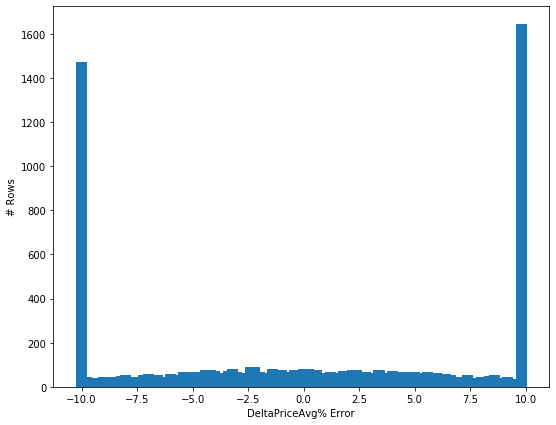

In [21]:
from collections import Counter

def get_counts_by_bin(items: pd.Series, bins: List):
    items = sorted(items)
    bins = sorted(bins)
    
    assigned = []
    current_bin = 0
    for item in items:
        while(item > bins[current_bin] and current_bin < len(bins) - 1):
            current_bin += 1
        
        assigned.append(current_bin)
    
    return {bins[key]: value for key, value in Counter(assigned).items()}
    
    

bins = [-10 +.2*i for i in range(100)]

counts_by_bin = get_counts_by_bin(err, bins)

fig, ax1 = plt.subplots(figsize=(9, 7))
fig.subplots_adjust(left=0.115, right=0.88)
ax1.bar(counts_by_bin.keys(), height=counts_by_bin.values(), width=0.5)
ax1.set_ylabel('# Rows')
ax1.set_xlabel('DeltaPriceAvg% Error')


# Evaluate Allocation

In [51]:
def equal_allocation(n_largest_df: pd.DataFrame, cash: float):
    portfolio = {}
    n = n_largest_df.shape[0]

    # iter over rows, largest is shown first
    for idx, row in n_largest_df.iterrows():
        portfolio[QuarterlyIndex(*idx)] = cash / n
    
    return portfolio

def fibonnaci_allocation(n_largest_df: pd.DataFrame, cash:float):
    portfolio = {}
    n = n_largest_df.shape[0]
    fibonacci_seq = [1,1,2,3,5,8,13,21,34,55,89,144,233,377,610,987,1597,2584,4181,6765,10946][:n]
    fib_sum = sum(fibonacci_seq)
    
    i=n-1
    for idx, row in n_largest_df.iterrows():
        portfolio[QuarterlyIndex(*idx)] = cash * fibonacci_seq[i] / fib_sum
        i -= 1
    
    return portfolio
        

def sell_portfolio(df, portfolio: Dict[QuarterlyIndex, float]):
    total_value = 0
    
    for idx, value in portfolio.items():
        next_quarter_idx = idx.time_travel(1)
        try:
            change_in_price = df.loc[next_quarter_idx.to_tuple()][f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}']
        except:
            print(f'Failed to find data for {next_quarter_idx}')
            change_in_price = 0
        total_value += value * (1 + change_in_price)
    
    return total_value if total_value > 0 else 0


def _transform_df_for_prediction(df: pd.DataFrame, existing_pipeline: Pipeline):
    index_transformer = IndexSwitchTransformer(INDEX_COLUMNS)
    index_transformer.fit(df)
        
    # don't include prediction column
    column_filter = ColumnFilter([col for col in FEATURE_COLUMNS if col in df.columns] + CATEGORICAL_COLUMNS)
    
    # No outlier extraction, no date filtering, new index transformer, new column filter
    prediction_data_pipeline = Pipeline(steps=[
        ('reset_index', index_transformer),
        ('filter_columns', column_filter),
        ('one_hot_encode', existing_pipeline.named_steps['one_hot_encode']),
        ('numeric_scaler', existing_pipeline.named_steps['numeric_scaler']),
        ('restore_index', index_transformer)
    ])
    
    output =  prediction_data_pipeline.transform(df)
    print(f"Transformed output for prediction: {output.shape}")
    
    return output


def compute_performance(df: pd.DataFrame, 
                        model,
                        pipeline: Pipeline,
                        start_date: date, 
                        n_stocks: int, 
                        allocation_fn,
                        end_date: date = None,
                        initial_value: float = 1.0):
    history = []
    portfolio = {}
    end_date = end_date if end_date is not None else (datetime.now() - timedelta(days=90)).date()
    end_q_index = QuarterlyIndex.from_date(end_date)
    
    cash = initial_value
    q_index = QuarterlyIndex.from_date(start_date)
    
    print(f"Computing performance from start: {q_index} to end: {end_q_index}")
    
    while (not(q_index.quarter == end_q_index.quarter and q_index.year == end_q_index.year)):

        if portfolio:
            print(f'Evaluating performance for Q{q_index.quarter} {q_index.year}. Current value: {cash}')
            cash = sell_portfolio(df, portfolio)

        X_q_year = df.loc(axis=0)[:, q_index.quarter, q_index.year]
        X_q_year_transformed = _transform_df_for_prediction(X_q_year, pipeline)
        
        # Grabbing the indexes here only - FEATURE_COLS[1] is arbitrary feature col
        y_pred = X_q_year_transformed[FEATURE_COLUMNS[1]].reset_index()
        
        y_pred[TARGET_COLUMN] = model.predict(X_q_year_transformed)
        y_pred = y_pred.set_index(INDEX_COLUMNS)
        
        portfolio = allocation_fn(y_pred.nlargest(n_stocks, columns=[TARGET_COLUMN]), cash)
        
        history.append(portfolio)
        q_index = q_index.time_travel(1)
        
    return sell_portfolio(df, portfolio), history


In [41]:
start_date = datetime(2010,1,1)

idx_performance = market_index_df.loc(axis=0)['^DJI',:, :]
idx_performance = idx_performance[pd.to_datetime(idx_performance[QuarterlyColumns.DATE]) >= start_date][QuarterlyColumns.PRICE_AVG]
values_dates = [(value, QuarterlyIndex(*q_index).to_date()) for value, q_index in zip(
    idx_performance, idx_performance.index)]
values_dates = sorted(values_dates, key=lambda x: x[1])
# divide by initial value so that it starts at 1.0
idx_performance = [values_dates[i][0]/values_dates[0][0] for i in range(len(values_dates))]
dates = [values_dates[i][1] for i in range(len(values_dates))]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=idx_performance, mode='lines', name='^DJI'))
fig.update_layout(title='Value Over Time',
                   xaxis_title='Time',
                   yaxis_title='Value')

for n in range(1,11,2):
    for allocation_fn in [equal_allocation, fibonnaci_allocation]:
        final_value, history = compute_performance(
            quarterly_df, reg_model, data_pipeline, start_date, n_stocks=n, allocation_fn=allocation_fn)

        algorithm_performance = [sum(hist_dict.values()) for hist_dict in history]
        fig.add_trace(go.Scatter(x=dates, y=algorithm_performance, mode='lines', name=f'{allocation_fn.__name__} n={n}'))


fig.show()

Computing performance from start: QuarterlyIndex  Q4 2009 to end: QuarterlyIndex  Q2 2020
Column Filter output size: (654, 24)
Categorical Transform output size: (654, 164)
Scaler output size: (654, 164)
Transformed output for prediction: (654, 164)
Evaluating performance for Q1 2010. Current value: 1.0
Column Filter output size: (644, 24)
Categorical Transform output size: (644, 164)
Scaler output size: (644, 164)
Transformed output for prediction: (644, 164)
Evaluating performance for Q2 2010. Current value: 0.7896160086533262
Column Filter output size: (651, 24)
Categorical Transform output size: (651, 164)
Scaler output size: (651, 164)
Transformed output for prediction: (651, 164)
Evaluating performance for Q3 2010. Current value: 1.0621957815035155
Column Filter output size: (658, 24)
Categorical Transform output size: (658, 164)
Scaler output size: (658, 164)
Transformed output for prediction: (658, 164)
Evaluating performance for Q4 2010. Current value: 0.9822918646066295
Colum

Categorical Transform output size: (576, 164)
Scaler output size: (576, 164)
Transformed output for prediction: (576, 164)
Evaluating performance for Q2 2019. Current value: 7.212881947389079
Column Filter output size: (446, 24)
Categorical Transform output size: (446, 164)
Scaler output size: (446, 164)
Transformed output for prediction: (446, 164)
Evaluating performance for Q3 2019. Current value: 4.034720466352619
Column Filter output size: (363, 24)
Categorical Transform output size: (363, 164)
Scaler output size: (363, 164)
Transformed output for prediction: (363, 164)
Evaluating performance for Q4 2019. Current value: 3.975447426493923
Column Filter output size: (333, 24)
Categorical Transform output size: (333, 164)
Scaler output size: (333, 164)
Transformed output for prediction: (333, 164)
Evaluating performance for Q1 2020. Current value: 4.2105279849874115
Column Filter output size: (319, 24)
Categorical Transform output size: (319, 164)
Scaler output size: (319, 164)
Transf

Categorical Transform output size: (609, 164)
Scaler output size: (609, 164)
Transformed output for prediction: (609, 164)
Evaluating performance for Q1 2018. Current value: 19.3559829457802
Column Filter output size: (605, 24)
Categorical Transform output size: (605, 164)
Scaler output size: (605, 164)
Transformed output for prediction: (605, 164)
Evaluating performance for Q2 2018. Current value: 12.611738016936926
Column Filter output size: (603, 24)
Categorical Transform output size: (603, 164)
Scaler output size: (603, 164)
Transformed output for prediction: (603, 164)
Evaluating performance for Q3 2018. Current value: 13.250088641597207
Column Filter output size: (600, 24)
Categorical Transform output size: (600, 164)
Scaler output size: (600, 164)
Transformed output for prediction: (600, 164)
Evaluating performance for Q4 2018. Current value: 15.277806692290183
Column Filter output size: (585, 24)
Categorical Transform output size: (585, 164)
Scaler output size: (585, 164)
Trans

Categorical Transform output size: (631, 164)
Scaler output size: (631, 164)
Transformed output for prediction: (631, 164)
Evaluating performance for Q3 2016. Current value: 12.972778165050178
Column Filter output size: (625, 24)
Categorical Transform output size: (625, 164)
Scaler output size: (625, 164)
Transformed output for prediction: (625, 164)
Evaluating performance for Q4 2016. Current value: 14.677133539816703
Failed to find data for QuarterlyIndex ACAS Q4 2016
Column Filter output size: (616, 24)
Categorical Transform output size: (616, 164)
Scaler output size: (616, 164)
Transformed output for prediction: (616, 164)
Evaluating performance for Q1 2017. Current value: 13.53654577990355
Column Filter output size: (616, 24)
Categorical Transform output size: (616, 164)
Scaler output size: (616, 164)
Transformed output for prediction: (616, 164)
Evaluating performance for Q2 2017. Current value: 10.332229449509635
Column Filter output size: (615, 24)
Categorical Transform output 

Categorical Transform output size: (663, 164)
Scaler output size: (663, 164)
Transformed output for prediction: (663, 164)
Evaluating performance for Q4 2014. Current value: 24.032456341980968
Column Filter output size: (659, 24)
Categorical Transform output size: (659, 164)
Scaler output size: (659, 164)
Transformed output for prediction: (659, 164)
Evaluating performance for Q1 2015. Current value: 17.80335105547996
Column Filter output size: (652, 24)
Categorical Transform output size: (652, 164)
Scaler output size: (652, 164)
Transformed output for prediction: (652, 164)
Evaluating performance for Q2 2015. Current value: 18.29345594212826
Column Filter output size: (651, 24)
Categorical Transform output size: (651, 164)
Scaler output size: (651, 164)
Transformed output for prediction: (651, 164)
Evaluating performance for Q3 2015. Current value: 17.76356943282573
Column Filter output size: (644, 24)
Categorical Transform output size: (644, 164)
Scaler output size: (644, 164)
Transf

Categorical Transform output size: (655, 164)
Scaler output size: (655, 164)
Transformed output for prediction: (655, 164)
Evaluating performance for Q2 2013. Current value: 3.409905208728634
Column Filter output size: (661, 24)
Categorical Transform output size: (661, 164)
Scaler output size: (661, 164)
Transformed output for prediction: (661, 164)
Evaluating performance for Q3 2013. Current value: 7.726760402494616
Column Filter output size: (662, 24)
Categorical Transform output size: (662, 164)
Scaler output size: (662, 164)
Transformed output for prediction: (662, 164)
Evaluating performance for Q4 2013. Current value: 6.910800101884636
Column Filter output size: (658, 24)
Categorical Transform output size: (658, 164)
Scaler output size: (658, 164)
Transformed output for prediction: (658, 164)
Evaluating performance for Q1 2014. Current value: 8.981160827681098
Column Filter output size: (658, 24)
Categorical Transform output size: (658, 164)
Scaler output size: (658, 164)
Transfo

Column Filter output size: (658, 24)
Categorical Transform output size: (658, 164)
Scaler output size: (658, 164)
Transformed output for prediction: (658, 164)
Evaluating performance for Q3 2011. Current value: 1.7035326079149828
Column Filter output size: (656, 24)
Categorical Transform output size: (656, 164)
Scaler output size: (656, 164)
Transformed output for prediction: (656, 164)
Evaluating performance for Q4 2011. Current value: 1.409154722740638
Column Filter output size: (651, 24)
Categorical Transform output size: (651, 164)
Scaler output size: (651, 164)
Transformed output for prediction: (651, 164)
Evaluating performance for Q1 2012. Current value: 1.4876230374909245
Column Filter output size: (646, 24)
Categorical Transform output size: (646, 164)
Scaler output size: (646, 164)
Transformed output for prediction: (646, 164)
Evaluating performance for Q2 2012. Current value: 1.7065120676217371
Column Filter output size: (654, 24)
Categorical Transform output size: (654, 164

Categorical Transform output size: (333, 164)
Scaler output size: (333, 164)
Transformed output for prediction: (333, 164)
Evaluating performance for Q1 2020. Current value: 5.641838083245735
Failed to find data for QuarterlyIndex GCI Q1 2020
Column Filter output size: (319, 24)
Categorical Transform output size: (319, 164)
Scaler output size: (319, 164)
Transformed output for prediction: (319, 164)
Failed to find data for QuarterlyIndex MAR Q2 2020
Computing performance from start: QuarterlyIndex  Q4 2009 to end: QuarterlyIndex  Q2 2020
Column Filter output size: (654, 24)
Categorical Transform output size: (654, 164)
Scaler output size: (654, 164)
Transformed output for prediction: (654, 164)
Evaluating performance for Q1 2010. Current value: 1.0
Failed to find data for QuarterlyIndex GGP Q1 2010
Column Filter output size: (644, 24)
Categorical Transform output size: (644, 164)
Scaler output size: (644, 164)
Transformed output for prediction: (644, 164)
Evaluating performance for Q2 

Column Filter output size: (603, 24)
Categorical Transform output size: (603, 164)
Scaler output size: (603, 164)
Transformed output for prediction: (603, 164)
Evaluating performance for Q3 2018. Current value: 11.263526661371765
Column Filter output size: (600, 24)
Categorical Transform output size: (600, 164)
Scaler output size: (600, 164)
Transformed output for prediction: (600, 164)
Evaluating performance for Q4 2018. Current value: 13.505801769256522
Column Filter output size: (585, 24)
Categorical Transform output size: (585, 164)
Scaler output size: (585, 164)
Transformed output for prediction: (585, 164)
Evaluating performance for Q1 2019. Current value: 10.644371247584271
Column Filter output size: (576, 24)
Categorical Transform output size: (576, 164)
Scaler output size: (576, 164)
Transformed output for prediction: (576, 164)
Evaluating performance for Q2 2019. Current value: 31.997245117051964
Failed to find data for QuarterlyIndex AIV Q2 2019
Failed to find data for Quart

Column Filter output size: (625, 24)
Categorical Transform output size: (625, 164)
Scaler output size: (625, 164)
Transformed output for prediction: (625, 164)
Evaluating performance for Q4 2016. Current value: 15.55089125508667
Failed to find data for QuarterlyIndex ACAS Q4 2016
Column Filter output size: (616, 24)
Categorical Transform output size: (616, 164)
Scaler output size: (616, 164)
Transformed output for prediction: (616, 164)
Evaluating performance for Q1 2017. Current value: 14.556776661565749
Column Filter output size: (616, 24)
Categorical Transform output size: (616, 164)
Scaler output size: (616, 164)
Transformed output for prediction: (616, 164)
Evaluating performance for Q2 2017. Current value: 12.397197949828067
Column Filter output size: (615, 24)
Categorical Transform output size: (615, 164)
Scaler output size: (615, 164)
Transformed output for prediction: (615, 164)
Evaluating performance for Q3 2017. Current value: 12.128129632959313
Column Filter output size: (6

Categorical Transform output size: (662, 164)
Scaler output size: (662, 164)
Transformed output for prediction: (662, 164)
Evaluating performance for Q3 2014. Current value: 11.108763004603231
Column Filter output size: (663, 24)
Categorical Transform output size: (663, 164)
Scaler output size: (663, 164)
Transformed output for prediction: (663, 164)
Evaluating performance for Q4 2014. Current value: 11.413172011928236
Column Filter output size: (659, 24)
Categorical Transform output size: (659, 164)
Scaler output size: (659, 164)
Transformed output for prediction: (659, 164)
Evaluating performance for Q1 2015. Current value: 10.91111074185961
Column Filter output size: (652, 24)
Categorical Transform output size: (652, 164)
Scaler output size: (652, 164)
Transformed output for prediction: (652, 164)
Evaluating performance for Q2 2015. Current value: 10.678959438141142
Failed to find data for QuarterlyIndex ANR Q2 2015
Column Filter output size: (651, 24)
Categorical Transform output s

Transformed output for prediction: (651, 164)
Evaluating performance for Q1 2012. Current value: 1.5418225446672407
Column Filter output size: (646, 24)
Categorical Transform output size: (646, 164)
Scaler output size: (646, 164)
Transformed output for prediction: (646, 164)
Evaluating performance for Q2 2012. Current value: 1.7750204936741267
Column Filter output size: (654, 24)
Categorical Transform output size: (654, 164)
Scaler output size: (654, 164)
Transformed output for prediction: (654, 164)
Evaluating performance for Q3 2012. Current value: 1.7976101651975191
Column Filter output size: (656, 24)
Categorical Transform output size: (656, 164)
Scaler output size: (656, 164)
Transformed output for prediction: (656, 164)
Evaluating performance for Q4 2012. Current value: 1.6384711232651705
Column Filter output size: (653, 24)
Categorical Transform output size: (653, 164)
Scaler output size: (653, 164)
Transformed output for prediction: (653, 164)
Evaluating performance for Q1 2013

In [29]:
# X_q_year = quarterly_df.loc(axis=0)[:, 1, 2020]   
# X_q_year_transformed = _transform_df_for_prediction(X_q_year, data_pipeline)
# y_pred = X_q_year_transformed[TARGET_COLUMN].reset_index()  # Using the indexes only
# X_q_year_transformed.drop(columns=[TARGET_COLUMN], inplace=True)
# y_pred[TARGET_COLUMN] = reg_model.predict(X_q_year_transformed)
# y_pred = y_pred.set_index(INDEX_COLUMNS)

# y_pred.nlargest(10, columns=[TARGET_COLUMN])

# Evaluate Data Timeframe

In [49]:
def get_pipeline(start_date, end_date, remove_age_of_data=False, include_target_column=True):
    feature_cols = list(FEATURE_COLUMNS)
    if QuarterlyColumns.AGE_OF_DATA in feature_cols and remove_age_of_data:
        feature_cols.remove(QuarterlyColumns.AGE_OF_DATA)

    filter_cols = feature_cols + CATEGORICAL_COLUMNS
    if include_target_column:
        filter_cols.append(TARGET_COLUMN)     
    
    index_transformer = IndexSwitchTransformer(INDEX_COLUMNS)  
    numerical_scaler = NumericalScaler(feature_cols)
    categorical_to_dummy = CategoricalToDummy(CATEGORICAL_COLUMNS)
    date_filter = DateFilter(start_date=start_date,
                             end_date=end_date)
    
    data_pipeline = Pipeline(steps=[
        ('reset_index', index_transformer),
        ('filter_dates', date_filter),
        ('filter_columns', ColumnFilter(filter_cols)),
        ('extract_outliers', OutlierExtractor(feature_cols)),
        ('one_hot_encode', categorical_to_dummy),
        ('numeric_scaler', numerical_scaler),
        ('restore_index', index_transformer)
    ])

    return data_pipeline


def evaluate_date_timeframes(df, start_date, num_quarters_timeframes):
    """
    Evaluate performance training a model at start_date using n quarters of data,
    repeating this trial for every subsequent quarter (training a new model on 
    the next n quarters of data) until we reach the present day.
    
    Returns a dictionary of
        {num_quarters: {dates: [start_date, ...], values: [1.0, ...]}}
    """
    results = defaultdict(dict) # num_quarters: {dates: [], values: [1.0, ...]} 
    now = datetime.now()

    for num_quarters in num_quarters_timeframes:
        print(f'********* Evaluating using {num_quarters} quarters of training data ************')
        start = start_date
        end = start + timedelta(days=num_quarters * DAYS_PER_QUARTER)
        value = 1.0

        results[num_quarters]['dates'] = [end]
        results[num_quarters]['values'] = [value]
        results[num_quarters]['history'] = [None]

        while end < now:
            print(f'******************************************')
            print(f'Training a Model between {start} and {end}')
            
            data_pipeline = get_pipeline(start, end, remove_age_of_data=True)
            try:
                X_transformed = data_pipeline.fit_transform(df)
                X_train, y_train, X_test, y_test = Splitter(test_size=0).transform(X_transformed)

                print(f'Size of X_train: {X_train.shape}')

                model = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)

                value, history = compute_performance(df=df, 
                                                     model=model,
                                                     pipeline=data_pipeline,
                                                     start_date=end, 
                                                     n_stocks=9, 
                                                     allocation_fn=equal_allocation,
                                                     end_date=end + timedelta(days=DAYS_PER_QUARTER),
                                                     initial_value=value)
            except Exception as e:
                print(f"Failed to transform data - Aborting")
                break

            results[num_quarters]['dates'].append(end + timedelta(days=DAYS_PER_QUARTER))
            results[num_quarters]['values'].append(value)
            results[num_quarters]['history'].append(history)

            start += timedelta(days=DAYS_PER_QUARTER)
            end += timedelta(days=DAYS_PER_QUARTER)
    
    return results


In [50]:
num_quarters_for_historical_data = list(range(1, 17)) + [20, 24, 28, 32, 36, 40]  # in number of quarters

results = evaluate_date_timeframes(quarterly_df.drop(QuarterlyColumns.AGE_OF_DATA, axis=1), 
                                   datetime(2010, 1, 1), 
                                   num_quarters_for_historical_data)

********* Evaluating using 1 quarters of training data ************
******************************************
Training a Model between 2010-01-01 00:00:00 and 2010-04-01 00:00:00
DateFilter removed 58015 rows
DateFilter output size: (628, 59)
Column Filter output size: (625, 24)
OutlierExtractor removed 82 rows
OutlierExtractor output size: (543, 24)
Categorical Transform output size: (543, 152)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (543, 152)
Size of X_train: (543, 151)
Computing performance from start: QuarterlyIndex  Q1 2010 to end: QuarterlyIndex  Q2 2010
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 151)
Scaler output size: (644, 151)
Transformed output for prediction: (644, 151)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2010-06-30 00:00:00
DateFilter removed 58451 rows
DateFilter output size: (192, 59)
Column Filter output size: (192, 24)
OutlierExtractor removed 31 rows
OutlierExtractor output size: (161, 24)
Categorical Transform output size: (161, 93)
Scaler output size: (161, 93)
Size of X_train: (161, 92)
Computing performance from start: QuarterlyIndex  Q2 2010 to end: QuarterlyIndex  Q3 2010
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 92)
Scaler output size: (651, 92)
Transformed output for prediction: (651, 92)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



******************************************
Training a Model between 2010-06-30 00:00:00 and 2010-09-28 00:00:00
DateFilter removed 57988 rows
DateFilter output size: (655, 59)
Column Filter output size: (653, 24)
OutlierExtractor removed 82 rows
OutlierExtractor output size: (571, 24)
Categorical Transform output size: (571, 153)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (571, 153)
Size of X_train: (571, 152)
Computing performance from start: QuarterlyIndex  Q3 2010 to end: QuarterlyIndex  Q4 2010
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 152)
Scaler output size: (658, 152)
Transformed output for prediction: (658, 152)
Failed to find data for QuarterlyIndex FMCC Q4 2010
******************************************
Training a Model between 2010-09-28 00:00:00 and 2010-12-27 00:00:00
DateFilter removed 58000 rows
DateFilter output size: (643, 59)
Column Filter output size: (638, 24)
OutlierExtractor removed 76 rows
OutlierExtractor output size: (562, 24)
Categorical Transform output size: (562, 151)
Scaler output size: (562, 151)
Size of X_train: (562, 150)
Computing performance from start: QuarterlyIndex  Q4 2010 to end: QuarterlyIndex  Q1 2011
Column Filter output size: (657, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (657, 150)
Scaler output size: (657, 150)
Transformed output for prediction: (657, 150)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2011-03-27 00:00:00
DateFilter removed 57991 rows
DateFilter output size: (652, 59)
Column Filter output size: (646, 24)
OutlierExtractor removed 102 rows
OutlierExtractor output size: (544, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (544, 154)
Scaler output size: (544, 154)
Size of X_train: (544, 153)
Computing performance from start: QuarterlyIndex  Q1 2011 to end: QuarterlyIndex  Q2 2011
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 153)
Scaler output size: (653, 153)
Transformed output for prediction: (653, 153)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2011-06-25 00:00:00
DateFilter removed 58004 rows
DateFilter output size: (639, 59)
Column Filter output size: (635, 24)
OutlierExtractor removed 82 rows
OutlierExtractor output size: (553, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (553, 151)
Scaler output size: (553, 151)
Size of X_train: (553, 150)
Computing performance from start: QuarterlyIndex  Q2 2011 to end: QuarterlyIndex  Q3 2011
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 150)
Scaler output size: (658, 150)
Transformed output for prediction: (658, 150)
Failed to find data for QuarterlyIndex FMCC Q3 2011
******************************************
Training a Model between 2011-06-25 00:00:00 and 2011-09-23 00:00:00
DateFilter removed 57989 rows
DateFilter output size: (654, 59)
Column Filter output size: (651, 24)
OutlierExtractor removed 80 rows
OutlierExtractor output size: (571, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (571, 153)
Scaler output size: (571, 153)
Size of X_train: (571, 152)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 152)
Scaler output size: (656, 152)
Transformed output for prediction: (656, 152)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 57992 rows
DateFilter output size: (651, 59)
Column Filter output size: (646, 24)
OutlierExtractor removed 85 rows
OutlierExtractor output size: (561, 24)
Categorical Transform output size: (561, 154)
Scaler output size: (561, 154)
Size of X_train: (561, 153)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (651, 153)
Scaler output size: (651, 153)
Transformed output for prediction: (651, 153)
Failed to find data for QuarterlyIndex AAL Q1 2012
Failed to find data for QuarterlyIndex KODK Q1 2012
******************************************
Training a Model between 2011-12-22 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 57992 rows
DateFilter output size: (651, 59)
Column Filter output size: (643, 24)
OutlierExtractor removed 96 rows
OutlierExtractor output size: (547, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (547, 154)
Scaler output size: (547, 154)
Size of X_train: (547, 153)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 153)
Scaler output size: (646, 153)
Transformed output for prediction: (646, 153)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 57992 rows
DateFilter output size: (651, 59)
Column Filter output size: (645, 24)
OutlierExtractor removed 100 rows
OutlierExtractor output size: (545, 24)
Categorical Transform output size: (545, 155)
Scaler output size: (545, 155)
Size of X_train: (545, 154)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (654, 154)
Scaler output size: (654, 154)
Transformed output for prediction: (654, 154)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 57990 rows
DateFilter output size: (653, 59)
Column Filter output size: (652, 24)
OutlierExtractor removed 99 rows
OutlierExtractor output size: (553, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (553, 154)
Scaler output size: (553, 154)
Size of X_train: (553, 153)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 153)
Scaler output size: (656, 153)
Transformed output for prediction: (656, 153)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 57992 rows
DateFilter output size: (651, 59)
Column Filter output size: (647, 24)
OutlierExtractor removed 90 rows
OutlierExtractor output size: (557, 24)
Categorical Transform output size: (557, 154)
Scaler output size: (557, 154)
Size of X_train: (557, 153)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (653, 153)
Scaler output size: (653, 153)
Transformed output for prediction: (653, 153)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 57992 rows
DateFilter output size: (651, 59)
Column Filter output size: (650, 24)
OutlierExtractor removed 77 rows
OutlierExtractor output size: (573, 24)
Categorical Transform output size: (573, 156)
Scaler output size: (573, 156)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (573, 155)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 155)
Scaler output size: (655, 155)
Transformed output for prediction: (655, 155)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 57989 rows
DateFilter output size: (654, 59)
Column Filter output size: (652, 24)
OutlierExtractor removed 79 rows
OutlierExtractor output size: (573, 24)
Categorical Transform output size: (573, 155)
Scaler output size: (573, 155)
Size of X_train: (573, 154)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (661, 154)
Scaler output size: (661, 154)
Transformed output for prediction: (661, 154)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 57979 rows
DateFilter output size: (664, 59)
Column Filter output size: (661, 24)
OutlierExtractor removed 110 rows
OutlierExtractor output size: (551, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (551, 154)
Scaler output size: (551, 154)
Size of X_train: (551, 153)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 153)
Scaler output size: (662, 153)
Transformed output for prediction: (662, 153)
Failed to find data for QuarterlyIndex S Q4 2013
******************************************
Training a Model between 2013-09-12 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 57985 rows
DateFilter output size: (658, 59)
Column Filter output size: (652, 24)
OutlierExtractor removed 74 rows
OutlierExtractor output size: (578, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (578, 158)
Scaler output size: (578, 158)
Size of X_train: (578, 157)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 157)
Scaler output size: (658, 157)
Transformed output for prediction: (658, 157)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 57985 rows
DateFilter output size: (658, 59)
Column Filter output size: (654, 24)
OutlierExtractor removed 93 rows
OutlierExtractor output size: (561, 24)
Categorical Transform output size: (561, 159)
Scaler output size: (561, 159)
Size of X_train: (561, 158)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (658, 158)
Scaler output size: (658, 158)
Transformed output for prediction: (658, 158)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 57986 rows
DateFilter output size: (657, 59)
Column Filter output size: (656, 24)
OutlierExtractor removed 108 rows
OutlierExtractor output size: (548, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (548, 155)
Scaler output size: (548, 155)
Size of X_train: (548, 154)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 154)
Scaler output size: (662, 154)
Transformed output for prediction: (662, 154)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 57976 rows
DateFilter output size: (667, 59)
Column Filter output size: (664, 24)
OutlierExtractor removed 75 rows
OutlierExtractor output size: (589, 24)
Categorical Transform output size: (589, 158)
Scaler output size: (589, 158)
Size of X_train: (589, 157)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (663, 157)
Scaler output size: (663, 157)
Transformed output for prediction: (663, 157)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 57983 rows
DateFilter output size: (660, 59)
Column Filter output size: (653, 24)
OutlierExtractor removed 80 rows
OutlierExtractor output size: (573, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (573, 156)
Scaler output size: (573, 156)
Size of X_train: (573, 155)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 155)
Scaler output size: (659, 155)
Transformed output for prediction: (659, 155)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 57987 rows
DateFilter output size: (656, 59)
Column Filter output size: (652, 24)
OutlierExtractor removed 70 rows
OutlierExtractor output size: (582, 24)
Categorical Transform output size: (582, 156)
Scaler output size: (582, 156)
Size of X_train: (582, 155)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (652, 155)
Scaler output size: (652, 155)
Transformed output for prediction: (652, 155)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 57994 rows
DateFilter output size: (649, 59)
Column Filter output size: (641, 24)
OutlierExtractor removed 81 rows
OutlierExtractor output size: (560, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (560, 152)
Scaler output size: (560, 152)
Size of X_train: (560, 151)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 151)
Scaler output size: (651, 151)
Transformed output for prediction: (651, 151)
Failed to find data for QuarterlyIndex FMCC Q3 2015
******************************************
Training a Model between 2015-06-04 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 57995 rows
DateFilter output size: (648, 59)
Column Filter output size: (642, 24)
OutlierExtractor removed 93 rows
OutlierExtractor output size: (549, 24)
Categorical Transform output size: (549, 150)
Scaler output size: (549, 150)
Size of X_train: (549, 149)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (644, 149)
Scaler output size: (644, 149)
Transformed output for prediction: (644, 149)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 57999 rows
DateFilter output size: (644, 59)
Column Filter output size: (634, 24)
OutlierExtractor removed 80 rows
OutlierExtractor output size: (554, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (554, 153)
Scaler output size: (554, 153)
Size of X_train: (554, 152)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 152)
Scaler output size: (635, 152)
Transformed output for prediction: (635, 152)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 58027 rows
DateFilter output size: (616, 59)
Column Filter output size: (605, 24)
OutlierExtractor removed 76 rows
OutlierExtractor output size: (529, 24)
Categorical Transform output size: (529, 151)
Scaler output size: (529, 151)
Size of X_train: (529, 150)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (627, 150)
Scaler output size: (627, 150)
Transformed output for prediction: (627, 150)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 58018 rows
DateFilter output size: (625, 59)
Column Filter output size: (620, 24)
OutlierExtractor removed 80 rows
OutlierExtractor output size: (540, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (540, 152)
Scaler output size: (540, 152)
Size of X_train: (540, 151)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 151)
Scaler output size: (631, 151)
Transformed output for prediction: (631, 151)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 58016 rows
DateFilter output size: (627, 59)
Column Filter output size: (615, 24)
OutlierExtractor removed 82 rows
OutlierExtractor output size: (533, 24)
Categorical Transform output size: (533, 150)
Scaler output size: (533, 150)
Size of X_train: (533, 149)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (625, 149)
Scaler output size: (625, 149)
Transformed output for prediction: (625, 149)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 58016 rows
DateFilter output size: (627, 59)
Column Filter output size: (616, 24)
OutlierExtractor removed 71 rows
OutlierExtractor output size: (545, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (545, 152)
Scaler output size: (545, 152)
Size of X_train: (545, 151)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 151)
Scaler output size: (616, 151)
Transformed output for prediction: (616, 151)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 58027 rows
DateFilter output size: (616, 59)
Column Filter output size: (610, 24)
OutlierExtractor removed 80 rows
OutlierExtractor output size: (530, 24)
Categorical Transform output size: (530, 154)
Scaler output size: (530, 154)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (530, 153)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 153)
Scaler output size: (616, 153)
Transformed output for prediction: (616, 153)
Failed to find data for QuarterlyIndex NRG Q2 2017
******************************************
Training a Model between 2017-02-23 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 58027 rows
DateFilter output size: (616, 59)
Column Filter output size: (609, 24)
OutlierExtractor removed 90 rows
OutlierExtractor output size: (519, 24)
Categorical Transform output size: (519, 154)
Scaler output size: (519, 154)
Size of X_train: (519, 153)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (615, 153)
Scaler output size: (615, 153)
Transformed output for prediction: (615, 153)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 58030 rows
DateFilter output size: (613, 59)
Column Filter output size: (606, 24)
OutlierExtractor removed 90 rows
OutlierExtractor output size: (516, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (516, 156)
Scaler output size: (516, 156)
Size of X_train: (516, 155)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 155)
Scaler output size: (612, 155)
Transformed output for prediction: (612, 155)
******************************************
Training a Model between 2017-08-22 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 58031 rows
DateFilter output size: (612, 59)
Column Filter output size: (608, 24)
OutlierExtractor removed 86 rows
OutlierExtractor output size: (522, 24)
Categorical Transform output size: (522, 154)
Scaler output size: (522, 154)
Size of X_train: (522, 153)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (609, 153)
Scaler output size: (609, 153)
Transformed output for prediction: (609, 153)
******************************************
Training a Model between 2017-11-20 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 58034 rows
DateFilter output size: (609, 59)
Column Filter output size: (602, 24)
OutlierExtractor removed 93 rows
OutlierExtractor output size: (509, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (509, 152)
Scaler output size: (509, 152)
Size of X_train: (509, 151)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 151)
Scaler output size: (605, 151)
Transformed output for prediction: (605, 151)
******************************************
Training a Model between 2018-02-18 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 58039 rows
DateFilter output size: (604, 59)
Column Filter output size: (600, 24)
OutlierExtractor removed 91 rows
OutlierExtractor output size: (509, 24)
Categorical Transform output size: (509, 153)
Scaler output size: (509, 153)
Size of X_train: (509, 152)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (603, 152)
Scaler output size: (603, 152)
Transformed output for prediction: (603, 152)
******************************************
Training a Model between 2018-05-19 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 58042 rows
DateFilter output size: (601, 59)
Column Filter output size: (596, 24)
OutlierExtractor removed 86 rows
OutlierExtractor output size: (510, 24)
Categorical Transform output size: (510, 157)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (510, 157)
Size of X_train: (510, 156)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 156)
Scaler output size: (600, 156)
Transformed output for prediction: (600, 156)
******************************************
Training a Model between 2018-08-17 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 58042 rows
DateFilter output size: (601, 59)
Column Filter output size: (585, 24)
OutlierExtractor removed 86 rows
OutlierExtractor output size: (499, 24)
Categorical Transform output size: (499, 155)
Scaler output size: (499, 155)
Size of X_train: (499, 154)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (585, 154)
Scaler output size: (585, 154)
Transformed output for prediction: (585, 154)
******************************************
Training a Model between 2018-11-15 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 58058 rows
DateFilter output size: (585, 59)
Column Filter output size: (570, 24)
OutlierExtractor removed 81 rows
OutlierExtractor output size: (489, 24)
Categorical Transform output size: (489, 154)
Scaler output size: (489, 154)
Size of X_train: (489, 153)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 153)
Scaler output size: (576, 153)
Transformed output for prediction: (576, 153)
Failed to find data for QuarterlyIndex STI Q2 2019
******************************************
Training a Model between 2019-02-13 00:00:00 and 2019-05-14 00:00:00
DateFilter removed 58088 rows
DateFilter output size: (555, 59)
Column Fi

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2416: RuntimeWarning:

Mean of empty slice.

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning:

invalid value encountered in true_divide

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning:

invalid value encountered in true_divide

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (716, 155)
Computing performance from start: QuarterlyIndex  Q2 2010 to end: QuarterlyIndex  Q3 2010
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 155)
Scaler output size: (651, 155)
Transformed output for prediction: (651, 155)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2010-09-28 00:00:00
DateFilter removed 57796 rows
DateFilter output size: (847, 59)
Column Filter output size: (845, 24)
OutlierExtractor removed 108 rows
OutlierExtractor output size: (737, 24)
Categorical Transform output size: (737, 157)
Scaler output size: (737, 157)
Size of X_train: (737, 156)
Computing performance from start: QuarterlyIndex  Q3 2010 to end: QuarterlyIndex  Q4 2010
Column Filter output size: (658, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (658, 156)
Scaler output size: (658, 156)
Transformed output for prediction: (658, 156)
Failed to find data for QuarterlyIndex FMCC Q4 2010
******************************************
Training a Model between 2010-06-30 00:00:00 and 2010-12-27 00:00:00
DateFilter removed 57345 rows
DateFilter output size: (1298, 59)
Column Filter output size: (1291, 24)
OutlierExtractor removed 124 rows
OutlierExtractor output size: (1167, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1167, 159)
Scaler output size: (1167, 159)
Size of X_train: (1167, 158)
Computing performance from start: QuarterlyIndex  Q4 2010 to end: QuarterlyIndex  Q1 2011
Column Filter output size: (657, 23)
Categorical Transform output size: (657, 158)
Scaler output size: (657, 158)
Transformed output for prediction: (657, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2011-03-27 00:00:00
DateFilter removed 57348 rows
DateFilter output size: (1295, 59)
Column Filter output size: (1284, 24)
OutlierExtractor removed 151 rows
OutlierExtractor output size: (1133, 24)
Categorical Transform output size: (1133, 155)
Scaler output size: (1133, 155)
Size of X_train: (1133, 154)
Computing performance from start: QuarterlyIndex  Q1 2011 to end: QuarterlyIndex  Q2 2011
Column Filter output size: (653, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (653, 154)
Scaler output size: (653, 154)
Transformed output for prediction: (653, 154)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2011-06-25 00:00:00
DateFilter removed 57352 rows
DateFilter output size: (1291, 59)
Column Filter output size: (1281, 24)
OutlierExtractor removed 148 rows
OutlierExtractor output size: (1133, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1133, 156)
Scaler output size: (1133, 156)
Size of X_train: (1133, 155)
Computing performance from start: QuarterlyIndex  Q2 2011 to end: QuarterlyIndex  Q3 2011
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 155)
Scaler output size: (658, 155)
Transformed output for prediction: (658, 155)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2011-09-23 00:00:00
DateFilter removed 57350 rows
DateFilter output size: (1293, 59)
Column Filter output size: (1286, 24)
OutlierExtractor removed 128 rows
OutlierExtractor output size: (1158, 24)
Categorical Transform output size: (1158, 158)
Scaler output size: (1158, 158)
Size of X_train: (1158, 157)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (656, 157)
Scaler output size: (656, 157)
Transformed output for prediction: (656, 157)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 57338 rows
DateFilter output size: (1305, 59)
Column Filter output size: (1297, 24)
OutlierExtractor removed 147 rows
OutlierExtractor output size: (1150, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1150, 156)
Scaler output size: (1150, 156)
Size of X_train: (1150, 155)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 155)
Scaler output size: (651, 155)
Transformed output for prediction: (651, 155)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 57341 rows
DateFilter output size: (1302, 59)
Column Filter output size: (1289, 24)
OutlierExtractor removed 157 rows
OutlierExtractor output size: (1132, 24)
Categorical Transform output size: (1132, 159)
Scaler output size: (1132, 159)
Size of X_train: (1132, 158)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (646, 158)
Scaler output size: (646, 158)
Transformed output for prediction: (646, 158)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 57341 rows
DateFilter output size: (1302, 59)
Column Filter output size: (1288, 24)
OutlierExtractor removed 171 rows
OutlierExtractor output size: (1117, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1117, 157)
Scaler output size: (1117, 157)
Size of X_train: (1117, 156)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 156)
Scaler output size: (654, 156)
Transformed output for prediction: (654, 156)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 57339 rows
DateFilter output size: (1304, 59)
Column Filter output size: (1297, 24)
OutlierExtractor removed 182 rows
OutlierExtractor output size: (1115, 24)
Categorical Transform output size: (1115, 157)
Scaler output size: (1115, 157)
Size of X_train: (1115, 156)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (656, 156)
Scaler output size: (656, 156)
Transformed output for prediction: (656, 156)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 57339 rows
DateFilter output size: (1304, 59)
Column Filter output size: (1299, 24)
OutlierExtractor removed 174 rows
OutlierExtractor output size: (1125, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1125, 158)
Scaler output size: (1125, 158)
Size of X_train: (1125, 157)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 157)
Scaler output size: (653, 157)
Transformed output for prediction: (653, 157)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 57341 rows
DateFilter output size: (1302, 59)
Column Filter output size: (1297, 24)
OutlierExtractor removed 141 rows
OutlierExtractor output size: (1156, 24)
Categorical Transform output size: (1156, 159)
Scaler output size: (1156, 159)
Size of X_train: (1156, 158)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (655, 158)
Scaler output size: (655, 158)
Transformed output for prediction: (655, 158)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 57338 rows
DateFilter output size: (1305, 59)
Column Filter output size: (1302, 24)
OutlierExtractor removed 123 rows
OutlierExtractor output size: (1179, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1179, 160)
Scaler output size: (1179, 160)
Size of X_train: (1179, 159)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 159)
Scaler output size: (661, 159)
Transformed output for prediction: (661, 159)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 57325 rows
DateFilter output size: (1318, 59)
Column Filter output size: (1313, 24)
OutlierExtractor removed 157 rows
OutlierExtractor output size: (1156, 24)
Categorical Transform output size: (1156, 160)
Scaler output size: (1156, 160)
Size of X_train: (1156, 159)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (662, 159)
Scaler output size: (662, 159)
Transformed output for prediction: (662, 159)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 57321 rows
DateFilter output size: (1322, 59)
Column Filter output size: (1313, 24)
OutlierExtractor removed 134 rows
OutlierExtractor output size: (1179, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1179, 161)
Scaler output size: (1179, 161)
Size of X_train: (1179, 160)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 160)
Scaler output size: (658, 160)
Transformed output for prediction: (658, 160)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 57327 rows
DateFilter output size: (1316, 59)
Column Filter output size: (1306, 24)
OutlierExtractor removed 154 rows
OutlierExtractor output size: (1152, 24)
Categorical Transform output size: (1152, 160)
Scaler output size: (1152, 160)
Size of X_train: (1152, 159)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (658, 159)
Scaler output size: (658, 159)
Transformed output for prediction: (658, 159)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 57328 rows
DateFilter output size: (1315, 59)
Column Filter output size: (1310, 24)
OutlierExtractor removed 199 rows
OutlierExtractor output size: (1111, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1111, 161)
Scaler output size: (1111, 161)
Size of X_train: (1111, 160)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 160)
Scaler output size: (662, 160)
Transformed output for prediction: (662, 160)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 57319 rows
DateFilter output size: (1324, 59)
Column Filter output size: (1320, 24)
OutlierExtractor removed 157 rows
OutlierExtractor output size: (1163, 24)
Categorical Transform output size: (1163, 162)
Scaler output size: (1163, 162)
Size of X_train: (1163, 161)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (663, 161)
Scaler output size: (663, 161)
Transformed output for prediction: (663, 161)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 57316 rows
DateFilter output size: (1327, 59)
Column Filter output size: (1317, 24)
OutlierExtractor removed 136 rows
OutlierExtractor output size: (1181, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1181, 161)
Scaler output size: (1181, 161)
Size of X_train: (1181, 160)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 160)
Scaler output size: (659, 160)
Transformed output for prediction: (659, 160)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 57327 rows
DateFilter output size: (1316, 59)
Column Filter output size: (1305, 24)
OutlierExtractor removed 150 rows
OutlierExtractor output size: (1155, 24)
Categorical Transform output size: (1155, 160)
Scaler output size: (1155, 160)
Size of X_train: (1155, 159)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (652, 159)
Scaler output size: (652, 159)
Transformed output for prediction: (652, 159)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 57338 rows
DateFilter output size: (1305, 59)
Column Filter output size: (1293, 24)
OutlierExtractor removed 138 rows
OutlierExtractor output size: (1155, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1155, 158)
Scaler output size: (1155, 158)
Size of X_train: (1155, 157)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 157)
Scaler output size: (651, 157)
Transformed output for prediction: (651, 157)
Failed to find data for QuarterlyIndex FMCC Q3 2015
******************************************
Training a Model between 2015-03-06 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 57346 rows
DateFilter output size: (1297, 59)
Column Filter output size: (1283, 24)
OutlierExtractor removed 153 rows
OutlierExtractor output size: (1130, 24)
Categorical Transform output size: (1130, 157)
Scaler output size: (1130, 157)
Size of X_train: (1130, 156)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (644, 156)
Scaler output size: (644, 156)
Transformed output for prediction: (644, 156)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2015-06-04 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 57351 rows
DateFilter output size: (1292, 59)
Column Filter output size: (1276, 24)
OutlierExtractor removed 168 rows
OutlierExtractor output size: (1108, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1108, 157)
Scaler output size: (1108, 157)
Size of X_train: (1108, 156)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 156)
Scaler output size: (635, 156)
Transformed output for prediction: (635, 156)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 57383 rows
DateFilter output size: (1260, 59)
Column Filter output size: (1239, 24)
OutlierExtractor removed 151 rows
OutlierExtractor output size: (1088, 24)
Categorical Transform output size: (1088, 156)
Scaler output size: (1088, 156)
Size of X_train: (1088, 155)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (627, 155)
Scaler output size: (627, 155)
Transformed output for prediction: (627, 155)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 57402 rows
DateFilter output size: (1241, 59)
Column Filter output size: (1225, 24)
OutlierExtractor removed 134 rows
OutlierExtractor output size: (1091, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1091, 156)
Scaler output size: (1091, 156)
Size of X_train: (1091, 155)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 155)
Scaler output size: (631, 155)
Transformed output for prediction: (631, 155)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 57391 rows
DateFilter output size: (1252, 59)
Column Filter output size: (1235, 24)
OutlierExtractor removed 166 rows
OutlierExtractor output size: (1069, 24)
Categorical Transform output size: (1069, 156)
Scaler output size: (1069, 156)
Size of X_train: (1069, 155)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (625, 155)
Scaler output size: (625, 155)
Transformed output for prediction: (625, 155)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 57389 rows
DateFilter output size: (1254, 59)
Column Filter output size: (1231, 24)
OutlierExtractor removed 155 rows
OutlierExtractor output size: (1076, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1076, 157)
Scaler output size: (1076, 157)
Size of X_train: (1076, 156)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 156)
Scaler output size: (616, 156)
Transformed output for prediction: (616, 156)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 57400 rows
DateFilter output size: (1243, 59)
Column Filter output size: (1226, 24)
OutlierExtractor removed 136 rows
OutlierExtractor output size: (1090, 24)
Categorical Transform output size: (1090, 158)
Scaler output size: (1090, 158)
Size of X_train: (1090, 157)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Column Filter output size: (616, 23)
Categorical Transform output size: (616, 157)
Scaler output size: (616, 157)
Transformed output for prediction: (616, 157)
Failed to find data for QuarterlyIndex NRG Q2 2017
******************************************
Training a Model between 2016-11-25 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 57411 rows
DateFilter output size: (1232, 59)
Column Filter output size: (1219, 24)
OutlierExtractor removed 133 rows
OutlierExtractor output size: (1086, 24)
Categorical Transform output size: (1086, 157)
Scaler output size: (1086, 157)
Size of X_train: (1086, 156)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (615, 156)
Scaler output size: (615, 156)
Transformed output for prediction: (615, 156)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 57414 rows
DateFilter output size: (1229, 59)
Column Filter output size: (1215, 24)
OutlierExtractor removed 159 rows
OutlierExtractor output size: (1056, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1056, 156)
Scaler output size: (1056, 156)
Size of X_train: (1056, 155)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 155)
Scaler output size: (612, 155)
Transformed output for prediction: (612, 155)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 57418 rows
DateFilter output size: (1225, 59)
Column Filter output size: (1214, 24)
OutlierExtractor removed 152 rows
OutlierExtractor output size: (1062, 24)
Categorical Transform output size: (1062, 159)
Scaler output size: (1062, 159)
Size of X_train: (1062, 158)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (609, 158)
Scaler output size: (609, 158)
Transformed output for prediction: (609, 158)
******************************************
Training a Model between 2017-08-22 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 57422 rows
DateFilter output size: (1221, 59)
Column Filter output size: (1210, 24)
OutlierExtractor removed 166 rows
OutlierExtractor output size: (1044, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1044, 158)
Scaler output size: (1044, 158)
Size of X_train: (1044, 157)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 157)
Scaler output size: (605, 157)
Transformed output for prediction: (605, 157)
******************************************
Training a Model between 2017-11-20 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 57430 rows
DateFilter output size: (1213, 59)
Column Filter output size: (1202, 24)
OutlierExtractor removed 149 rows
OutlierExtractor output size: (1053, 24)
Categorical Transform output size: (1053, 157)
Scaler output size: (1053, 157)
Size of X_train: (1053, 156)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (603, 156)
Scaler output size: (603, 156)
Transformed output for prediction: (603, 156)
******************************************
Training a Model between 2018-02-18 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 57438 rows
DateFilter output size: (1205, 59)
Column Filter output size: (1196, 24)
OutlierExtractor removed 148 rows
OutlierExtractor output size: (1048, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1048, 159)
Scaler output size: (1048, 159)
Size of X_train: (1048, 158)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 158)
Scaler output size: (600, 158)
Transformed output for prediction: (600, 158)
******************************************
Training a Model between 2018-05-19 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 57441 rows
DateFilter output size: (1202, 59)
Column Filter output size: (1181, 24)
OutlierExtractor removed 152 rows
OutlierExtractor output size: (1029, 24)
Categorical Transform output size: (1029, 158)
Scaler output size: (1029, 158)
Size of X_train: (1029, 157)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (585, 157)
Scaler output size: (585, 157)
Transformed output for prediction: (585, 157)
******************************************
Training a Model between 2018-08-17 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 57457 rows
DateFilter output size: (1186, 59)
Column Filter output size: (1155, 24)
OutlierExtractor removed 146 rows
OutlierExtractor output size: (1009, 24)
Categorical Transform output size: (1009, 159)
Scaler output size: (1009, 159)
Size of X_train: (1009, 158)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 158)
Scaler output size: (576, 158)
Transformed output for prediction: (576, 158)
******************************************
Training a Model between 2018-11-15 00:00:00 and 2019-05-14 00:00:00
DateFilter removed 57503 rows
DateFilter output size: (1140, 59)
Column Filter output size: (986, 24)
OutlierExtracto

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1321, 160)
Scaler output size: (1321, 160)
Size of X_train: (1321, 159)
Computing performance from start: QuarterlyIndex  Q3 2010 to end: QuarterlyIndex  Q4 2010
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 159)
Scaler output size: (658, 159)
Transformed output for prediction: (658, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2010-12-27 00:00:00
DateFilter removed 57153 rows
DateFilter output size: (1490, 59)
Column Filter output size: (1483, 24)
OutlierExtractor removed 144 rows
OutlierExtractor output size: (1339, 24)
Categorical Transform output size: (1339, 160)
Scaler output size: (1339, 160)
Size of X_train: (1339, 159)
Computing performance from start: QuarterlyIndex  Q4 2010 to end: QuarterlyIndex  Q1 2011
Column Filter output size: (657, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (657, 159)
Scaler output size: (657, 159)
Transformed output for prediction: (657, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2011-03-27 00:00:00
DateFilter removed 56693 rows
DateFilter output size: (1950, 59)
Column Filter output size: (1937, 24)
OutlierExtractor removed 202 rows
OutlierExtractor output size: (1735, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1735, 159)
Scaler output size: (1735, 159)
Size of X_train: (1735, 158)
Computing performance from start: QuarterlyIndex  Q1 2011 to end: QuarterlyIndex  Q2 2011
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2011-06-25 00:00:00
DateFilter removed 56709 rows
DateFilter output size: (1934, 59)
Column Filter output size: (1919, 24)
OutlierExtractor removed 191 rows
OutlierExtractor output size: (1728, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1728, 157)
Scaler output size: (1728, 157)
Size of X_train: (1728, 156)
Computing performance from start: QuarterlyIndex  Q2 2011 to end: QuarterlyIndex  Q3 2011
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 156)
Scaler output size: (658, 156)
Transformed output for prediction: (658, 156)
Failed to find data for QuarterlyIndex FMCC Q3 2011
******************************************
Training a Model between 2010-12-27 00:00:00 and 2011-09-23 00:00:00
DateFilter removed 56698 rows
DateFilter output size: (1945, 59)
Column Filter output size: (1932, 24)
OutlierExtractor removed 198 rows
OutlierExtractor output size: (1734, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1734, 159)
Scaler output size: (1734, 159)
Size of X_train: (1734, 158)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 56699 rows
DateFilter output size: (1944, 59)
Column Filter output size: (1932, 24)
OutlierExtractor removed 191 rows
OutlierExtractor output size: (1741, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1741, 159)
Scaler output size: (1741, 159)
Size of X_train: (1741, 158)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 158)
Scaler output size: (651, 158)
Transformed output for prediction: (651, 158)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 56687 rows
DateFilter output size: (1956, 59)
Column Filter output size: (1940, 24)
OutlierExtractor removed 215 rows
OutlierExtractor output size: (1725, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1725, 158)
Scaler output size: (1725, 158)
Size of X_train: (1725, 157)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 157)
Scaler output size: (646, 157)
Transformed output for prediction: (646, 157)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 56690 rows
DateFilter output size: (1953, 59)
Column Filter output size: (1934, 24)
OutlierExtractor removed 224 rows
OutlierExtractor output size: (1710, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1710, 158)
Scaler output size: (1710, 158)
Size of X_train: (1710, 157)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 157)
Scaler output size: (654, 157)
Transformed output for prediction: (654, 157)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 56688 rows
DateFilter output size: (1955, 59)
Column Filter output size: (1940, 24)
OutlierExtractor removed 257 rows
OutlierExtractor output size: (1683, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1683, 158)
Scaler output size: (1683, 158)
Size of X_train: (1683, 157)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 157)
Scaler output size: (656, 157)
Transformed output for prediction: (656, 157)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 56688 rows
DateFilter output size: (1955, 59)
Column Filter output size: (1944, 24)
OutlierExtractor removed 233 rows
OutlierExtractor output size: (1711, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1711, 158)
Scaler output size: (1711, 158)
Size of X_train: (1711, 157)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 157)
Scaler output size: (653, 157)
Transformed output for prediction: (653, 157)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 56688 rows
DateFilter output size: (1955, 59)
Column Filter output size: (1949, 24)
OutlierExtractor removed 211 rows
OutlierExtractor output size: (1738, 24)
Categorical Transform output size: (1738, 160)
Scaler output size: (1738, 160)
Size of X_train: (1738, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 56687 rows
DateFilter output size: (1956, 59)
Column Filter output size: (1949, 24)
OutlierExtractor removed 188 rows
OutlierExtractor output size: (1761, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1761, 161)
Scaler output size: (1761, 161)
Size of X_train: (1761, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 56674 rows
DateFilter output size: (1969, 59)
Column Filter output size: (1963, 24)
OutlierExtractor removed 192 rows
OutlierExtractor output size: (1771, 24)
Categorical Transform output size: (1771, 162)
Scaler output size: (1771, 162)
Size of X_train: (1771, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 56667 rows
DateFilter output size: (1976, 59)
Column Filter output size: (1965, 24)
OutlierExtractor removed 200 rows
OutlierExtractor output size: (1765, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1765, 162)
Scaler output size: (1765, 162)
Size of X_train: (1765, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 56663 rows
DateFilter output size: (1980, 59)
Column Filter output size: (1967, 24)
OutlierExtractor removed 209 rows
OutlierExtractor output size: (1758, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1758, 162)
Scaler output size: (1758, 162)
Size of X_train: (1758, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 56670 rows
DateFilter output size: (1973, 59)
Column Filter output size: (1962, 24)
OutlierExtractor removed 254 rows
OutlierExtractor output size: (1708, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1708, 162)
Scaler output size: (1708, 162)
Size of X_train: (1708, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 56661 rows
DateFilter output size: (1982, 59)
Column Filter output size: (1974, 24)
OutlierExtractor removed 224 rows
OutlierExtractor output size: (1750, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1750, 163)
Scaler output size: (1750, 163)
Size of X_train: (1750, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 56659 rows
DateFilter output size: (1984, 59)
Column Filter output size: (1973, 24)
OutlierExtractor removed 217 rows
OutlierExtractor output size: (1756, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1756, 163)
Scaler output size: (1756, 163)
Size of X_train: (1756, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 56660 rows
DateFilter output size: (1983, 59)
Column Filter output size: (1969, 24)
OutlierExtractor removed 193 rows
OutlierExtractor output size: (1776, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1776, 162)
Scaler output size: (1776, 162)
Size of X_train: (1776, 161)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 161)
Scaler output size: (652, 161)
Transformed output for prediction: (652, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 56678 rows
DateFilter output size: (1965, 59)
Column Filter output size: (1946, 24)
OutlierExtractor removed 202 rows
OutlierExtractor output size: (1744, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1744, 162)
Scaler output size: (1744, 162)
Size of X_train: (1744, 161)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 161)
Scaler output size: (651, 161)
Transformed output for prediction: (651, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 56690 rows
DateFilter output size: (1953, 59)
Column Filter output size: (1935, 24)
OutlierExtractor removed 210 rows
OutlierExtractor output size: (1725, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1725, 161)
Scaler output size: (1725, 161)
Size of X_train: (1725, 160)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 160)
Scaler output size: (644, 160)
Transformed output for prediction: (644, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 56702 rows
DateFilter output size: (1941, 59)
Column Filter output size: (1917, 24)
OutlierExtractor removed 222 rows
OutlierExtractor output size: (1695, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1695, 160)
Scaler output size: (1695, 160)
Size of X_train: (1695, 159)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 159)
Scaler output size: (635, 159)
Transformed output for prediction: (635, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 56735 rows
DateFilter output size: (1908, 59)
Column Filter output size: (1881, 24)
OutlierExtractor removed 221 rows
OutlierExtractor output size: (1660, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1660, 160)
Scaler output size: (1660, 160)
Size of X_train: (1660, 159)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 159)
Scaler output size: (627, 159)
Transformed output for prediction: (627, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 56758 rows
DateFilter output size: (1885, 59)
Column Filter output size: (1859, 24)
OutlierExtractor removed 205 rows
OutlierExtractor output size: (1654, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1654, 158)
Scaler output size: (1654, 158)
Size of X_train: (1654, 157)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 157)
Scaler output size: (631, 157)
Transformed output for prediction: (631, 157)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 56775 rows
DateFilter output size: (1868, 59)
Column Filter output size: (1840, 24)
OutlierExtractor removed 226 rows
OutlierExtractor output size: (1614, 24)
Categorical Transform output size: (1614, 159)
Scaler output size: (1614, 159)
Size of X_train: (1614, 158)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (625, 158)
Scaler output size: (625, 158)
Transformed output for prediction: (625, 158)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 56764 rows
DateFilter output size: (1879, 59)
Column Filter output size: (1851, 24)
OutlierExtractor removed 215 rows
OutlierExtractor output size: (1636, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1636, 158)
Scaler output size: (1636, 158)
Size of X_train: (1636, 157)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 157)
Scaler output size: (616, 157)
Transformed output for prediction: (616, 157)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 56773 rows
DateFilter output size: (1870, 59)
Column Filter output size: (1841, 24)
OutlierExtractor removed 201 rows
OutlierExtractor output size: (1640, 24)
Categorical Transform output size: (1640, 159)
Scaler output size: (1640, 159)
Size of X_train: (1640, 158)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (616, 158)
Scaler output size: (616, 158)
Transformed output for prediction: (616, 158)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 56784 rows
DateFilter output size: (1859, 59)
Column Filter output size: (1835, 24)
OutlierExtractor removed 189 rows
OutlierExtractor output size: (1646, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1646, 159)
Scaler output size: (1646, 159)
Size of X_train: (1646, 158)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 158)
Scaler output size: (615, 158)
Transformed output for prediction: (615, 158)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 56798 rows
DateFilter output size: (1845, 59)
Column Filter output size: (1825, 24)
OutlierExtractor removed 205 rows
OutlierExtractor output size: (1620, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1620, 160)
Scaler output size: (1620, 160)
Size of X_train: (1620, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 56802 rows
DateFilter output size: (1841, 59)
Column Filter output size: (1823, 24)
OutlierExtractor removed 215 rows
OutlierExtractor output size: (1608, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1608, 160)
Scaler output size: (1608, 160)
Size of X_train: (1608, 159)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 159)
Scaler output size: (609, 159)
Transformed output for prediction: (609, 159)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 56809 rows
DateFilter output size: (1834, 59)
Column Filter output size: (1816, 24)
OutlierExtractor removed 234 rows
OutlierExtractor output size: (1582, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1582, 160)
Scaler output size: (1582, 160)
Size of X_train: (1582, 159)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 159)
Scaler output size: (605, 159)
Transformed output for prediction: (605, 159)
******************************************
Training a Model between 2017-08-22 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 56818 rows
DateFilter output size: (1825, 59)
Column Filter output size: (1810, 24)
OutlierExtractor removed 211 rows
OutlierExtractor output size: (1599, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1599, 160)
Scaler output size: (1599, 160)
Size of X_train: (1599, 159)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 159)
Scaler output size: (603, 159)
Transformed output for prediction: (603, 159)
******************************************
Training a Model between 2017-11-20 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 56829 rows
DateFilter output size: (1814, 59)
Column Filter output size: (1798, 24)
OutlierExtractor removed 217 rows
OutlierExtractor output size: (1581, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1581, 160)
Scaler output size: (1581, 160)
Size of X_train: (1581, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2018-02-18 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 56837 rows
DateFilter output size: (1806, 59)
Column Filter output size: (1781, 24)
OutlierExtractor removed 209 rows
OutlierExtractor output size: (1572, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1572, 160)
Scaler output size: (1572, 160)
Size of X_train: (1572, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
Failed to find data for QuarterlyIndex SHLD Q1 2019
******************************************
Training a Model between 2018-05-19 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 56856 rows
DateFilter output size: (1787, 59)
Column Filter output size: (1751, 24)
OutlierExtractor removed 224 rows
OutlierExtractor output size: (1527, 24)
Categorical Transform output size: (1527, 160)
Scaler output size: (1527, 160)
Size of X_train: (1527, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size:

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1905, 160)
Scaler output size: (1905, 160)
Size of X_train: (1905, 159)
Computing performance from start: QuarterlyIndex  Q4 2010 to end: QuarterlyIndex  Q1 2011
Column Filter output size: (657, 23)
Categorical Transform output size: (657, 159)
Scaler output size: (657, 159)
Transformed output for prediction: (657, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2011-03-27 00:00:00
DateFilter removed 56501 rows
DateFilter output size: (2142, 59)
Column Filter output size: (2129, 24)
OutlierExtractor removed 228 rows
OutlierExtractor output size: (1901, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (1901, 160)
Scaler output size: (1901, 160)
Size of X_train: (1901, 159)
Computing performance from start: QuarterlyIndex  Q1 2011 to end: QuarterlyIndex  Q2 2011
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 159)
Scaler output size: (653, 159)
Transformed output for prediction: (653, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2011-06-25 00:00:00
DateFilter removed 56054 rows
DateFilter output size: (2589, 59)
Column Filter output size: (2572, 24)
OutlierExtractor removed 258 rows
OutlierExtractor output size: (2314, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2314, 159)
Scaler output size: (2314, 159)
Size of X_train: (2314, 158)
Computing performance from start: QuarterlyIndex  Q2 2011 to end: QuarterlyIndex  Q3 2011
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 158)
Scaler output size: (658, 158)
Transformed output for prediction: (658, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2011-09-23 00:00:00
DateFilter removed 56055 rows
DateFilter output size: (2588, 59)
Column Filter output size: (2570, 24)
OutlierExtractor removed 240 rows
OutlierExtractor output size: (2330, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2330, 159)
Scaler output size: (2330, 159)
Size of X_train: (2330, 158)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 56047 rows
DateFilter output size: (2596, 59)
Column Filter output size: (2578, 24)
OutlierExtractor removed 262 rows
OutlierExtractor output size: (2316, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2316, 159)
Scaler output size: (2316, 159)
Size of X_train: (2316, 158)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 158)
Scaler output size: (651, 158)
Transformed output for prediction: (651, 158)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 56048 rows
DateFilter output size: (2595, 59)
Column Filter output size: (2575, 24)
OutlierExtractor removed 253 rows
OutlierExtractor output size: (2322, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2322, 159)
Scaler output size: (2322, 159)
Size of X_train: (2322, 158)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 158)
Scaler output size: (646, 158)
Transformed output for prediction: (646, 158)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 56036 rows
DateFilter output size: (2607, 59)
Column Filter output size: (2585, 24)
OutlierExtractor removed 275 rows
OutlierExtractor output size: (2310, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2310, 158)
Scaler output size: (2310, 158)
Size of X_train: (2310, 157)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 157)
Scaler output size: (654, 157)
Transformed output for prediction: (654, 157)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 56037 rows
DateFilter output size: (2606, 59)
Column Filter output size: (2586, 24)
OutlierExtractor removed 315 rows
OutlierExtractor output size: (2271, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2271, 158)
Scaler output size: (2271, 158)
Size of X_train: (2271, 157)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 157)
Scaler output size: (656, 157)
Transformed output for prediction: (656, 157)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 56037 rows
DateFilter output size: (2606, 59)
Column Filter output size: (2587, 24)
OutlierExtractor removed 304 rows
OutlierExtractor output size: (2283, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2283, 159)
Scaler output size: (2283, 159)
Size of X_train: (2283, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 56037 rows
DateFilter output size: (2606, 59)
Column Filter output size: (2594, 24)
OutlierExtractor removed 254 rows
OutlierExtractor output size: (2340, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2340, 160)
Scaler output size: (2340, 160)
Size of X_train: (2340, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 56034 rows
DateFilter output size: (2609, 59)
Column Filter output size: (2601, 24)
OutlierExtractor removed 252 rows
OutlierExtractor output size: (2349, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2349, 161)
Scaler output size: (2349, 161)
Size of X_train: (2349, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 56023 rows
DateFilter output size: (2620, 59)
Column Filter output size: (2610, 24)
OutlierExtractor removed 264 rows
OutlierExtractor output size: (2346, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2346, 162)
Scaler output size: (2346, 162)
Size of X_train: (2346, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 56016 rows
DateFilter output size: (2627, 59)
Column Filter output size: (2615, 24)
OutlierExtractor removed 227 rows
OutlierExtractor output size: (2388, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2388, 162)
Scaler output size: (2388, 162)
Size of X_train: (2388, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 56009 rows
DateFilter output size: (2634, 59)
Column Filter output size: (2619, 24)
OutlierExtractor removed 268 rows
OutlierExtractor output size: (2351, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2351, 162)
Scaler output size: (2351, 162)
Size of X_train: (2351, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 56006 rows
DateFilter output size: (2637, 59)
Column Filter output size: (2623, 24)
OutlierExtractor removed 298 rows
OutlierExtractor output size: (2325, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2325, 162)
Scaler output size: (2325, 162)
Size of X_train: (2325, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 56003 rows
DateFilter output size: (2640, 59)
Column Filter output size: (2626, 24)
OutlierExtractor removed 278 rows
OutlierExtractor output size: (2348, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2348, 163)
Scaler output size: (2348, 163)
Size of X_train: (2348, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 56001 rows
DateFilter output size: (2642, 59)
Column Filter output size: (2627, 24)
OutlierExtractor removed 286 rows
OutlierExtractor output size: (2341, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2341, 163)
Scaler output size: (2341, 163)
Size of X_train: (2341, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2014-03-11 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 56003 rows
DateFilter output size: (2640, 59)
Column Filter output size: (2625, 24)
OutlierExtractor removed 278 rows
OutlierExtractor output size: (2347, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2347, 163)
Scaler output size: (2347, 163)
Size of X_train: (2347, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 56011 rows
DateFilter output size: (2632, 59)
Column Filter output size: (2610, 24)
OutlierExtractor removed 244 rows
OutlierExtractor output size: (2366, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2366, 162)
Scaler output size: (2366, 162)
Size of X_train: (2366, 161)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 161)
Scaler output size: (651, 161)
Transformed output for prediction: (651, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 56030 rows
DateFilter output size: (2613, 59)
Column Filter output size: (2588, 24)
OutlierExtractor removed 276 rows
OutlierExtractor output size: (2312, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2312, 162)
Scaler output size: (2312, 162)
Size of X_train: (2312, 161)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 161)
Scaler output size: (644, 161)
Transformed output for prediction: (644, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 56046 rows
DateFilter output size: (2597, 59)
Column Filter output size: (2569, 24)
OutlierExtractor removed 280 rows
OutlierExtractor output size: (2289, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2289, 161)
Scaler output size: (2289, 161)
Size of X_train: (2289, 160)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 160)
Scaler output size: (635, 160)
Transformed output for prediction: (635, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 56086 rows
DateFilter output size: (2557, 59)
Column Filter output size: (2522, 24)
OutlierExtractor removed 263 rows
OutlierExtractor output size: (2259, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2259, 160)
Scaler output size: (2259, 160)
Size of X_train: (2259, 159)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 159)
Scaler output size: (627, 159)
Transformed output for prediction: (627, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 56110 rows
DateFilter output size: (2533, 59)
Column Filter output size: (2501, 24)
OutlierExtractor removed 274 rows
OutlierExtractor output size: (2227, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2227, 160)
Scaler output size: (2227, 160)
Size of X_train: (2227, 159)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 159)
Scaler output size: (631, 159)
Transformed output for prediction: (631, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 56131 rows
DateFilter output size: (2512, 59)
Column Filter output size: (2474, 24)
OutlierExtractor removed 293 rows
OutlierExtractor output size: (2181, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2181, 159)
Scaler output size: (2181, 159)
Size of X_train: (2181, 158)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 158)
Scaler output size: (625, 158)
Transformed output for prediction: (625, 158)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 56148 rows
DateFilter output size: (2495, 59)
Column Filter output size: (2456, 24)
OutlierExtractor removed 279 rows
OutlierExtractor output size: (2177, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2177, 160)
Scaler output size: (2177, 160)
Size of X_train: (2177, 159)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 56148 rows
DateFilter output size: (2495, 59)
Column Filter output size: (2461, 24)
OutlierExtractor removed 253 rows
OutlierExtractor output size: (2208, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2208, 159)
Scaler output size: (2208, 159)
Size of X_train: (2208, 158)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 158)
Scaler output size: (616, 158)
Transformed output for prediction: (616, 158)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 56157 rows
DateFilter output size: (2486, 59)
Column Filter output size: (2450, 24)
OutlierExtractor removed 259 rows
OutlierExtractor output size: (2191, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2191, 159)
Scaler output size: (2191, 159)
Size of X_train: (2191, 158)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 158)
Scaler output size: (615, 158)
Transformed output for prediction: (615, 158)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 56171 rows
DateFilter output size: (2472, 59)
Column Filter output size: (2441, 24)
OutlierExtractor removed 261 rows
OutlierExtractor output size: (2180, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2180, 160)
Scaler output size: (2180, 160)
Size of X_train: (2180, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 56186 rows
DateFilter output size: (2457, 59)
Column Filter output size: (2433, 24)
OutlierExtractor removed 267 rows
OutlierExtractor output size: (2166, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2166, 161)
Scaler output size: (2166, 161)
Size of X_train: (2166, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 56193 rows
DateFilter output size: (2450, 59)
Column Filter output size: (2425, 24)
OutlierExtractor removed 298 rows
OutlierExtractor output size: (2127, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2127, 160)
Scaler output size: (2127, 160)
Size of X_train: (2127, 159)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 159)
Scaler output size: (605, 159)
Transformed output for prediction: (605, 159)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 56205 rows
DateFilter output size: (2438, 59)
Column Filter output size: (2416, 24)
OutlierExtractor removed 277 rows
OutlierExtractor output size: (2139, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2139, 161)
Scaler output size: (2139, 161)
Size of X_train: (2139, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 56217 rows
DateFilter output size: (2426, 59)
Column Filter output size: (2406, 24)
OutlierExtractor removed 277 rows
OutlierExtractor output size: (2129, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2129, 160)
Scaler output size: (2129, 160)
Size of X_train: (2129, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2017-11-20 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 56228 rows
DateFilter output size: (2415, 59)
Column Filter output size: (2383, 24)
OutlierExtractor removed 282 rows
OutlierExtractor output size: (2101, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2101, 160)
Scaler output size: (2101, 160)
Size of X_train: (2101, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2018-02-18 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 56252 rows
DateFilter output size: (2391, 59)
Column Filter output size: (2351, 24)
OutlierExtractor removed 278 rows
OutlierExtractor output size: (2073, 24)
Categorical Transform output size: (2073, 160)
Scaler output size: (2073, 160)
Size of X_train: (2073, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Computing performance from start: QuarterlyIndex  Q1 2011 to end: QuarterlyIndex  Q2 2011
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 159)
Scaler output size: (653, 159)
Transformed output for prediction: (653, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2011-06-25 00:00:00
DateFilter removed 55862 rows
DateFilter output size: (2781, 59)
Column Filter output size: (2764, 24)
OutlierExtractor removed 279 rows
OutlierExtractor output size: (2485, 24)
Categorical Transform output size: (2485, 159)
Scaler output size: (2485, 159)
Size of X_train: (2485, 158)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Computing performance from start: QuarterlyIndex  Q2 2011 to end: QuarterlyIndex  Q3 2011
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 158)
Scaler output size: (658, 158)
Transformed output for prediction: (658, 158)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2011-09-23 00:00:00
DateFilter removed 55400 rows
DateFilter output size: (3243, 59)
Column Filter output size: (3223, 24)
OutlierExtractor removed 311 rows
OutlierExtractor output size: (2912, 24)
Categorical Transform output size: (2912, 159)
Scaler output size: (2912, 159)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (2912, 158)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 55404 rows
DateFilter output size: (3239, 59)
Column Filter output size: (3216, 24)
OutlierExtractor removed 312 rows
OutlierExtractor output size: (2904, 24)
Categorical Transform output size: (2904, 159)
Scaler output size: (2904, 159)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (2904, 158)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 158)
Scaler output size: (651, 158)
Transformed output for prediction: (651, 158)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 55396 rows
DateFilter output size: (3247, 59)
Column Filter output size: (3221, 24)
OutlierExtractor removed 328 rows
OutlierExtractor output size: (2893, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2893, 159)
Scaler output size: (2893, 159)
Size of X_train: (2893, 158)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 158)
Scaler output size: (646, 158)
Transformed output for prediction: (646, 158)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 55397 rows
DateFilter output size: (3246, 59)
Column Filter output size: (3220, 24)
OutlierExtractor removed 319 rows
OutlierExtractor output size: (2901, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2901, 159)
Scaler output size: (2901, 159)
Size of X_train: (2901, 158)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 158)
Scaler output size: (654, 158)
Transformed output for prediction: (654, 158)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 55383 rows
DateFilter output size: (3260, 59)
Column Filter output size: (3237, 24)
OutlierExtractor removed 381 rows
OutlierExtractor output size: (2856, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2856, 158)
Scaler output size: (2856, 158)
Size of X_train: (2856, 157)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 157)
Scaler output size: (656, 157)
Transformed output for prediction: (656, 157)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 55386 rows
DateFilter output size: (3257, 59)
Column Filter output size: (3233, 24)
OutlierExtractor removed 370 rows
OutlierExtractor output size: (2863, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2863, 159)
Scaler output size: (2863, 159)
Size of X_train: (2863, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 55386 rows
DateFilter output size: (3257, 59)
Column Filter output size: (3237, 24)
OutlierExtractor removed 315 rows
OutlierExtractor output size: (2922, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2922, 160)
Scaler output size: (2922, 160)
Size of X_train: (2922, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 55383 rows
DateFilter output size: (3260, 59)
Column Filter output size: (3246, 24)
OutlierExtractor removed 297 rows
OutlierExtractor output size: (2949, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2949, 161)
Scaler output size: (2949, 161)
Size of X_train: (2949, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 55370 rows
DateFilter output size: (3273, 59)
Column Filter output size: (3262, 24)
OutlierExtractor removed 327 rows
OutlierExtractor output size: (2935, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2935, 162)
Scaler output size: (2935, 162)
Size of X_train: (2935, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 55365 rows
DateFilter output size: (3278, 59)
Column Filter output size: (3262, 24)
OutlierExtractor removed 311 rows
OutlierExtractor output size: (2951, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2951, 162)
Scaler output size: (2951, 162)
Size of X_train: (2951, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 55358 rows
DateFilter output size: (3285, 59)
Column Filter output size: (3269, 24)
OutlierExtractor removed 297 rows
OutlierExtractor output size: (2972, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2972, 162)
Scaler output size: (2972, 162)
Size of X_train: (2972, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 55352 rows
DateFilter output size: (3291, 59)
Column Filter output size: (3275, 24)
OutlierExtractor removed 344 rows
OutlierExtractor output size: (2931, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2931, 162)
Scaler output size: (2931, 162)
Size of X_train: (2931, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 55339 rows
DateFilter output size: (3304, 59)
Column Filter output size: (3287, 24)
OutlierExtractor removed 307 rows
OutlierExtractor output size: (2980, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2980, 163)
Scaler output size: (2980, 163)
Size of X_train: (2980, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 55343 rows
DateFilter output size: (3300, 59)
Column Filter output size: (3279, 24)
OutlierExtractor removed 314 rows
OutlierExtractor output size: (2965, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2965, 163)
Scaler output size: (2965, 163)
Size of X_train: (2965, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2013-12-11 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 55345 rows
DateFilter output size: (3298, 59)
Column Filter output size: (3279, 24)
OutlierExtractor removed 347 rows
OutlierExtractor output size: (2932, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2932, 163)
Scaler output size: (2932, 163)
Size of X_train: (2932, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 55354 rows
DateFilter output size: (3289, 59)
Column Filter output size: (3266, 24)
OutlierExtractor removed 316 rows
OutlierExtractor output size: (2950, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2950, 163)
Scaler output size: (2950, 163)
Size of X_train: (2950, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 55363 rows
DateFilter output size: (3280, 59)
Column Filter output size: (3252, 24)
OutlierExtractor removed 310 rows
OutlierExtractor output size: (2942, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2942, 162)
Scaler output size: (2942, 162)
Size of X_train: (2942, 161)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 161)
Scaler output size: (644, 161)
Transformed output for prediction: (644, 161)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2014-09-07 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 55386 rows
DateFilter output size: (3257, 59)
Column Filter output size: (3222, 24)
OutlierExtractor removed 341 rows
OutlierExtractor output size: (2881, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2881, 162)
Scaler output size: (2881, 162)
Size of X_train: (2881, 161)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 161)
Scaler output size: (635, 161)
Transformed output for prediction: (635, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 55430 rows
DateFilter output size: (3213, 59)
Column Filter output size: (3174, 24)
OutlierExtractor removed 316 rows
OutlierExtractor output size: (2858, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2858, 161)
Scaler output size: (2858, 161)
Size of X_train: (2858, 160)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 160)
Scaler output size: (627, 160)
Transformed output for prediction: (627, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 55461 rows
DateFilter output size: (3182, 59)
Column Filter output size: (3142, 24)
OutlierExtractor removed 318 rows
OutlierExtractor output size: (2824, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2824, 160)
Scaler output size: (2824, 160)
Size of X_train: (2824, 159)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 159)
Scaler output size: (631, 159)
Transformed output for prediction: (631, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 55483 rows
DateFilter output size: (3160, 59)
Column Filter output size: (3116, 24)
OutlierExtractor removed 355 rows
OutlierExtractor output size: (2761, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2761, 160)
Scaler output size: (2761, 160)
Size of X_train: (2761, 159)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 159)
Scaler output size: (625, 159)
Transformed output for prediction: (625, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 55504 rows
DateFilter output size: (3139, 59)
Column Filter output size: (3090, 24)
OutlierExtractor removed 344 rows
OutlierExtractor output size: (2746, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2746, 160)
Scaler output size: (2746, 160)
Size of X_train: (2746, 159)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 55532 rows
DateFilter output size: (3111, 59)
Column Filter output size: (3066, 24)
OutlierExtractor removed 313 rows
OutlierExtractor output size: (2753, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2753, 160)
Scaler output size: (2753, 160)
Size of X_train: (2753, 159)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 55532 rows
DateFilter output size: (3111, 59)
Column Filter output size: (3070, 24)
OutlierExtractor removed 316 rows
OutlierExtractor output size: (2754, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2754, 159)
Scaler output size: (2754, 159)
Size of X_train: (2754, 158)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 158)
Scaler output size: (615, 158)
Transformed output for prediction: (615, 158)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 55544 rows
DateFilter output size: (3099, 59)
Column Filter output size: (3056, 24)
OutlierExtractor removed 321 rows
OutlierExtractor output size: (2735, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2735, 160)
Scaler output size: (2735, 160)
Size of X_train: (2735, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 55559 rows
DateFilter output size: (3084, 59)
Column Filter output size: (3049, 24)
OutlierExtractor removed 318 rows
OutlierExtractor output size: (2731, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2731, 161)
Scaler output size: (2731, 161)
Size of X_train: (2731, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 55577 rows
DateFilter output size: (3066, 59)
Column Filter output size: (3035, 24)
OutlierExtractor removed 347 rows
OutlierExtractor output size: (2688, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2688, 161)
Scaler output size: (2688, 161)
Size of X_train: (2688, 160)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 160)
Scaler output size: (605, 160)
Transformed output for prediction: (605, 160)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 55589 rows
DateFilter output size: (3054, 59)
Column Filter output size: (3025, 24)
OutlierExtractor removed 333 rows
OutlierExtractor output size: (2692, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2692, 161)
Scaler output size: (2692, 161)
Size of X_train: (2692, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 55604 rows
DateFilter output size: (3039, 59)
Column Filter output size: (3012, 24)
OutlierExtractor removed 346 rows
OutlierExtractor output size: (2666, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2666, 161)
Scaler output size: (2666, 161)
Size of X_train: (2666, 160)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 160)
Scaler output size: (600, 160)
Transformed output for prediction: (600, 160)
******************************************
Training a Model between 2017-08-22 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 55616 rows
DateFilter output size: (3027, 59)
Column Filter output size: (2991, 24)
OutlierExtractor removed 350 rows
OutlierExtractor output size: (2641, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (2641, 160)
Scaler output size: (2641, 160)
Size of X_train: (2641, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2017-11-20 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 55643 rows
DateFilter output size: (3000, 59)
Column Filter output size: (2953, 24)
OutlierExtractor removed 339 rows
OutlierExtractor output size: (2614, 24)
Categorical Transform output size: (2614, 160)
Scaler output size: (2614, 160)
Size of X_train: (2614, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (3059, 160)
Size of X_train: (3059, 159)
Computing performance from start: QuarterlyIndex  Q2 2011 to end: QuarterlyIndex  Q3 2011
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 159)
Scaler output size: (658, 159)
Transformed output for prediction: (658, 159)
Failed to find data for QuarterlyIndex FMCC Q3 2011
******************************************
Training a Model between 2010-04-01 00:00:00 and 2011-09-23 00:00:00
DateFilter removed 55208 rows
DateFilter output size: (3435, 59)
Column Filter output size: (3415, 24)
OutlierExtractor removed 330 rows
OutlierExtractor output size: (3085, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3085, 160)
Scaler output size: (3085, 160)
Size of X_train: (3085, 159)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 159)
Scaler output size: (656, 159)
Transformed output for prediction: (656, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 54749 rows
DateFilter output size: (3894, 59)
Column Filter output size: (3869, 24)
OutlierExtractor removed 370 rows
OutlierExtractor output size: (3499, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3499, 159)
Scaler output size: (3499, 159)
Size of X_train: (3499, 158)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 158)
Scaler output size: (651, 158)
Transformed output for prediction: (651, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 54753 rows
DateFilter output size: (3890, 59)
Column Filter output size: (3859, 24)
OutlierExtractor removed 379 rows
OutlierExtractor output size: (3480, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3480, 159)
Scaler output size: (3480, 159)
Size of X_train: (3480, 158)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 158)
Scaler output size: (646, 158)
Transformed output for prediction: (646, 158)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 54745 rows
DateFilter output size: (3898, 59)
Column Filter output size: (3866, 24)
OutlierExtractor removed 391 rows
OutlierExtractor output size: (3475, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3475, 159)
Scaler output size: (3475, 159)
Size of X_train: (3475, 158)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 158)
Scaler output size: (654, 158)
Transformed output for prediction: (654, 158)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 54744 rows
DateFilter output size: (3899, 59)
Column Filter output size: (3872, 24)
OutlierExtractor removed 427 rows
OutlierExtractor output size: (3445, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3445, 159)
Scaler output size: (3445, 159)
Size of X_train: (3445, 158)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 54732 rows
DateFilter output size: (3911, 59)
Column Filter output size: (3884, 24)
OutlierExtractor removed 439 rows
OutlierExtractor output size: (3445, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3445, 159)
Scaler output size: (3445, 159)
Size of X_train: (3445, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 54735 rows
DateFilter output size: (3908, 59)
Column Filter output size: (3883, 24)
OutlierExtractor removed 375 rows
OutlierExtractor output size: (3508, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3508, 160)
Scaler output size: (3508, 160)
Size of X_train: (3508, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 54732 rows
DateFilter output size: (3911, 59)
Column Filter output size: (3889, 24)
OutlierExtractor removed 352 rows
OutlierExtractor output size: (3537, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3537, 161)
Scaler output size: (3537, 161)
Size of X_train: (3537, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 54719 rows
DateFilter output size: (3924, 59)
Column Filter output size: (3907, 24)
OutlierExtractor removed 356 rows
OutlierExtractor output size: (3551, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3551, 162)
Scaler output size: (3551, 162)
Size of X_train: (3551, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 54712 rows
DateFilter output size: (3931, 59)
Column Filter output size: (3914, 24)
OutlierExtractor removed 373 rows
OutlierExtractor output size: (3541, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3541, 162)
Scaler output size: (3541, 162)
Size of X_train: (3541, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 54707 rows
DateFilter output size: (3936, 59)
Column Filter output size: (3916, 24)
OutlierExtractor removed 370 rows
OutlierExtractor output size: (3546, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3546, 162)
Scaler output size: (3546, 162)
Size of X_train: (3546, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 54701 rows
DateFilter output size: (3942, 59)
Column Filter output size: (3925, 24)
OutlierExtractor removed 361 rows
OutlierExtractor output size: (3564, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3564, 162)
Scaler output size: (3564, 162)
Size of X_train: (3564, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 54685 rows
DateFilter output size: (3958, 59)
Column Filter output size: (3939, 24)
OutlierExtractor removed 359 rows
OutlierExtractor output size: (3580, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3580, 163)
Scaler output size: (3580, 163)
Size of X_train: (3580, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
Failed to find data for QuarterlyIndex CPWR Q4 2014
******************************************
Training a Model between 2013-06-14 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 54679 rows
DateFilter output size: (3964, 59)
Column Filter output size: (3940, 24)
OutlierExtractor removed 347 rows
OutlierExtractor output size: (3593, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3593, 163)
Scaler output size: (3593, 163)
Size of X_train: (3593, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2013-09-12 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 54687 rows
DateFilter output size: (3956, 59)
Column Filter output size: (3931, 24)
OutlierExtractor removed 377 rows
OutlierExtractor output size: (3554, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3554, 163)
Scaler output size: (3554, 163)
Size of X_train: (3554, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 54696 rows
DateFilter output size: (3947, 59)
Column Filter output size: (3920, 24)
OutlierExtractor removed 378 rows
OutlierExtractor output size: (3542, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3542, 163)
Scaler output size: (3542, 163)
Size of X_train: (3542, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 54706 rows
DateFilter output size: (3937, 59)
Column Filter output size: (3908, 24)
OutlierExtractor removed 380 rows
OutlierExtractor output size: (3528, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3528, 163)
Scaler output size: (3528, 163)
Size of X_train: (3528, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2014-06-09 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 54719 rows
DateFilter output size: (3924, 59)
Column Filter output size: (3886, 24)
OutlierExtractor removed 375 rows
OutlierExtractor output size: (3511, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3511, 162)
Scaler output size: (3511, 162)
Size of X_train: (3511, 161)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 161)
Scaler output size: (635, 161)
Transformed output for prediction: (635, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 54770 rows
DateFilter output size: (3873, 59)
Column Filter output size: (3827, 24)
OutlierExtractor removed 379 rows
OutlierExtractor output size: (3448, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3448, 162)
Scaler output size: (3448, 162)
Size of X_train: (3448, 161)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 161)
Scaler output size: (627, 161)
Transformed output for prediction: (627, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 54805 rows
DateFilter output size: (3838, 59)
Column Filter output size: (3794, 24)
OutlierExtractor removed 377 rows
OutlierExtractor output size: (3417, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3417, 161)
Scaler output size: (3417, 161)
Size of X_train: (3417, 160)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 160)
Scaler output size: (631, 160)
Transformed output for prediction: (631, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 54834 rows
DateFilter output size: (3809, 59)
Column Filter output size: (3757, 24)
OutlierExtractor removed 386 rows
OutlierExtractor output size: (3371, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3371, 160)
Scaler output size: (3371, 160)
Size of X_train: (3371, 159)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 159)
Scaler output size: (625, 159)
Transformed output for prediction: (625, 159)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2015-06-04 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 54856 rows
DateFilter output size: (3787, 59)
Column Filter output size: (3732, 24)
OutlierExtractor removed 410 rows
OutlierExtractor output size: (3322, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3322, 160)
Scaler output size: (3322, 160)
Size of X_train: (3322, 159)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 54888 rows
DateFilter output size: (3755, 59)
Column Filter output size: (3700, 24)
OutlierExtractor removed 373 rows
OutlierExtractor output size: (3327, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3327, 160)
Scaler output size: (3327, 160)
Size of X_train: (3327, 159)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 54916 rows
DateFilter output size: (3727, 59)
Column Filter output size: (3675, 24)
OutlierExtractor removed 381 rows
OutlierExtractor output size: (3294, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3294, 160)
Scaler output size: (3294, 160)
Size of X_train: (3294, 159)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 159)
Scaler output size: (615, 159)
Transformed output for prediction: (615, 159)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 54919 rows
DateFilter output size: (3724, 59)
Column Filter output size: (3676, 24)
OutlierExtractor removed 380 rows
OutlierExtractor output size: (3296, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3296, 159)
Scaler output size: (3296, 159)
Size of X_train: (3296, 158)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 158)
Scaler output size: (612, 158)
Transformed output for prediction: (612, 158)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 54932 rows
DateFilter output size: (3711, 59)
Column Filter output size: (3664, 24)
OutlierExtractor removed 385 rows
OutlierExtractor output size: (3279, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3279, 161)
Scaler output size: (3279, 161)
Size of X_train: (3279, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 54950 rows
DateFilter output size: (3693, 59)
Column Filter output size: (3651, 24)
OutlierExtractor removed 399 rows
OutlierExtractor output size: (3252, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3252, 161)
Scaler output size: (3252, 161)
Size of X_train: (3252, 160)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 160)
Scaler output size: (605, 160)
Transformed output for prediction: (605, 160)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 54973 rows
DateFilter output size: (3670, 59)
Column Filter output size: (3635, 24)
OutlierExtractor removed 367 rows
OutlierExtractor output size: (3268, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3268, 161)
Scaler output size: (3268, 161)
Size of X_train: (3268, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 54988 rows
DateFilter output size: (3655, 59)
Column Filter output size: (3621, 24)
OutlierExtractor removed 404 rows
OutlierExtractor output size: (3217, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3217, 160)
Scaler output size: (3217, 160)
Size of X_train: (3217, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 55003 rows
DateFilter output size: (3640, 59)
Column Filter output size: (3597, 24)
OutlierExtractor removed 420 rows
OutlierExtractor output size: (3177, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3177, 160)
Scaler output size: (3177, 160)
Size of X_train: (3177, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2017-08-22 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 55031 rows
DateFilter output size: (3612, 59)
Column Filter output size: (3561, 24)
OutlierExtractor removed 410 rows
OutlierExtractor output size: (3151, 24)
Categorical Transform output size: (3151, 160)
Scaler output size: (3151, 160)
Size of X_train: (3151, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (3662, 159)
Computing performance from start: QuarterlyIndex  Q3 2011 to end: QuarterlyIndex  Q4 2011
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 159)
Scaler output size: (656, 159)
Transformed output for prediction: (656, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2011-12-22 00:00:00
DateFilter removed 54557 rows
DateFilter output size: (4086, 59)
Column Filter output size: (4061, 24)
OutlierExtractor removed 393 rows
OutlierExtractor output size: (3668, 24)
Categorical Transform output size: (3668, 160)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (3668, 160)
Size of X_train: (3668, 159)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 159)
Scaler output size: (651, 159)
Transformed output for prediction: (651, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 54098 rows
DateFilter output size: (4545, 59)
Column Filter output size: (4512, 24)
OutlierExtractor removed 438 rows
OutlierExtractor output size: (4074, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4074, 159)
Scaler output size: (4074, 159)
Size of X_train: (4074, 158)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 158)
Scaler output size: (646, 158)
Transformed output for prediction: (646, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 54102 rows
DateFilter output size: (4541, 59)
Column Filter output size: (4504, 24)
OutlierExtractor removed 437 rows
OutlierExtractor output size: (4067, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4067, 159)
Scaler output size: (4067, 159)
Size of X_train: (4067, 158)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 158)
Scaler output size: (654, 158)
Transformed output for prediction: (654, 158)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 54092 rows
DateFilter output size: (4551, 59)
Column Filter output size: (4518, 24)
OutlierExtractor removed 500 rows
OutlierExtractor output size: (4018, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4018, 159)
Scaler output size: (4018, 159)
Size of X_train: (4018, 158)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 54093 rows
DateFilter output size: (4550, 59)
Column Filter output size: (4519, 24)
OutlierExtractor removed 472 rows
OutlierExtractor output size: (4047, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4047, 159)
Scaler output size: (4047, 159)
Size of X_train: (4047, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 54081 rows
DateFilter output size: (4562, 59)
Column Filter output size: (4534, 24)
OutlierExtractor removed 425 rows
OutlierExtractor output size: (4109, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4109, 160)
Scaler output size: (4109, 160)
Size of X_train: (4109, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 54081 rows
DateFilter output size: (4562, 59)
Column Filter output size: (4535, 24)
OutlierExtractor removed 406 rows
OutlierExtractor output size: (4129, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4129, 161)
Scaler output size: (4129, 161)
Size of X_train: (4129, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 54068 rows
DateFilter output size: (4575, 59)
Column Filter output size: (4550, 24)
OutlierExtractor removed 410 rows
OutlierExtractor output size: (4140, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4140, 162)
Scaler output size: (4140, 162)
Size of X_train: (4140, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 54061 rows
DateFilter output size: (4582, 59)
Column Filter output size: (4559, 24)
OutlierExtractor removed 398 rows
OutlierExtractor output size: (4161, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4161, 162)
Scaler output size: (4161, 162)
Size of X_train: (4161, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 54054 rows
DateFilter output size: (4589, 59)
Column Filter output size: (4568, 24)
OutlierExtractor removed 431 rows
OutlierExtractor output size: (4137, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4137, 162)
Scaler output size: (4137, 162)
Size of X_train: (4137, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 54050 rows
DateFilter output size: (4593, 59)
Column Filter output size: (4572, 24)
OutlierExtractor removed 450 rows
OutlierExtractor output size: (4122, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4122, 162)
Scaler output size: (4122, 162)
Size of X_train: (4122, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 54034 rows
DateFilter output size: (4609, 59)
Column Filter output size: (4589, 24)
OutlierExtractor removed 371 rows
OutlierExtractor output size: (4218, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4218, 163)
Scaler output size: (4218, 163)
Size of X_train: (4218, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
Failed to find data for QuarterlyIndex CPWR Q4 2014
******************************************
Training a Model between 2013-03-16 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 54025 rows
DateFilter output size: (4618, 59)
Column Filter output size: (4592, 24)
OutlierExtractor removed 391 rows
OutlierExtractor output size: (4201, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4201, 163)
Scaler output size: (4201, 163)
Size of X_train: (4201, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2013-06-14 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 54023 rows
DateFilter output size: (4620, 59)
Column Filter output size: (4592, 24)
OutlierExtractor removed 416 rows
OutlierExtractor output size: (4176, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4176, 163)
Scaler output size: (4176, 163)
Size of X_train: (4176, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 54038 rows
DateFilter output size: (4605, 59)
Column Filter output size: (4572, 24)
OutlierExtractor removed 419 rows
OutlierExtractor output size: (4153, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4153, 163)
Scaler output size: (4153, 163)
Size of X_train: (4153, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 54048 rows
DateFilter output size: (4595, 59)
Column Filter output size: (4562, 24)
OutlierExtractor removed 450 rows
OutlierExtractor output size: (4112, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4112, 163)
Scaler output size: (4112, 163)
Size of X_train: (4112, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2014-03-11 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 54062 rows
DateFilter output size: (4581, 59)
Column Filter output size: (4542, 24)
OutlierExtractor removed 454 rows
OutlierExtractor output size: (4088, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4088, 163)
Scaler output size: (4088, 163)
Size of X_train: (4088, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 54103 rows
DateFilter output size: (4540, 59)
Column Filter output size: (4491, 24)
OutlierExtractor removed 430 rows
OutlierExtractor output size: (4061, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4061, 162)
Scaler output size: (4061, 162)
Size of X_train: (4061, 161)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 161)
Scaler output size: (627, 161)
Transformed output for prediction: (627, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 54145 rows
DateFilter output size: (4498, 59)
Column Filter output size: (4447, 24)
OutlierExtractor removed 425 rows
OutlierExtractor output size: (4022, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4022, 162)
Scaler output size: (4022, 162)
Size of X_train: (4022, 161)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 161)
Scaler output size: (631, 161)
Transformed output for prediction: (631, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 54178 rows
DateFilter output size: (4465, 59)
Column Filter output size: (4409, 24)
OutlierExtractor removed 440 rows
OutlierExtractor output size: (3969, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3969, 161)
Scaler output size: (3969, 161)
Size of X_train: (3969, 160)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 160)
Scaler output size: (625, 160)
Transformed output for prediction: (625, 160)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2015-03-06 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 54207 rows
DateFilter output size: (4436, 59)
Column Filter output size: (4373, 24)
OutlierExtractor removed 440 rows
OutlierExtractor output size: (3933, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3933, 160)
Scaler output size: (3933, 160)
Size of X_train: (3933, 159)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 54240 rows
DateFilter output size: (4403, 59)
Column Filter output size: (4342, 24)
OutlierExtractor removed 437 rows
OutlierExtractor output size: (3905, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3905, 160)
Scaler output size: (3905, 160)
Size of X_train: (3905, 159)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 54272 rows
DateFilter output size: (4371, 59)
Column Filter output size: (4309, 24)
OutlierExtractor removed 449 rows
OutlierExtractor output size: (3860, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3860, 160)
Scaler output size: (3860, 160)
Size of X_train: (3860, 159)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 159)
Scaler output size: (615, 159)
Transformed output for prediction: (615, 159)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 54303 rows
DateFilter output size: (4340, 59)
Column Filter output size: (4281, 24)
OutlierExtractor removed 439 rows
OutlierExtractor output size: (3842, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3842, 160)
Scaler output size: (3842, 160)
Size of X_train: (3842, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 54307 rows
DateFilter output size: (4336, 59)
Column Filter output size: (4284, 24)
OutlierExtractor removed 436 rows
OutlierExtractor output size: (3848, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3848, 160)
Scaler output size: (3848, 160)
Size of X_train: (3848, 159)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 159)
Scaler output size: (609, 159)
Transformed output for prediction: (609, 159)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 54323 rows
DateFilter output size: (4320, 59)
Column Filter output size: (4266, 24)
OutlierExtractor removed 465 rows
OutlierExtractor output size: (3801, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3801, 160)
Scaler output size: (3801, 160)
Size of X_train: (3801, 159)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 159)
Scaler output size: (605, 159)
Transformed output for prediction: (605, 159)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 54346 rows
DateFilter output size: (4297, 59)
Column Filter output size: (4251, 24)
OutlierExtractor removed 431 rows
OutlierExtractor output size: (3820, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3820, 160)
Scaler output size: (3820, 160)
Size of X_train: (3820, 159)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 159)
Scaler output size: (603, 159)
Transformed output for prediction: (603, 159)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 54372 rows
DateFilter output size: (4271, 59)
Column Filter output size: (4231, 24)
OutlierExtractor removed 432 rows
OutlierExtractor output size: (3799, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3799, 160)
Scaler output size: (3799, 160)
Size of X_train: (3799, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 54387 rows
DateFilter output size: (4256, 59)
Column Filter output size: (4206, 24)
OutlierExtractor removed 485 rows
OutlierExtractor output size: (3721, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (3721, 160)
Scaler output size: (3721, 160)
Size of X_train: (3721, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2017-05-24 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 54418 rows
DateFilter output size: (4225, 59)
Column Filter output size: (4167, 24)
OutlierExtractor removed 494 rows
OutlierExtractor output size: (3673, 24)
Categorical Transform output size: (3673, 160)
Scaler output size: (3673, 160)
Size of X_train: (3673, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Size of X_train: (4235, 159)
Computing performance from start: QuarterlyIndex  Q4 2011 to end: QuarterlyIndex  Q1 2012
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 159)
Scaler output size: (651, 159)
Transformed output for prediction: (651, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2012-03-21 00:00:00
DateFilter removed 53906 rows
DateFilter output size: (4737, 59)
Column Filter output size: (4704, 24)
OutlierExtractor removed 458 rows
OutlierExtractor output size: (4246, 24)
Categorical Transform output size: (4246, 160)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (4246, 160)
Size of X_train: (4246, 159)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 159)
Scaler output size: (646, 159)
Transformed output for prediction: (646, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 53447 rows
DateFilter output size: (5196, 59)
Column Filter output size: (5157, 24)
OutlierExtractor removed 498 rows
OutlierExtractor output size: (4659, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4659, 159)
Scaler output size: (4659, 159)
Size of X_train: (4659, 158)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 158)
Scaler output size: (654, 158)
Transformed output for prediction: (654, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 53449 rows
DateFilter output size: (5194, 59)
Column Filter output size: (5156, 24)
OutlierExtractor removed 545 rows
OutlierExtractor output size: (4611, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4611, 159)
Scaler output size: (4611, 159)
Size of X_train: (4611, 158)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 53441 rows
DateFilter output size: (5202, 59)
Column Filter output size: (5165, 24)
OutlierExtractor removed 538 rows
OutlierExtractor output size: (4627, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4627, 159)
Scaler output size: (4627, 159)
Size of X_train: (4627, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 53442 rows
DateFilter output size: (5201, 59)
Column Filter output size: (5169, 24)
OutlierExtractor removed 471 rows
OutlierExtractor output size: (4698, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4698, 160)
Scaler output size: (4698, 160)
Size of X_train: (4698, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 53427 rows
DateFilter output size: (5216, 59)
Column Filter output size: (5186, 24)
OutlierExtractor removed 454 rows
OutlierExtractor output size: (4732, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4732, 161)
Scaler output size: (4732, 161)
Size of X_train: (4732, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 53417 rows
DateFilter output size: (5226, 59)
Column Filter output size: (5196, 24)
OutlierExtractor removed 464 rows
OutlierExtractor output size: (4732, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4732, 162)
Scaler output size: (4732, 162)
Size of X_train: (4732, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 53410 rows
DateFilter output size: (5233, 59)
Column Filter output size: (5202, 24)
OutlierExtractor removed 450 rows
OutlierExtractor output size: (4752, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4752, 162)
Scaler output size: (4752, 162)
Size of X_train: (4752, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 53403 rows
DateFilter output size: (5240, 59)
Column Filter output size: (5213, 24)
OutlierExtractor removed 451 rows
OutlierExtractor output size: (4762, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4762, 162)
Scaler output size: (4762, 162)
Size of X_train: (4762, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 53397 rows
DateFilter output size: (5246, 59)
Column Filter output size: (5224, 24)
OutlierExtractor removed 507 rows
OutlierExtractor output size: (4717, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4717, 162)
Scaler output size: (4717, 162)
Size of X_train: (4717, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 53383 rows
DateFilter output size: (5260, 59)
Column Filter output size: (5236, 24)
OutlierExtractor removed 436 rows
OutlierExtractor output size: (4800, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4800, 163)
Scaler output size: (4800, 163)
Size of X_train: (4800, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
Failed to find data for QuarterlyIndex CPWR Q4 2014
******************************************
Training a Model between 2012-12-16 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 53374 rows
DateFilter output size: (5269, 59)
Column Filter output size: (5242, 24)
OutlierExtractor removed 395 rows
OutlierExtractor output size: (4847, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4847, 163)
Scaler output size: (4847, 163)
Size of X_train: (4847, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 53369 rows
DateFilter output size: (5274, 59)
Column Filter output size: (5244, 24)
OutlierExtractor removed 464 rows
OutlierExtractor output size: (4780, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4780, 163)
Scaler output size: (4780, 163)
Size of X_train: (4780, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 53374 rows
DateFilter output size: (5269, 59)
Column Filter output size: (5233, 24)
OutlierExtractor removed 460 rows
OutlierExtractor output size: (4773, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4773, 163)
Scaler output size: (4773, 163)
Size of X_train: (4773, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 53390 rows
DateFilter output size: (5253, 59)
Column Filter output size: (5214, 24)
OutlierExtractor removed 478 rows
OutlierExtractor output size: (4736, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4736, 163)
Scaler output size: (4736, 163)
Size of X_train: (4736, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2013-12-11 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 53404 rows
DateFilter output size: (5239, 59)
Column Filter output size: (5196, 24)
OutlierExtractor removed 525 rows
OutlierExtractor output size: (4671, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4671, 163)
Scaler output size: (4671, 163)
Size of X_train: (4671, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 53446 rows
DateFilter output size: (5197, 59)
Column Filter output size: (5147, 24)
OutlierExtractor removed 509 rows
OutlierExtractor output size: (4638, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4638, 163)
Scaler output size: (4638, 163)
Size of X_train: (4638, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 53478 rows
DateFilter output size: (5165, 59)
Column Filter output size: (5111, 24)
OutlierExtractor removed 495 rows
OutlierExtractor output size: (4616, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4616, 162)
Scaler output size: (4616, 162)
Size of X_train: (4616, 161)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 161)
Scaler output size: (631, 161)
Transformed output for prediction: (631, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 53518 rows
DateFilter output size: (5125, 59)
Column Filter output size: (5062, 24)
OutlierExtractor removed 504 rows
OutlierExtractor output size: (4558, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4558, 162)
Scaler output size: (4558, 162)
Size of X_train: (4558, 161)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 161)
Scaler output size: (625, 161)
Transformed output for prediction: (625, 161)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2014-12-06 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 53551 rows
DateFilter output size: (5092, 59)
Column Filter output size: (5025, 24)
OutlierExtractor removed 504 rows
OutlierExtractor output size: (4521, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4521, 161)
Scaler output size: (4521, 161)
Size of X_train: (4521, 160)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 160)
Scaler output size: (616, 160)
Transformed output for prediction: (616, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 53591 rows
DateFilter output size: (5052, 59)
Column Filter output size: (4983, 24)
OutlierExtractor removed 475 rows
OutlierExtractor output size: (4508, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4508, 160)
Scaler output size: (4508, 160)
Size of X_train: (4508, 159)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 159)
Scaler output size: (616, 159)
Transformed output for prediction: (616, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 53624 rows
DateFilter output size: (5019, 59)
Column Filter output size: (4951, 24)
OutlierExtractor removed 510 rows
OutlierExtractor output size: (4441, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4441, 160)
Scaler output size: (4441, 160)
Size of X_train: (4441, 159)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 159)
Scaler output size: (615, 159)
Transformed output for prediction: (615, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 53659 rows
DateFilter output size: (4984, 59)
Column Filter output size: (4915, 24)
OutlierExtractor removed 505 rows
OutlierExtractor output size: (4410, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4410, 160)
Scaler output size: (4410, 160)
Size of X_train: (4410, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 53691 rows
DateFilter output size: (4952, 59)
Column Filter output size: (4889, 24)
OutlierExtractor removed 501 rows
OutlierExtractor output size: (4388, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4388, 161)
Scaler output size: (4388, 161)
Size of X_train: (4388, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 53698 rows
DateFilter output size: (4945, 59)
Column Filter output size: (4886, 24)
OutlierExtractor removed 510 rows
OutlierExtractor output size: (4376, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4376, 160)
Scaler output size: (4376, 160)
Size of X_train: (4376, 159)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 159)
Scaler output size: (605, 159)
Transformed output for prediction: (605, 159)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 53719 rows
DateFilter output size: (4924, 59)
Column Filter output size: (4866, 24)
OutlierExtractor removed 501 rows
OutlierExtractor output size: (4365, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4365, 160)
Scaler output size: (4365, 160)
Size of X_train: (4365, 159)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 159)
Scaler output size: (603, 159)
Transformed output for prediction: (603, 159)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 53745 rows
DateFilter output size: (4898, 59)
Column Filter output size: (4847, 24)
OutlierExtractor removed 494 rows
OutlierExtractor output size: (4353, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4353, 160)
Scaler output size: (4353, 160)
Size of X_train: (4353, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 53771 rows
DateFilter output size: (4872, 59)
Column Filter output size: (4816, 24)
OutlierExtractor removed 497 rows
OutlierExtractor output size: (4319, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4319, 160)
Scaler output size: (4319, 160)
Size of X_train: (4319, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2017-02-23 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 53802 rows
DateFilter output size: (4841, 59)
Column Filter output size: (4776, 24)
OutlierExtractor removed 551 rows
OutlierExtractor output size: (4225, 24)
Categorical Transform output size: (4225, 160)
Scaler output size: (4225, 160)
Size of X_train: (4225, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Scaler output size: (4809, 160)
Size of X_train: (4809, 159)
Computing performance from start: QuarterlyIndex  Q1 2012 to end: QuarterlyIndex  Q2 2012
Column Filter output size: (646, 23)
Categorical Transform output size: (646, 159)
Scaler output size: (646, 159)
Transformed output for prediction: (646, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2012-06-19 00:00:00
DateFilter removed 53255 rows
DateFilter output size: (5388, 59)
Column Filter output size: (5349, 24)
OutlierExtractor removed 519 rows
OutlierExtractor output size: (4830, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4830, 160)
Scaler output size: (4830, 160)
Size of X_train: (4830, 159)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 159)
Scaler output size: (654, 159)
Transformed output for prediction: (654, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 52794 rows
DateFilter output size: (5849, 59)
Column Filter output size: (5809, 24)
OutlierExtractor removed 610 rows
OutlierExtractor output size: (5199, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5199, 159)
Scaler output size: (5199, 159)
Size of X_train: (5199, 158)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 158)
Scaler output size: (656, 158)
Transformed output for prediction: (656, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 52798 rows
DateFilter output size: (5845, 59)
Column Filter output size: (5803, 24)
OutlierExtractor removed 591 rows
OutlierExtractor output size: (5212, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5212, 159)
Scaler output size: (5212, 159)
Size of X_train: (5212, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 52790 rows
DateFilter output size: (5853, 59)
Column Filter output size: (5815, 24)
OutlierExtractor removed 534 rows
OutlierExtractor output size: (5281, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5281, 160)
Scaler output size: (5281, 160)
Size of X_train: (5281, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 52788 rows
DateFilter output size: (5855, 59)
Column Filter output size: (5821, 24)
OutlierExtractor removed 504 rows
OutlierExtractor output size: (5317, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5317, 161)
Scaler output size: (5317, 161)
Size of X_train: (5317, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 52763 rows
DateFilter output size: (5880, 59)
Column Filter output size: (5847, 24)
OutlierExtractor removed 510 rows
OutlierExtractor output size: (5337, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5337, 162)
Scaler output size: (5337, 162)
Size of X_train: (5337, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 52759 rows
DateFilter output size: (5884, 59)
Column Filter output size: (5848, 24)
OutlierExtractor removed 498 rows
OutlierExtractor output size: (5350, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5350, 162)
Scaler output size: (5350, 162)
Size of X_train: (5350, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 52752 rows
DateFilter output size: (5891, 59)
Column Filter output size: (5856, 24)
OutlierExtractor removed 507 rows
OutlierExtractor output size: (5349, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5349, 162)
Scaler output size: (5349, 162)
Size of X_train: (5349, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 52746 rows
DateFilter output size: (5897, 59)
Column Filter output size: (5869, 24)
OutlierExtractor removed 518 rows
OutlierExtractor output size: (5351, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5351, 162)
Scaler output size: (5351, 162)
Size of X_train: (5351, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2012-06-19 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 52730 rows
DateFilter output size: (5913, 59)
Column Filter output size: (5888, 24)
OutlierExtractor removed 506 rows
OutlierExtractor output size: (5382, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5382, 163)
Scaler output size: (5382, 163)
Size of X_train: (5382, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
Failed to find data for QuarterlyIndex CPWR Q4 2014
******************************************
Training a Model between 2012-09-17 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 52723 rows
DateFilter output size: (5920, 59)
Column Filter output size: (5889, 24)
OutlierExtractor removed 465 rows
OutlierExtractor output size: (5424, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5424, 163)
Scaler output size: (5424, 163)
Size of X_train: (5424, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 52718 rows
DateFilter output size: (5925, 59)
Column Filter output size: (5894, 24)
OutlierExtractor removed 460 rows
OutlierExtractor output size: (5434, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5434, 163)
Scaler output size: (5434, 163)
Size of X_train: (5434, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
Failed to find data for QuarterlyIndex ANR Q2 2015
******************************************
Training a Model between 2013-03-16 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 52720 rows
DateFilter output size: (5923, 59)
Column Filter output size: (5885, 24)
OutlierExtractor removed 501 rows
OutlierExtractor output size: (5384, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5384, 163)
Scaler output size: (5384, 163)
Size of X_train: (5384, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 52726 rows
DateFilter output size: (5917, 59)
Column Filter output size: (5875, 24)
OutlierExtractor removed 523 rows
OutlierExtractor output size: (5352, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5352, 163)
Scaler output size: (5352, 163)
Size of X_train: (5352, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2013-09-12 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 52746 rows
DateFilter output size: (5897, 59)
Column Filter output size: (5848, 24)
OutlierExtractor removed 545 rows
OutlierExtractor output size: (5303, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5303, 163)
Scaler output size: (5303, 163)
Size of X_train: (5303, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 52788 rows
DateFilter output size: (5855, 59)
Column Filter output size: (5801, 24)
OutlierExtractor removed 576 rows
OutlierExtractor output size: (5225, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5225, 163)
Scaler output size: (5225, 163)
Size of X_train: (5225, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 52821 rows
DateFilter output size: (5822, 59)
Column Filter output size: (5767, 24)
OutlierExtractor removed 574 rows
OutlierExtractor output size: (5193, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5193, 163)
Scaler output size: (5193, 163)
Size of X_train: (5193, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 52851 rows
DateFilter output size: (5792, 59)
Column Filter output size: (5726, 24)
OutlierExtractor removed 577 rows
OutlierExtractor output size: (5149, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5149, 162)
Scaler output size: (5149, 162)
Size of X_train: (5149, 161)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 161)
Scaler output size: (625, 161)
Transformed output for prediction: (625, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 52891 rows
DateFilter output size: (5752, 59)
Column Filter output size: (5678, 24)
OutlierExtractor removed 567 rows
OutlierExtractor output size: (5111, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5111, 162)
Scaler output size: (5111, 162)
Size of X_train: (5111, 161)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 161)
Scaler output size: (616, 161)
Transformed output for prediction: (616, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 52935 rows
DateFilter output size: (5708, 59)
Column Filter output size: (5635, 24)
OutlierExtractor removed 536 rows
OutlierExtractor output size: (5099, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5099, 161)
Scaler output size: (5099, 161)
Size of X_train: (5099, 160)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 160)
Scaler output size: (616, 160)
Transformed output for prediction: (616, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 52975 rows
DateFilter output size: (5668, 59)
Column Filter output size: (5592, 24)
OutlierExtractor removed 543 rows
OutlierExtractor output size: (5049, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5049, 160)
Scaler output size: (5049, 160)
Size of X_train: (5049, 159)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 159)
Scaler output size: (615, 159)
Transformed output for prediction: (615, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 53011 rows
DateFilter output size: (5632, 59)
Column Filter output size: (5557, 24)
OutlierExtractor removed 561 rows
OutlierExtractor output size: (4996, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4996, 160)
Scaler output size: (4996, 160)
Size of X_train: (4996, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 53047 rows
DateFilter output size: (5596, 59)
Column Filter output size: (5523, 24)
OutlierExtractor removed 566 rows
OutlierExtractor output size: (4957, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4957, 161)
Scaler output size: (4957, 161)
Size of X_train: (4957, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 53082 rows
DateFilter output size: (5561, 59)
Column Filter output size: (5491, 24)
OutlierExtractor removed 570 rows
OutlierExtractor output size: (4921, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4921, 161)
Scaler output size: (4921, 161)
Size of X_train: (4921, 160)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 160)
Scaler output size: (605, 160)
Transformed output for prediction: (605, 160)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 53094 rows
DateFilter output size: (5549, 59)
Column Filter output size: (5486, 24)
OutlierExtractor removed 563 rows
OutlierExtractor output size: (4923, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4923, 160)
Scaler output size: (4923, 160)
Size of X_train: (4923, 159)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 159)
Scaler output size: (603, 159)
Transformed output for prediction: (603, 159)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 53118 rows
DateFilter output size: (5525, 59)
Column Filter output size: (5462, 24)
OutlierExtractor removed 568 rows
OutlierExtractor output size: (4894, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4894, 160)
Scaler output size: (4894, 160)
Size of X_train: (4894, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 53144 rows
DateFilter output size: (5499, 59)
Column Filter output size: (5432, 24)
OutlierExtractor removed 556 rows
OutlierExtractor output size: (4876, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (4876, 160)
Scaler output size: (4876, 160)
Size of X_train: (4876, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2016-11-25 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 53186 rows
DateFilter output size: (5457, 59)
Column Filter output size: (5386, 24)
OutlierExtractor removed 569 rows
OutlierExtractor output size: (4817, 24)
Categorical Transform output size: (4817, 160)
Scaler output size: (4817, 160)
Size of X_train: (4817, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5398, 160)
Scaler output size: (5398, 160)
Size of X_train: (5398, 159)
Computing performance from start: QuarterlyIndex  Q2 2012 to end: QuarterlyIndex  Q3 2012
Column Filter output size: (654, 23)
Categorical Transform output size: (654, 159)
Scaler output size: (654, 159)
Transformed output for prediction: (654, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2012-09-17 00:00:00
DateFilter removed 52602 rows
DateFilter output size: (6041, 59)
Column Filter output size: (6001, 24)
OutlierExtractor removed 607 rows
OutlierExtractor output size: (5394, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5394, 160)
Scaler output size: (5394, 160)
Size of X_train: (5394, 159)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 159)
Scaler output size: (656, 159)
Transformed output for prediction: (656, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 52143 rows
DateFilter output size: (6500, 59)
Column Filter output size: (6456, 24)
OutlierExtractor removed 662 rows
OutlierExtractor output size: (5794, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5794, 159)
Scaler output size: (5794, 159)
Size of X_train: (5794, 158)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 158)
Scaler output size: (653, 158)
Transformed output for prediction: (653, 158)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 52147 rows
DateFilter output size: (6496, 59)
Column Filter output size: (6453, 24)
OutlierExtractor removed 593 rows
OutlierExtractor output size: (5860, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5860, 160)
Scaler output size: (5860, 160)
Size of X_train: (5860, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 52136 rows
DateFilter output size: (6507, 59)
Column Filter output size: (6467, 24)
OutlierExtractor removed 575 rows
OutlierExtractor output size: (5892, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5892, 161)
Scaler output size: (5892, 161)
Size of X_train: (5892, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 52124 rows
DateFilter output size: (6519, 59)
Column Filter output size: (6482, 24)
OutlierExtractor removed 564 rows
OutlierExtractor output size: (5918, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5918, 162)
Scaler output size: (5918, 162)
Size of X_train: (5918, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 52105 rows
DateFilter output size: (6538, 59)
Column Filter output size: (6499, 24)
OutlierExtractor removed 567 rows
OutlierExtractor output size: (5932, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5932, 162)
Scaler output size: (5932, 162)
Size of X_train: (5932, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 52101 rows
DateFilter output size: (6542, 59)
Column Filter output size: (6502, 24)
OutlierExtractor removed 565 rows
OutlierExtractor output size: (5937, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5937, 162)
Scaler output size: (5937, 162)
Size of X_train: (5937, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 52095 rows
DateFilter output size: (6548, 59)
Column Filter output size: (6512, 24)
OutlierExtractor removed 583 rows
OutlierExtractor output size: (5929, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5929, 162)
Scaler output size: (5929, 162)
Size of X_train: (5929, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 52079 rows
DateFilter output size: (6564, 59)
Column Filter output size: (6533, 24)
OutlierExtractor removed 549 rows
OutlierExtractor output size: (5984, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5984, 163)
Scaler output size: (5984, 163)
Size of X_train: (5984, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
Failed to find data for QuarterlyIndex CPWR Q4 2014
******************************************
Training a Model between 2012-06-19 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 52070 rows
DateFilter output size: (6573, 59)
Column Filter output size: (6541, 24)
OutlierExtractor removed 532 rows
OutlierExtractor output size: (6009, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6009, 163)
Scaler output size: (6009, 163)
Size of X_train: (6009, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 52067 rows
DateFilter output size: (6576, 59)
Column Filter output size: (6541, 24)
OutlierExtractor removed 527 rows
OutlierExtractor output size: (6014, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6014, 163)
Scaler output size: (6014, 163)
Size of X_train: (6014, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
Failed to find data for QuarterlyIndex ANR Q2 2015
******************************************
Training a Model between 2012-12-16 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 52069 rows
DateFilter output size: (6574, 59)
Column Filter output size: (6535, 24)
OutlierExtractor removed 504 rows
OutlierExtractor output size: (6031, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6031, 163)
Scaler output size: (6031, 163)
Size of X_train: (6031, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 52072 rows
DateFilter output size: (6571, 59)
Column Filter output size: (6527, 24)
OutlierExtractor removed 563 rows
OutlierExtractor output size: (5964, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5964, 163)
Scaler output size: (5964, 163)
Size of X_train: (5964, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2013-06-14 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 52082 rows
DateFilter output size: (6561, 59)
Column Filter output size: (6509, 24)
OutlierExtractor removed 589 rows
OutlierExtractor output size: (5920, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5920, 163)
Scaler output size: (5920, 163)
Size of X_train: (5920, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 52130 rows
DateFilter output size: (6513, 59)
Column Filter output size: (6453, 24)
OutlierExtractor removed 586 rows
OutlierExtractor output size: (5867, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5867, 163)
Scaler output size: (5867, 163)
Size of X_train: (5867, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 52163 rows
DateFilter output size: (6480, 59)
Column Filter output size: (6421, 24)
OutlierExtractor removed 634 rows
OutlierExtractor output size: (5787, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5787, 163)
Scaler output size: (5787, 163)
Size of X_train: (5787, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 52194 rows
DateFilter output size: (6449, 59)
Column Filter output size: (6382, 24)
OutlierExtractor removed 654 rows
OutlierExtractor output size: (5728, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5728, 163)
Scaler output size: (5728, 163)
Size of X_train: (5728, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2014-06-09 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 52224 rows
DateFilter output size: (6419, 59)
Column Filter output size: (6342, 24)
OutlierExtractor removed 628 rows
OutlierExtractor output size: (5714, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5714, 162)
Scaler output size: (5714, 162)
Size of X_train: (5714, 161)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 161)
Scaler output size: (616, 161)
Transformed output for prediction: (616, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 52275 rows
DateFilter output size: (6368, 59)
Column Filter output size: (6288, 24)
OutlierExtractor removed 596 rows
OutlierExtractor output size: (5692, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5692, 162)
Scaler output size: (5692, 162)
Size of X_train: (5692, 161)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 161)
Scaler output size: (616, 161)
Transformed output for prediction: (616, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 52319 rows
DateFilter output size: (6324, 59)
Column Filter output size: (6244, 24)
OutlierExtractor removed 599 rows
OutlierExtractor output size: (5645, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5645, 161)
Scaler output size: (5645, 161)
Size of X_train: (5645, 160)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 160)
Scaler output size: (615, 160)
Transformed output for prediction: (615, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 52362 rows
DateFilter output size: (6281, 59)
Column Filter output size: (6198, 24)
OutlierExtractor removed 609 rows
OutlierExtractor output size: (5589, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5589, 160)
Scaler output size: (5589, 160)
Size of X_train: (5589, 159)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 159)
Scaler output size: (612, 159)
Transformed output for prediction: (612, 159)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 52399 rows
DateFilter output size: (6244, 59)
Column Filter output size: (6165, 24)
OutlierExtractor removed 625 rows
OutlierExtractor output size: (5540, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5540, 161)
Scaler output size: (5540, 161)
Size of X_train: (5540, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 52438 rows
DateFilter output size: (6205, 59)
Column Filter output size: (6125, 24)
OutlierExtractor removed 637 rows
OutlierExtractor output size: (5488, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5488, 161)
Scaler output size: (5488, 161)
Size of X_train: (5488, 160)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 160)
Scaler output size: (605, 160)
Transformed output for prediction: (605, 160)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 52478 rows
DateFilter output size: (6165, 59)
Column Filter output size: (6091, 24)
OutlierExtractor removed 622 rows
OutlierExtractor output size: (5469, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5469, 161)
Scaler output size: (5469, 161)
Size of X_train: (5469, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 52493 rows
DateFilter output size: (6150, 59)
Column Filter output size: (6082, 24)
OutlierExtractor removed 624 rows
OutlierExtractor output size: (5458, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5458, 160)
Scaler output size: (5458, 160)
Size of X_train: (5458, 159)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 159)
Scaler output size: (600, 159)
Transformed output for prediction: (600, 159)
******************************************
Training a Model between 2016-05-29 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 52517 rows
DateFilter output size: (6126, 59)
Column Filter output size: (6047, 24)
OutlierExtractor removed 626 rows
OutlierExtractor output size: (5421, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5421, 160)
Scaler output size: (5421, 160)
Size of X_train: (5421, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
******************************************
Training a Model between 2016-08-27 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 52559 rows
DateFilter output size: (6084, 59)
Column Filter output size: (6002, 24)
OutlierExtractor removed 622 rows
OutlierExtractor output size: (5380, 24)
Categorical Transform output size: (5380, 160)
Scaler output size: (5380, 160)
Size of X_train: (5380, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5970, 160)
Scaler output size: (5970, 160)
Size of X_train: (5970, 159)
Computing performance from start: QuarterlyIndex  Q3 2012 to end: QuarterlyIndex  Q4 2012
Column Filter output size: (656, 23)
Categorical Transform output size: (656, 159)
Scaler output size: (656, 159)
Transformed output for prediction: (656, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2012-12-16 00:00:00
DateFilter removed 51951 rows
DateFilter output size: (6692, 59)
Column Filter output size: (6648, 24)
OutlierExtractor removed 668 rows
OutlierExtractor output size: (5980, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5980, 160)
Scaler output size: (5980, 160)
Size of X_train: (5980, 159)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 159)
Scaler output size: (653, 159)
Transformed output for prediction: (653, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 51492 rows
DateFilter output size: (7151, 59)
Column Filter output size: (7106, 24)
OutlierExtractor removed 654 rows
OutlierExtractor output size: (6452, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6452, 160)
Scaler output size: (6452, 160)
Size of X_train: (6452, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 51493 rows
DateFilter output size: (7150, 59)
Column Filter output size: (7105, 24)
OutlierExtractor removed 629 rows
OutlierExtractor output size: (6476, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6476, 161)
Scaler output size: (6476, 161)
Size of X_train: (6476, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 51472 rows
DateFilter output size: (7171, 59)
Column Filter output size: (7128, 24)
OutlierExtractor removed 627 rows
OutlierExtractor output size: (6501, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6501, 162)
Scaler output size: (6501, 162)
Size of X_train: (6501, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 51466 rows
DateFilter output size: (7177, 59)
Column Filter output size: (7134, 24)
OutlierExtractor removed 615 rows
OutlierExtractor output size: (6519, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6519, 162)
Scaler output size: (6519, 162)
Size of X_train: (6519, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 51447 rows
DateFilter output size: (7196, 59)
Column Filter output size: (7153, 24)
OutlierExtractor removed 621 rows
OutlierExtractor output size: (6532, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6532, 162)
Scaler output size: (6532, 162)
Size of X_train: (6532, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
Failed to find data for QuarterlyIndex FRX Q2 2014
******************************************
Training a Model between 2011-09-23 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 51444 rows
DateFilter output size: (7199, 59)
Column Filter output size: (7158, 24)
OutlierExtractor removed 630 rows
OutlierExtractor output size: (6528, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6528, 162)
Scaler output size: (6528, 162)
Size of X_train: (6528, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2011-12-22 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 51428 rows
DateFilter output size: (7215, 59)
Column Filter output size: (7176, 24)
OutlierExtractor removed 604 rows
OutlierExtractor output size: (6572, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6572, 163)
Scaler output size: (6572, 163)
Size of X_train: (6572, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 51419 rows
DateFilter output size: (7224, 59)
Column Filter output size: (7186, 24)
OutlierExtractor removed 598 rows
OutlierExtractor output size: (6588, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6588, 163)
Scaler output size: (6588, 163)
Size of X_train: (6588, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 51414 rows
DateFilter output size: (7229, 59)
Column Filter output size: (7193, 24)
OutlierExtractor removed 592 rows
OutlierExtractor output size: (6601, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6601, 163)
Scaler output size: (6601, 163)
Size of X_train: (6601, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
Failed to find data for QuarterlyIndex ANR Q2 2015
******************************************
Training a Model between 2012-09-17 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 51418 rows
DateFilter output size: (7225, 59)
Column Filter output size: (7182, 24)
OutlierExtractor removed 574 rows
OutlierExtractor output size: (6608, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6608, 163)
Scaler output size: (6608, 163)
Size of X_train: (6608, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 51421 rows
DateFilter output size: (7222, 59)
Column Filter output size: (7177, 24)
OutlierExtractor removed 550 rows
OutlierExtractor output size: (6627, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6627, 163)
Scaler output size: (6627, 163)
Size of X_train: (6627, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2013-03-16 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 51428 rows
DateFilter output size: (7215, 59)
Column Filter output size: (7161, 24)
OutlierExtractor removed 629 rows
OutlierExtractor output size: (6532, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6532, 163)
Scaler output size: (6532, 163)
Size of X_train: (6532, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 51466 rows
DateFilter output size: (7177, 59)
Column Filter output size: (7114, 24)
OutlierExtractor removed 640 rows
OutlierExtractor output size: (6474, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6474, 163)
Scaler output size: (6474, 163)
Size of X_train: (6474, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 51505 rows
DateFilter output size: (7138, 59)
Column Filter output size: (7073, 24)
OutlierExtractor removed 654 rows
OutlierExtractor output size: (6419, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6419, 163)
Scaler output size: (6419, 163)
Size of X_train: (6419, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 51536 rows
DateFilter output size: (7107, 59)
Column Filter output size: (7036, 24)
OutlierExtractor removed 711 rows
OutlierExtractor output size: (6325, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6325, 163)
Scaler output size: (6325, 163)
Size of X_train: (6325, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 51567 rows
DateFilter output size: (7076, 59)
Column Filter output size: (6998, 24)
OutlierExtractor removed 699 rows
OutlierExtractor output size: (6299, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6299, 163)
Scaler output size: (6299, 163)
Size of X_train: (6299, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 51608 rows
DateFilter output size: (7035, 59)
Column Filter output size: (6952, 24)
OutlierExtractor removed 659 rows
OutlierExtractor output size: (6293, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6293, 162)
Scaler output size: (6293, 162)
Size of X_train: (6293, 161)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 161)
Scaler output size: (616, 161)
Transformed output for prediction: (616, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 51659 rows
DateFilter output size: (6984, 59)
Column Filter output size: (6897, 24)
OutlierExtractor removed 653 rows
OutlierExtractor output size: (6244, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6244, 162)
Scaler output size: (6244, 162)
Size of X_train: (6244, 161)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 161)
Scaler output size: (615, 161)
Transformed output for prediction: (615, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 51706 rows
DateFilter output size: (6937, 59)
Column Filter output size: (6850, 24)
OutlierExtractor removed 663 rows
OutlierExtractor output size: (6187, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6187, 161)
Scaler output size: (6187, 161)
Size of X_train: (6187, 160)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 160)
Scaler output size: (612, 160)
Transformed output for prediction: (612, 160)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 51750 rows
DateFilter output size: (6893, 59)
Column Filter output size: (6806, 24)
OutlierExtractor removed 672 rows
OutlierExtractor output size: (6134, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6134, 161)
Scaler output size: (6134, 161)
Size of X_train: (6134, 160)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 160)
Scaler output size: (609, 160)
Transformed output for prediction: (609, 160)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 51790 rows
DateFilter output size: (6853, 59)
Column Filter output size: (6767, 24)
OutlierExtractor removed 688 rows
OutlierExtractor output size: (6079, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6079, 161)
Scaler output size: (6079, 161)
Size of X_train: (6079, 160)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 160)
Scaler output size: (605, 160)
Transformed output for prediction: (605, 160)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 51834 rows
DateFilter output size: (6809, 59)
Column Filter output size: (6725, 24)
OutlierExtractor removed 678 rows
OutlierExtractor output size: (6047, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6047, 161)
Scaler output size: (6047, 161)
Size of X_train: (6047, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 51877 rows
DateFilter output size: (6766, 59)
Column Filter output size: (6687, 24)
OutlierExtractor removed 679 rows
OutlierExtractor output size: (6008, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6008, 161)
Scaler output size: (6008, 161)
Size of X_train: (6008, 160)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 160)
Scaler output size: (600, 160)
Transformed output for prediction: (600, 160)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 51892 rows
DateFilter output size: (6751, 59)
Column Filter output size: (6667, 24)
OutlierExtractor removed 691 rows
OutlierExtractor output size: (5976, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (5976, 160)
Scaler output size: (5976, 160)
Size of X_train: (5976, 159)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 159)
Scaler output size: (585, 159)
Transformed output for prediction: (585, 159)
Failed to find data for QuarterlyIndex FTR Q1 2019
******************************************
Training a Model between 2016-05-29 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 51932 rows
DateFilter output size: (6711, 59)
Column Filter output size: (6617, 24)
OutlierExtractor removed 695 rows
OutlierExtractor output size: (5922, 24)
Categorical Transform output size: (5922, 160)
Scaler output size: (5922, 160)
Size of X_train: (5922, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: 

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6557, 160)
Scaler output size: (6557, 160)
Size of X_train: (6557, 159)
Computing performance from start: QuarterlyIndex  Q4 2012 to end: QuarterlyIndex  Q1 2013
Column Filter output size: (653, 23)
Categorical Transform output size: (653, 159)
Scaler output size: (653, 159)
Transformed output for prediction: (653, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2013-03-16 00:00:00
DateFilter removed 51300 rows
DateFilter output size: (7343, 59)
Column Filter output size: (7298, 24)
OutlierExtractor removed 654 rows
OutlierExtractor output size: (6644, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6644, 160)
Scaler output size: (6644, 160)
Size of X_train: (6644, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 50838 rows
DateFilter output size: (7805, 59)
Column Filter output size: (7758, 24)
OutlierExtractor removed 688 rows
OutlierExtractor output size: (7070, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7070, 161)
Scaler output size: (7070, 161)
Size of X_train: (7070, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 50829 rows
DateFilter output size: (7814, 59)
Column Filter output size: (7766, 24)
OutlierExtractor removed 669 rows
OutlierExtractor output size: (7097, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7097, 162)
Scaler output size: (7097, 162)
Size of X_train: (7097, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 50814 rows
DateFilter output size: (7829, 59)
Column Filter output size: (7780, 24)
OutlierExtractor removed 677 rows
OutlierExtractor output size: (7103, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7103, 162)
Scaler output size: (7103, 162)
Size of X_train: (7103, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 50808 rows
DateFilter output size: (7835, 59)
Column Filter output size: (7788, 24)
OutlierExtractor removed 672 rows
OutlierExtractor output size: (7116, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7116, 162)
Scaler output size: (7116, 162)
Size of X_train: (7116, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
Failed to find data for QuarterlyIndex FRX Q2 2014
******************************************
Training a Model between 2011-06-25 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 50790 rows
DateFilter output size: (7853, 59)
Column Filter output size: (7809, 24)
OutlierExtractor removed 686 rows
OutlierExtractor output size: (7123, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7123, 162)
Scaler output size: (7123, 162)
Size of X_train: (7123, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2011-09-23 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 50777 rows
DateFilter output size: (7866, 59)
Column Filter output size: (7822, 24)
OutlierExtractor removed 639 rows
OutlierExtractor output size: (7183, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7183, 163)
Scaler output size: (7183, 163)
Size of X_train: (7183, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 50768 rows
DateFilter output size: (7875, 59)
Column Filter output size: (7829, 24)
OutlierExtractor removed 657 rows
OutlierExtractor output size: (7172, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7172, 163)
Scaler output size: (7172, 163)
Size of X_train: (7172, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 50763 rows
DateFilter output size: (7880, 59)
Column Filter output size: (7838, 24)
OutlierExtractor removed 654 rows
OutlierExtractor output size: (7184, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7184, 163)
Scaler output size: (7184, 163)
Size of X_train: (7184, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 50765 rows
DateFilter output size: (7878, 59)
Column Filter output size: (7834, 24)
OutlierExtractor removed 633 rows
OutlierExtractor output size: (7201, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7201, 163)
Scaler output size: (7201, 163)
Size of X_train: (7201, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 50770 rows
DateFilter output size: (7873, 59)
Column Filter output size: (7824, 24)
OutlierExtractor removed 634 rows
OutlierExtractor output size: (7190, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7190, 163)
Scaler output size: (7190, 163)
Size of X_train: (7190, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2012-12-16 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 50777 rows
DateFilter output size: (7866, 59)
Column Filter output size: (7811, 24)
OutlierExtractor removed 614 rows
OutlierExtractor output size: (7197, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7197, 163)
Scaler output size: (7197, 163)
Size of X_train: (7197, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 50812 rows
DateFilter output size: (7831, 59)
Column Filter output size: (7766, 24)
OutlierExtractor removed 683 rows
OutlierExtractor output size: (7083, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7083, 163)
Scaler output size: (7083, 163)
Size of X_train: (7083, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 50841 rows
DateFilter output size: (7802, 59)
Column Filter output size: (7734, 24)
OutlierExtractor removed 712 rows
OutlierExtractor output size: (7022, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7022, 163)
Scaler output size: (7022, 163)
Size of X_train: (7022, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 50878 rows
DateFilter output size: (7765, 59)
Column Filter output size: (7688, 24)
OutlierExtractor removed 727 rows
OutlierExtractor output size: (6961, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6961, 163)
Scaler output size: (6961, 163)
Size of X_train: (6961, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2013-12-11 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 50909 rows
DateFilter output size: (7734, 59)
Column Filter output size: (7652, 24)
OutlierExtractor removed 764 rows
OutlierExtractor output size: (6888, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6888, 163)
Scaler output size: (6888, 163)
Size of X_train: (6888, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 50951 rows
DateFilter output size: (7692, 59)
Column Filter output size: (7608, 24)
OutlierExtractor removed 728 rows
OutlierExtractor output size: (6880, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6880, 163)
Scaler output size: (6880, 163)
Size of X_train: (6880, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
Failed to find data for QuarterlyIndex NRG Q2 2017
******************************************
Training a Model between 2014-06-09 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 50992 rows
DateFilter output size: (7651, 59)
Column Filter output size: (7561, 24)
OutlierExtractor removed 723 rows
OutlierExtractor output size: (6838, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6838, 162)
Scaler output size: (6838, 162)
Size of X_train: (6838, 161)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 161)
Scaler output size: (615, 161)
Transformed output for prediction: (615, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 51046 rows
DateFilter output size: (7597, 59)
Column Filter output size: (7503, 24)
OutlierExtractor removed 714 rows
OutlierExtractor output size: (6789, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6789, 162)
Scaler output size: (6789, 162)
Size of X_train: (6789, 161)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 161)
Scaler output size: (612, 161)
Transformed output for prediction: (612, 161)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 51094 rows
DateFilter output size: (7549, 59)
Column Filter output size: (7458, 24)
OutlierExtractor removed 729 rows
OutlierExtractor output size: (6729, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6729, 162)
Scaler output size: (6729, 162)
Size of X_train: (6729, 161)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 161)
Scaler output size: (609, 161)
Transformed output for prediction: (609, 161)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 51141 rows
DateFilter output size: (7502, 59)
Column Filter output size: (7408, 24)
OutlierExtractor removed 735 rows
OutlierExtractor output size: (6673, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6673, 161)
Scaler output size: (6673, 161)
Size of X_train: (6673, 160)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 160)
Scaler output size: (605, 160)
Transformed output for prediction: (605, 160)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 51186 rows
DateFilter output size: (7457, 59)
Column Filter output size: (7367, 24)
OutlierExtractor removed 745 rows
OutlierExtractor output size: (6622, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6622, 161)
Scaler output size: (6622, 161)
Size of X_train: (6622, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 51233 rows
DateFilter output size: (7410, 59)
Column Filter output size: (7321, 24)
OutlierExtractor removed 737 rows
OutlierExtractor output size: (6584, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6584, 161)
Scaler output size: (6584, 161)
Size of X_train: (6584, 160)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 160)
Scaler output size: (600, 160)
Transformed output for prediction: (600, 160)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 51276 rows
DateFilter output size: (7367, 59)
Column Filter output size: (7272, 24)
OutlierExtractor removed 743 rows
OutlierExtractor output size: (6529, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (6529, 161)
Scaler output size: (6529, 161)
Size of X_train: (6529, 160)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 160)
Scaler output size: (585, 160)
Transformed output for prediction: (585, 160)
******************************************
Training a Model between 2016-02-29 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 51307 rows
DateFilter output size: (7336, 59)
Column Filter output size: (7237, 24)
OutlierExtractor removed 764 rows
OutlierExtractor output size: (6473, 24)
Categorical Transform output size: (6473, 160)
Scaler output size: (6473, 160)
Size of X_train: (6473, 159)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 159)
Scaler output size: (576, 159)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7222, 160)
Scaler output size: (7222, 160)
Size of X_train: (7222, 159)
Computing performance from start: QuarterlyIndex  Q1 2013 to end: QuarterlyIndex  Q2 2013
Column Filter output size: (655, 23)
Categorical Transform output size: (655, 159)
Scaler output size: (655, 159)
Transformed output for prediction: (655, 159)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2013-06-14 00:00:00
DateFilter removed 50646 rows
DateFilter output size: (7997, 59)
Column Filter output size: (7950, 24)
OutlierExtractor removed 685 rows
OutlierExtractor output size: (7265, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7265, 161)
Scaler output size: (7265, 161)
Size of X_train: (7265, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 50174 rows
DateFilter output size: (8469, 59)
Column Filter output size: (8419, 24)
OutlierExtractor removed 734 rows
OutlierExtractor output size: (7685, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7685, 162)
Scaler output size: (7685, 162)
Size of X_train: (7685, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 50171 rows
DateFilter output size: (8472, 59)
Column Filter output size: (8418, 24)
OutlierExtractor removed 728 rows
OutlierExtractor output size: (7690, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7690, 162)
Scaler output size: (7690, 162)
Size of X_train: (7690, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 50156 rows
DateFilter output size: (8487, 59)
Column Filter output size: (8434, 24)
OutlierExtractor removed 734 rows
OutlierExtractor output size: (7700, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7700, 162)
Scaler output size: (7700, 162)
Size of X_train: (7700, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
Failed to find data for QuarterlyIndex FRX Q2 2014
******************************************
Training a Model between 2011-03-27 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 50151 rows
DateFilter output size: (8492, 59)
Column Filter output size: (8444, 24)
OutlierExtractor removed 742 rows
OutlierExtractor output size: (7702, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7702, 162)
Scaler output size: (7702, 162)
Size of X_train: (7702, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2011-06-25 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 50123 rows
DateFilter output size: (8520, 59)
Column Filter output size: (8473, 24)
OutlierExtractor removed 695 rows
OutlierExtractor output size: (7778, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7778, 163)
Scaler output size: (7778, 163)
Size of X_train: (7778, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 50117 rows
DateFilter output size: (8526, 59)
Column Filter output size: (8475, 24)
OutlierExtractor removed 687 rows
OutlierExtractor output size: (7788, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7788, 163)
Scaler output size: (7788, 163)
Size of X_train: (7788, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 50112 rows
DateFilter output size: (8531, 59)
Column Filter output size: (8481, 24)
OutlierExtractor removed 716 rows
OutlierExtractor output size: (7765, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7765, 163)
Scaler output size: (7765, 163)
Size of X_train: (7765, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 50114 rows
DateFilter output size: (8529, 59)
Column Filter output size: (8479, 24)
OutlierExtractor removed 702 rows
OutlierExtractor output size: (7777, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7777, 163)
Scaler output size: (7777, 163)
Size of X_train: (7777, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 50117 rows
DateFilter output size: (8526, 59)
Column Filter output size: (8476, 24)
OutlierExtractor removed 696 rows
OutlierExtractor output size: (7780, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7780, 163)
Scaler output size: (7780, 163)
Size of X_train: (7780, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2012-09-17 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 50126 rows
DateFilter output size: (8517, 59)
Column Filter output size: (8458, 24)
OutlierExtractor removed 699 rows
OutlierExtractor output size: (7759, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7759, 163)
Scaler output size: (7759, 163)
Size of X_train: (7759, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 50161 rows
DateFilter output size: (8482, 59)
Column Filter output size: (8416, 24)
OutlierExtractor removed 665 rows
OutlierExtractor output size: (7751, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7751, 163)
Scaler output size: (7751, 163)
Size of X_train: (7751, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 50187 rows
DateFilter output size: (8456, 59)
Column Filter output size: (8386, 24)
OutlierExtractor removed 753 rows
OutlierExtractor output size: (7633, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7633, 163)
Scaler output size: (7633, 163)
Size of X_train: (7633, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 50214 rows
DateFilter output size: (8429, 59)
Column Filter output size: (8349, 24)
OutlierExtractor removed 781 rows
OutlierExtractor output size: (7568, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7568, 163)
Scaler output size: (7568, 163)
Size of X_train: (7568, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2013-09-12 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 50251 rows
DateFilter output size: (8392, 59)
Column Filter output size: (8304, 24)
OutlierExtractor removed 786 rows
OutlierExtractor output size: (7518, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7518, 163)
Scaler output size: (7518, 163)
Size of X_train: (7518, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 50293 rows
DateFilter output size: (8350, 59)
Column Filter output size: (8262, 24)
OutlierExtractor removed 786 rows
OutlierExtractor output size: (7476, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7476, 163)
Scaler output size: (7476, 163)
Size of X_train: (7476, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
Failed to find data for QuarterlyIndex NRG Q2 2017
******************************************
Training a Model between 2014-03-11 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 50335 rows
DateFilter output size: (8308, 59)
Column Filter output size: (8217, 24)
OutlierExtractor removed 788 rows
OutlierExtractor output size: (7429, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7429, 163)
Scaler output size: (7429, 163)
Size of X_train: (7429, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 50379 rows
DateFilter output size: (8264, 59)
Column Filter output size: (8167, 24)
OutlierExtractor removed 770 rows
OutlierExtractor output size: (7397, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7397, 162)
Scaler output size: (7397, 162)
Size of X_train: (7397, 161)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 161)
Scaler output size: (612, 161)
Transformed output for prediction: (612, 161)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 50434 rows
DateFilter output size: (8209, 59)
Column Filter output size: (8111, 24)
OutlierExtractor removed 769 rows
OutlierExtractor output size: (7342, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7342, 163)
Scaler output size: (7342, 163)
Size of X_train: (7342, 162)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 162)
Scaler output size: (609, 162)
Transformed output for prediction: (609, 162)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 50485 rows
DateFilter output size: (8158, 59)
Column Filter output size: (8060, 24)
OutlierExtractor removed 788 rows
OutlierExtractor output size: (7272, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7272, 162)
Scaler output size: (7272, 162)
Size of X_train: (7272, 161)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 161)
Scaler output size: (605, 161)
Transformed output for prediction: (605, 161)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 50537 rows
DateFilter output size: (8106, 59)
Column Filter output size: (8008, 24)
OutlierExtractor removed 794 rows
OutlierExtractor output size: (7214, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7214, 161)
Scaler output size: (7214, 161)
Size of X_train: (7214, 160)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 160)
Scaler output size: (603, 160)
Transformed output for prediction: (603, 160)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 50585 rows
DateFilter output size: (8058, 59)
Column Filter output size: (7963, 24)
OutlierExtractor removed 806 rows
OutlierExtractor output size: (7157, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7157, 161)
Scaler output size: (7157, 161)
Size of X_train: (7157, 160)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 160)
Scaler output size: (600, 160)
Transformed output for prediction: (600, 160)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 50632 rows
DateFilter output size: (8011, 59)
Column Filter output size: (7906, 24)
OutlierExtractor removed 809 rows
OutlierExtractor output size: (7097, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7097, 161)
Scaler output size: (7097, 161)
Size of X_train: (7097, 160)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 160)
Scaler output size: (585, 160)
Transformed output for prediction: (585, 160)
******************************************
Training a Model between 2015-12-01 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 50691 rows
DateFilter output size: (7952, 59)
Column Filter output size: (7842, 24)
OutlierExtractor removed 818 rows
OutlierExtractor output size: (7024, 24)
Categorical Transform output size: (7024, 161)
Scaler output size: (7024, 161)
Size of X_train: (7024, 160)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 160)
Scaler output size: (576, 160)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7839, 161)
Scaler output size: (7839, 161)
Size of X_train: (7839, 160)
Computing performance from start: QuarterlyIndex  Q2 2013 to end: QuarterlyIndex  Q3 2013
Column Filter output size: (661, 23)
Categorical Transform output size: (661, 160)
Scaler output size: (661, 160)
Transformed output for prediction: (661, 160)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2013-09-12 00:00:00
DateFilter removed 49982 rows
DateFilter output size: (8661, 59)
Column Filter output size: (8611, 24)
OutlierExtractor removed 734 rows
OutlierExtractor output size: (7877, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7877, 162)
Scaler output size: (7877, 162)
Size of X_train: (7877, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 49516 rows
DateFilter output size: (9127, 59)
Column Filter output size: (9071, 24)
OutlierExtractor removed 786 rows
OutlierExtractor output size: (8285, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8285, 162)
Scaler output size: (8285, 162)
Size of X_train: (8285, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 49513 rows
DateFilter output size: (9130, 59)
Column Filter output size: (9072, 24)
OutlierExtractor removed 789 rows
OutlierExtractor output size: (8283, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8283, 162)
Scaler output size: (8283, 162)
Size of X_train: (8283, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
Failed to find data for QuarterlyIndex FRX Q2 2014
******************************************
Training a Model between 2010-12-27 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 49499 rows
DateFilter output size: (9144, 59)
Column Filter output size: (9090, 24)
OutlierExtractor removed 805 rows
OutlierExtractor output size: (8285, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8285, 162)
Scaler output size: (8285, 162)
Size of X_train: (8285, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2011-03-27 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 49484 rows
DateFilter output size: (9159, 59)
Column Filter output size: (9108, 24)
OutlierExtractor removed 744 rows
OutlierExtractor output size: (8364, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8364, 163)
Scaler output size: (8364, 163)
Size of X_train: (8364, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 49463 rows
DateFilter output size: (9180, 59)
Column Filter output size: (9126, 24)
OutlierExtractor removed 748 rows
OutlierExtractor output size: (8378, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8378, 163)
Scaler output size: (8378, 163)
Size of X_train: (8378, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2011-09-23 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 49461 rows
DateFilter output size: (9182, 59)
Column Filter output size: (9127, 24)
OutlierExtractor removed 741 rows
OutlierExtractor output size: (8386, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8386, 163)
Scaler output size: (8386, 163)
Size of X_train: (8386, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
Failed to find data for QuarterlyIndex ANR Q2 2015
******************************************
Training a Model between 2011-12-22 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 49463 rows
DateFilter output size: (9180, 59)
Column Filter output size: (9122, 24)
OutlierExtractor removed 758 rows
OutlierExtractor output size: (8364, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8364, 163)
Scaler output size: (8364, 163)
Size of X_train: (8364, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 49466 rows
DateFilter output size: (9177, 59)
Column Filter output size: (9121, 24)
OutlierExtractor removed 764 rows
OutlierExtractor output size: (8357, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8357, 163)
Scaler output size: (8357, 163)
Size of X_train: (8357, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2012-06-19 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 49473 rows
DateFilter output size: (9170, 59)
Column Filter output size: (9110, 24)
OutlierExtractor removed 759 rows
OutlierExtractor output size: (8351, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8351, 163)
Scaler output size: (8351, 163)
Size of X_train: (8351, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 49510 rows
DateFilter output size: (9133, 59)
Column Filter output size: (9063, 24)
OutlierExtractor removed 750 rows
OutlierExtractor output size: (8313, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8313, 163)
Scaler output size: (8313, 163)
Size of X_train: (8313, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 49536 rows
DateFilter output size: (9107, 59)
Column Filter output size: (9036, 24)
OutlierExtractor removed 726 rows
OutlierExtractor output size: (8310, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8310, 163)
Scaler output size: (8310, 163)
Size of X_train: (8310, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 49560 rows
DateFilter output size: (9083, 59)
Column Filter output size: (9001, 24)
OutlierExtractor removed 826 rows
OutlierExtractor output size: (8175, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8175, 163)
Scaler output size: (8175, 163)
Size of X_train: (8175, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2013-06-14 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 49587 rows
DateFilter output size: (9056, 59)
Column Filter output size: (8965, 24)
OutlierExtractor removed 845 rows
OutlierExtractor output size: (8120, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8120, 163)
Scaler output size: (8120, 163)
Size of X_train: (8120, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 49635 rows
DateFilter output size: (9008, 59)
Column Filter output size: (8914, 24)
OutlierExtractor removed 813 rows
OutlierExtractor output size: (8101, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8101, 163)
Scaler output size: (8101, 163)
Size of X_train: (8101, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 49677 rows
DateFilter output size: (8966, 59)
Column Filter output size: (8871, 24)
OutlierExtractor removed 848 rows
OutlierExtractor output size: (8023, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8023, 163)
Scaler output size: (8023, 163)
Size of X_train: (8023, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 49722 rows
DateFilter output size: (8921, 59)
Column Filter output size: (8823, 24)
OutlierExtractor removed 843 rows
OutlierExtractor output size: (7980, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7980, 163)
Scaler output size: (7980, 163)
Size of X_train: (7980, 162)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 162)
Scaler output size: (612, 162)
Transformed output for prediction: (612, 162)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 49767 rows
DateFilter output size: (8876, 59)
Column Filter output size: (8775, 24)
OutlierExtractor removed 830 rows
OutlierExtractor output size: (7945, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7945, 163)
Scaler output size: (7945, 163)
Size of X_train: (7945, 162)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 162)
Scaler output size: (609, 162)
Transformed output for prediction: (609, 162)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 49825 rows
DateFilter output size: (8818, 59)
Column Filter output size: (8713, 24)
OutlierExtractor removed 832 rows
OutlierExtractor output size: (7881, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7881, 163)
Scaler output size: (7881, 163)
Size of X_train: (7881, 162)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 162)
Scaler output size: (605, 162)
Transformed output for prediction: (605, 162)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 49881 rows
DateFilter output size: (8762, 59)
Column Filter output size: (8660, 24)
OutlierExtractor removed 845 rows
OutlierExtractor output size: (7815, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7815, 162)
Scaler output size: (7815, 162)
Size of X_train: (7815, 161)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 161)
Scaler output size: (603, 161)
Transformed output for prediction: (603, 161)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 49936 rows
DateFilter output size: (8707, 59)
Column Filter output size: (8604, 24)
OutlierExtractor removed 851 rows
OutlierExtractor output size: (7753, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7753, 161)
Scaler output size: (7753, 161)
Size of X_train: (7753, 160)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 160)
Scaler output size: (600, 160)
Transformed output for prediction: (600, 160)
******************************************
Training a Model between 2015-06-04 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 49984 rows
DateFilter output size: (8659, 59)
Column Filter output size: (8548, 24)
OutlierExtractor removed 872 rows
OutlierExtractor output size: (7676, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (7676, 161)
Scaler output size: (7676, 161)
Size of X_train: (7676, 160)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 160)
Scaler output size: (585, 160)
Transformed output for prediction: (585, 160)
******************************************
Training a Model between 2015-09-02 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 50047 rows
DateFilter output size: (8596, 59)
Column Filter output size: (8476, 24)
OutlierExtractor removed 876 rows
OutlierExtractor output size: (7600, 24)
Categorical Transform output size: (7600, 161)
Scaler output size: (7600, 161)
Size of X_train: (7600, 160)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 160)
Scaler output size: (576, 160)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8452, 162)
Scaler output size: (8452, 162)
Size of X_train: (8452, 161)
Computing performance from start: QuarterlyIndex  Q3 2013 to end: QuarterlyIndex  Q4 2013
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2013-12-11 00:00:00
DateFilter removed 49324 rows
DateFilter output size: (9319, 59)
Column Filter output size: (9263, 24)
OutlierExtractor removed 787 rows
OutlierExtractor output size: (8476, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8476, 162)
Scaler output size: (8476, 162)
Size of X_train: (8476, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 48858 rows
DateFilter output size: (9785, 59)
Column Filter output size: (9725, 24)
OutlierExtractor removed 854 rows
OutlierExtractor output size: (8871, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8871, 162)
Scaler output size: (8871, 162)
Size of X_train: (8871, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
Failed to find data for QuarterlyIndex FRX Q2 2014
******************************************
Training a Model between 2010-09-28 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 48856 rows
DateFilter output size: (9787, 59)
Column Filter output size: (9728, 24)
OutlierExtractor removed 861 rows
OutlierExtractor output size: (8867, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8867, 162)
Scaler output size: (8867, 162)
Size of X_train: (8867, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2010-12-27 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 48832 rows
DateFilter output size: (9811, 59)
Column Filter output size: (9754, 24)
OutlierExtractor removed 815 rows
OutlierExtractor output size: (8939, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8939, 163)
Scaler output size: (8939, 163)
Size of X_train: (8939, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 48824 rows
DateFilter output size: (9819, 59)
Column Filter output size: (9761, 24)
OutlierExtractor removed 805 rows
OutlierExtractor output size: (8956, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8956, 163)
Scaler output size: (8956, 163)
Size of X_train: (8956, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2011-06-25 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 48807 rows
DateFilter output size: (9836, 59)
Column Filter output size: (9778, 24)
OutlierExtractor removed 806 rows
OutlierExtractor output size: (8972, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8972, 163)
Scaler output size: (8972, 163)
Size of X_train: (8972, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 48812 rows
DateFilter output size: (9831, 59)
Column Filter output size: (9768, 24)
OutlierExtractor removed 816 rows
OutlierExtractor output size: (8952, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8952, 163)
Scaler output size: (8952, 163)
Size of X_train: (8952, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 48815 rows
DateFilter output size: (9828, 59)
Column Filter output size: (9764, 24)
OutlierExtractor removed 837 rows
OutlierExtractor output size: (8927, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8927, 163)
Scaler output size: (8927, 163)
Size of X_train: (8927, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2012-03-21 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 48822 rows
DateFilter output size: (9821, 59)
Column Filter output size: (9755, 24)
OutlierExtractor removed 832 rows
OutlierExtractor output size: (8923, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8923, 163)
Scaler output size: (8923, 163)
Size of X_train: (8923, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 48857 rows
DateFilter output size: (9786, 59)
Column Filter output size: (9715, 24)
OutlierExtractor removed 816 rows
OutlierExtractor output size: (8899, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8899, 163)
Scaler output size: (8899, 163)
Size of X_train: (8899, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 48885 rows
DateFilter output size: (9758, 59)
Column Filter output size: (9683, 24)
OutlierExtractor removed 813 rows
OutlierExtractor output size: (8870, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8870, 163)
Scaler output size: (8870, 163)
Size of X_train: (8870, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 48909 rows
DateFilter output size: (9734, 59)
Column Filter output size: (9651, 24)
OutlierExtractor removed 784 rows
OutlierExtractor output size: (8867, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8867, 163)
Scaler output size: (8867, 163)
Size of X_train: (8867, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2013-03-16 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 48933 rows
DateFilter output size: (9710, 59)
Column Filter output size: (9617, 24)
OutlierExtractor removed 882 rows
OutlierExtractor output size: (8735, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8735, 163)
Scaler output size: (8735, 163)
Size of X_train: (8735, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 48971 rows
DateFilter output size: (9672, 59)
Column Filter output size: (9575, 24)
OutlierExtractor removed 870 rows
OutlierExtractor output size: (8705, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8705, 163)
Scaler output size: (8705, 163)
Size of X_train: (8705, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 49019 rows
DateFilter output size: (9624, 59)
Column Filter output size: (9523, 24)
OutlierExtractor removed 870 rows
OutlierExtractor output size: (8653, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8653, 163)
Scaler output size: (8653, 163)
Size of X_train: (8653, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 49064 rows
DateFilter output size: (9579, 59)
Column Filter output size: (9477, 24)
OutlierExtractor removed 905 rows
OutlierExtractor output size: (8572, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8572, 163)
Scaler output size: (8572, 163)
Size of X_train: (8572, 162)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 162)
Scaler output size: (612, 162)
Transformed output for prediction: (612, 162)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 49110 rows
DateFilter output size: (9533, 59)
Column Filter output size: (9431, 24)
OutlierExtractor removed 895 rows
OutlierExtractor output size: (8536, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8536, 164)
Scaler output size: (8536, 164)
Size of X_train: (8536, 163)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 163)
Scaler output size: (609, 163)
Transformed output for prediction: (609, 163)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 49158 rows
DateFilter output size: (9485, 59)
Column Filter output size: (9377, 24)
OutlierExtractor removed 888 rows
OutlierExtractor output size: (8489, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8489, 163)
Scaler output size: (8489, 163)
Size of X_train: (8489, 162)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 162)
Scaler output size: (605, 162)
Transformed output for prediction: (605, 162)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 49221 rows
DateFilter output size: (9422, 59)
Column Filter output size: (9313, 24)
OutlierExtractor removed 901 rows
OutlierExtractor output size: (8412, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8412, 163)
Scaler output size: (8412, 163)
Size of X_train: (8412, 162)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 162)
Scaler output size: (603, 162)
Transformed output for prediction: (603, 162)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 49280 rows
DateFilter output size: (9363, 59)
Column Filter output size: (9256, 24)
OutlierExtractor removed 903 rows
OutlierExtractor output size: (8353, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8353, 162)
Scaler output size: (8353, 162)
Size of X_train: (8353, 161)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 161)
Scaler output size: (600, 161)
Transformed output for prediction: (600, 161)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 49335 rows
DateFilter output size: (9308, 59)
Column Filter output size: (9189, 24)
OutlierExtractor removed 920 rows
OutlierExtractor output size: (8269, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8269, 161)
Scaler output size: (8269, 161)
Size of X_train: (8269, 160)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 160)
Scaler output size: (585, 160)
Transformed output for prediction: (585, 160)
Failed to find data for QuarterlyIndex FTR Q1 2019
******************************************
Training a Model between 2015-06-04 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 49399 rows
DateFilter output size: (9244, 59)
Column Filter output size: (9118, 24)
OutlierExtractor removed 936 rows
OutlierExtractor output size: (8182, 24)
Categorical Transform output size: (8182, 161)
Scaler output size: (8182, 161)
Size of X_train: (8182, 160)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 160)
Scaler output size: 

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9054, 162)
Scaler output size: (9054, 162)
Size of X_train: (9054, 161)
Computing performance from start: QuarterlyIndex  Q4 2013 to end: QuarterlyIndex  Q1 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2014-03-11 00:00:00
DateFilter removed 48666 rows
DateFilter output size: (9977, 59)
Column Filter output size: (9917, 24)
OutlierExtractor removed 843 rows
OutlierExtractor output size: (9074, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9074, 162)
Scaler output size: (9074, 162)
Size of X_train: (9074, 161)
Computing performance from start: QuarterlyIndex  Q1 2014 to end: QuarterlyIndex  Q2 2014
Column Filter output size: (658, 23)
Categorical Transform output size: (658, 161)
Scaler output size: (658, 161)
Transformed output for prediction: (658, 161)
Failed to find data for QuarterlyIndex FRX Q2 2014
******************************************
Training a Model between 2010-06-30 00:00:00 and 2014-06-09 00:00:00
DateFilter removed 48201 rows
DateFilter output size: (10442, 59)
Column Filter output size: (10381, 24)
OutlierExtractor removed 921 rows
OutlierExtractor output size: (9460, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9460, 162)
Scaler output size: (9460, 162)
Size of X_train: (9460, 161)
Computing performance from start: QuarterlyIndex  Q2 2014 to end: QuarterlyIndex  Q3 2014
Column Filter output size: (662, 23)
Categorical Transform output size: (662, 161)
Scaler output size: (662, 161)
Transformed output for prediction: (662, 161)
Failed to find data for QuarterlyIndex HSH Q3 2014
******************************************
Training a Model between 2010-09-28 00:00:00 and 2014-09-07 00:00:00
DateFilter removed 48189 rows
DateFilter output size: (10454, 59)
Column Filter output size: (10392, 24)
OutlierExtractor removed 871 rows
OutlierExtractor output size: (9521, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9521, 163)
Scaler output size: (9521, 163)
Size of X_train: (9521, 162)
Computing performance from start: QuarterlyIndex  Q3 2014 to end: QuarterlyIndex  Q4 2014
Column Filter output size: (663, 23)
Categorical Transform output size: (663, 162)
Scaler output size: (663, 162)
Transformed output for prediction: (663, 162)
Failed to find data for QuarterlyIndex CPWR Q4 2014
******************************************
Training a Model between 2010-12-27 00:00:00 and 2014-12-06 00:00:00
DateFilter removed 48172 rows
DateFilter output size: (10471, 59)
Column Filter output size: (10407, 24)
OutlierExtractor removed 871 rows
OutlierExtractor output size: (9536, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9536, 163)
Scaler output size: (9536, 163)
Size of X_train: (9536, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2011-03-27 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 48168 rows
DateFilter output size: (10475, 59)
Column Filter output size: (10413, 24)
OutlierExtractor removed 865 rows
OutlierExtractor output size: (9548, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9548, 163)
Scaler output size: (9548, 163)
Size of X_train: (9548, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 48158 rows
DateFilter output size: (10485, 59)
Column Filter output size: (10419, 24)
OutlierExtractor removed 881 rows
OutlierExtractor output size: (9538, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9538, 163)
Scaler output size: (9538, 163)
Size of X_train: (9538, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 48164 rows
DateFilter output size: (10479, 59)
Column Filter output size: (10410, 24)
OutlierExtractor removed 888 rows
OutlierExtractor output size: (9522, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9522, 163)
Scaler output size: (9522, 163)
Size of X_train: (9522, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 48171 rows
DateFilter output size: (10472, 59)
Column Filter output size: (10398, 24)
OutlierExtractor removed 901 rows
OutlierExtractor output size: (9497, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9497, 163)
Scaler output size: (9497, 163)
Size of X_train: (9497, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 48206 rows
DateFilter output size: (10437, 59)
Column Filter output size: (10360, 24)
OutlierExtractor removed 878 rows
OutlierExtractor output size: (9482, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9482, 163)
Scaler output size: (9482, 163)
Size of X_train: (9482, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 48232 rows
DateFilter output size: (10411, 59)
Column Filter output size: (10335, 24)
OutlierExtractor removed 878 rows
OutlierExtractor output size: (9457, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9457, 163)
Scaler output size: (9457, 163)
Size of X_train: (9457, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 48258 rows
DateFilter output size: (10385, 59)
Column Filter output size: (10298, 24)
OutlierExtractor removed 876 rows
OutlierExtractor output size: (9422, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9422, 163)
Scaler output size: (9422, 163)
Size of X_train: (9422, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
Failed to find data for QuarterlyIndex ACAS Q4 2016
******************************************
Training a Model between 2012-12-16 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 48282 rows
DateFilter output size: (10361, 59)
Column Filter output size: (10267, 24)
OutlierExtractor removed 839 rows
OutlierExtractor output size: (9428, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9428, 163)
Scaler output size: (9428, 163)
Size of X_train: (9428, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 48317 rows
DateFilter output size: (10326, 59)
Column Filter output size: (10227, 24)
OutlierExtractor removed 903 rows
OutlierExtractor output size: (9324, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9324, 163)
Scaler output size: (9324, 163)
Size of X_train: (9324, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 48355 rows
DateFilter output size: (10288, 59)
Column Filter output size: (10184, 24)
OutlierExtractor removed 938 rows
OutlierExtractor output size: (9246, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9246, 163)
Scaler output size: (9246, 163)
Size of X_train: (9246, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 48406 rows
DateFilter output size: (10237, 59)
Column Filter output size: (10129, 24)
OutlierExtractor removed 922 rows
OutlierExtractor output size: (9207, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9207, 163)
Scaler output size: (9207, 163)
Size of X_train: (9207, 162)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 162)
Scaler output size: (612, 162)
Transformed output for prediction: (612, 162)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 48452 rows
DateFilter output size: (10191, 59)
Column Filter output size: (10085, 24)
OutlierExtractor removed 960 rows
OutlierExtractor output size: (9125, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9125, 164)
Scaler output size: (9125, 164)
Size of X_train: (9125, 163)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 163)
Scaler output size: (609, 163)
Transformed output for prediction: (609, 163)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 48501 rows
DateFilter output size: (10142, 59)
Column Filter output size: (10033, 24)
OutlierExtractor removed 954 rows
OutlierExtractor output size: (9079, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9079, 164)
Scaler output size: (9079, 164)
Size of X_train: (9079, 163)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 163)
Scaler output size: (605, 163)
Transformed output for prediction: (605, 163)
******************************************
Training a Model between 2014-06-09 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 48554 rows
DateFilter output size: (10089, 59)
Column Filter output size: (9977, 24)
OutlierExtractor removed 952 rows
OutlierExtractor output size: (9025, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (9025, 163)
Scaler output size: (9025, 163)
Size of X_train: (9025, 162)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 162)
Scaler output size: (603, 162)
Transformed output for prediction: (603, 162)
******************************************
Training a Model between 2014-09-07 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 48620 rows
DateFilter output size: (10023, 59)
Column Filter output size: (9909, 24)
OutlierExtractor removed 953 rows
OutlierExtractor output size: (8956, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8956, 163)
Scaler output size: (8956, 163)
Size of X_train: (8956, 162)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 162)
Scaler output size: (600, 162)
Transformed output for prediction: (600, 162)
******************************************
Training a Model between 2014-12-06 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 48679 rows
DateFilter output size: (9964, 59)
Column Filter output size: (9841, 24)
OutlierExtractor removed 973 rows
OutlierExtractor output size: (8868, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (8868, 162)
Scaler output size: (8868, 162)
Size of X_train: (8868, 161)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 161)
Scaler output size: (585, 161)
Transformed output for prediction: (585, 161)
******************************************
Training a Model between 2015-03-06 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 48750 rows
DateFilter output size: (9893, 59)
Column Filter output size: (9759, 24)
OutlierExtractor removed 984 rows
OutlierExtractor output size: (8775, 24)
Categorical Transform output size: (8775, 161)
Scaler output size: (8775, 161)
Size of X_train: (8775, 160)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 160)
Scaler output size: (576, 160)
Transformed output for prediction: (576,

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11509, 163)
Scaler output size: (11509, 163)
Size of X_train: (11509, 162)
Computing performance from start: QuarterlyIndex  Q4 2014 to end: QuarterlyIndex  Q1 2015
Column Filter output size: (659, 23)
Categorical Transform output size: (659, 162)
Scaler output size: (659, 162)
Transformed output for prediction: (659, 162)
Failed to find data for QuarterlyIndex RSH Q1 2015
******************************************
Training a Model between 2010-04-01 00:00:00 and 2015-03-06 00:00:00
DateFilter removed 46026 rows
DateFilter output size: (12617, 59)
Column Filter output size: (12542, 24)
OutlierExtractor removed 1007 rows
OutlierExtractor output size: (11535, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11535, 163)
Scaler output size: (11535, 163)
Size of X_train: (11535, 162)
Computing performance from start: QuarterlyIndex  Q1 2015 to end: QuarterlyIndex  Q2 2015
Column Filter output size: (652, 23)
Categorical Transform output size: (652, 162)
Scaler output size: (652, 162)
Transformed output for prediction: (652, 162)
Failed to find data for QuarterlyIndex ANR Q2 2015
******************************************
Training a Model between 2010-06-30 00:00:00 and 2015-06-04 00:00:00
DateFilter removed 45569 rows
DateFilter output size: (13074, 59)
Column Filter output size: (12991, 24)
OutlierExtractor removed 1092 rows
OutlierExtractor output size: (11899, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11899, 163)
Scaler output size: (11899, 163)
Size of X_train: (11899, 162)
Computing performance from start: QuarterlyIndex  Q2 2015 to end: QuarterlyIndex  Q3 2015
Column Filter output size: (651, 23)
Categorical Transform output size: (651, 162)
Scaler output size: (651, 162)
Transformed output for prediction: (651, 162)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2015-09-02 00:00:00
DateFilter removed 45576 rows
DateFilter output size: (13067, 59)
Column Filter output size: (12980, 24)
OutlierExtractor removed 1112 rows
OutlierExtractor output size: (11868, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11868, 163)
Scaler output size: (11868, 163)
Size of X_train: (11868, 162)
Computing performance from start: QuarterlyIndex  Q3 2015 to end: QuarterlyIndex  Q4 2015
Column Filter output size: (644, 23)
Categorical Transform output size: (644, 162)
Scaler output size: (644, 162)
Transformed output for prediction: (644, 162)
Failed to find data for QuarterlyIndex SUNEQ Q4 2015
******************************************
Training a Model between 2010-12-27 00:00:00 and 2015-12-01 00:00:00
DateFilter removed 45575 rows
DateFilter output size: (13068, 59)
Column Filter output size: (12976, 24)
OutlierExtractor removed 1118 rows
OutlierExtractor output size: (11858, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11858, 163)
Scaler output size: (11858, 163)
Size of X_train: (11858, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 45611 rows
DateFilter output size: (13032, 59)
Column Filter output size: (12935, 24)
OutlierExtractor removed 1092 rows
OutlierExtractor output size: (11843, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11843, 163)
Scaler output size: (11843, 163)
Size of X_train: (11843, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 45625 rows
DateFilter output size: (13018, 59)
Column Filter output size: (12920, 24)
OutlierExtractor removed 1093 rows
OutlierExtractor output size: (11827, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11827, 163)
Scaler output size: (11827, 163)
Size of X_train: (11827, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 45652 rows
DateFilter output size: (12991, 59)
Column Filter output size: (12884, 24)
OutlierExtractor removed 1092 rows
OutlierExtractor output size: (11792, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11792, 163)
Scaler output size: (11792, 163)
Size of X_train: (11792, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 45676 rows
DateFilter output size: (12967, 59)
Column Filter output size: (12854, 24)
OutlierExtractor removed 1108 rows
OutlierExtractor output size: (11746, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11746, 163)
Scaler output size: (11746, 163)
Size of X_train: (11746, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 45711 rows
DateFilter output size: (12932, 59)
Column Filter output size: (12821, 24)
OutlierExtractor removed 1089 rows
OutlierExtractor output size: (11732, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11732, 163)
Scaler output size: (11732, 163)
Size of X_train: (11732, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 45746 rows
DateFilter output size: (12897, 59)
Column Filter output size: (12785, 24)
OutlierExtractor removed 1078 rows
OutlierExtractor output size: (11707, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11707, 163)
Scaler output size: (11707, 163)
Size of X_train: (11707, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 45786 rows
DateFilter output size: (12857, 59)
Column Filter output size: (12739, 24)
OutlierExtractor removed 1053 rows
OutlierExtractor output size: (11686, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11686, 163)
Scaler output size: (11686, 163)
Size of X_train: (11686, 162)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 162)
Scaler output size: (612, 162)
Transformed output for prediction: (612, 162)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 45825 rows
DateFilter output size: (12818, 59)
Column Filter output size: (12700, 24)
OutlierExtractor removed 1035 rows
OutlierExtractor output size: (11665, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11665, 164)
Scaler output size: (11665, 164)
Size of X_train: (11665, 163)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 163)
Scaler output size: (609, 163)
Transformed output for prediction: (609, 163)
******************************************
Training a Model between 2013-03-16 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 45867 rows
DateFilter output size: (12776, 59)
Column Filter output size: (12652, 24)
OutlierExtractor removed 1127 rows
OutlierExtractor output size: (11525, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11525, 164)
Scaler output size: (11525, 164)
Size of X_train: (11525, 163)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 163)
Scaler output size: (605, 163)
Transformed output for prediction: (605, 163)
******************************************
Training a Model between 2013-06-14 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 45917 rows
DateFilter output size: (12726, 59)
Column Filter output size: (12600, 24)
OutlierExtractor removed 1169 rows
OutlierExtractor output size: (11431, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11431, 164)
Scaler output size: (11431, 164)
Size of X_train: (11431, 163)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 163)
Scaler output size: (603, 163)
Transformed output for prediction: (603, 163)
******************************************
Training a Model between 2013-09-12 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 45980 rows
DateFilter output size: (12663, 59)
Column Filter output size: (12535, 24)
OutlierExtractor removed 1166 rows
OutlierExtractor output size: (11369, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11369, 164)
Scaler output size: (11369, 164)
Size of X_train: (11369, 163)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 163)
Scaler output size: (600, 163)
Transformed output for prediction: (600, 163)
******************************************
Training a Model between 2013-12-11 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 46037 rows
DateFilter output size: (12606, 59)
Column Filter output size: (12468, 24)
OutlierExtractor removed 1194 rows
OutlierExtractor output size: (11274, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (11274, 164)
Scaler output size: (11274, 164)
Size of X_train: (11274, 163)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 163)
Scaler output size: (585, 163)
Transformed output for prediction: (585, 163)
******************************************
Training a Model between 2014-03-11 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 46110 rows
DateFilter output size: (12533, 59)
Column Filter output size: (12384, 24)
OutlierExtractor removed 1192 rows
OutlierExtractor output size: (11192, 24)
Categorical Transform output size: (11192, 164)
Scaler output size: (11192, 164)
Size of X_train: (11192, 163)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 163)
Scaler output size: (576, 163)
Transformed output for predict

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13832, 163)
Scaler output size: (13832, 163)
Size of X_train: (13832, 162)
Computing performance from start: QuarterlyIndex  Q4 2015 to end: QuarterlyIndex  Q1 2016
Column Filter output size: (635, 23)
Categorical Transform output size: (635, 162)
Scaler output size: (635, 162)
Transformed output for prediction: (635, 162)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2016-02-29 00:00:00
DateFilter removed 43469 rows
DateFilter output size: (15174, 59)
Column Filter output size: (15064, 24)
OutlierExtractor removed 1242 rows
OutlierExtractor output size: (13822, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13822, 163)
Scaler output size: (13822, 163)
Size of X_train: (13822, 162)
Computing performance from start: QuarterlyIndex  Q1 2016 to end: QuarterlyIndex  Q2 2016
Column Filter output size: (627, 23)
Categorical Transform output size: (627, 162)
Scaler output size: (627, 162)
Transformed output for prediction: (627, 162)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2016-05-29 00:00:00
DateFilter removed 43036 rows
DateFilter output size: (15607, 59)
Column Filter output size: (15492, 24)
OutlierExtractor removed 1318 rows
OutlierExtractor output size: (14174, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (14174, 163)
Scaler output size: (14174, 163)
Size of X_train: (14174, 162)
Computing performance from start: QuarterlyIndex  Q2 2016 to end: QuarterlyIndex  Q3 2016
Column Filter output size: (631, 23)
Categorical Transform output size: (631, 162)
Scaler output size: (631, 162)
Transformed output for prediction: (631, 162)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2016-08-27 00:00:00
DateFilter removed 43064 rows
DateFilter output size: (15579, 59)
Column Filter output size: (15454, 24)
OutlierExtractor removed 1328 rows
OutlierExtractor output size: (14126, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (14126, 163)
Scaler output size: (14126, 163)
Size of X_train: (14126, 162)
Computing performance from start: QuarterlyIndex  Q3 2016 to end: QuarterlyIndex  Q4 2016
Column Filter output size: (625, 23)
Categorical Transform output size: (625, 162)
Scaler output size: (625, 162)
Transformed output for prediction: (625, 162)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2016-11-25 00:00:00
DateFilter removed 43080 rows
DateFilter output size: (15563, 59)
Column Filter output size: (15432, 24)
OutlierExtractor removed 1321 rows
OutlierExtractor output size: (14111, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (14111, 163)
Scaler output size: (14111, 163)
Size of X_train: (14111, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 43116 rows
DateFilter output size: (15527, 59)
Column Filter output size: (15396, 24)
OutlierExtractor removed 1298 rows
OutlierExtractor output size: (14098, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (14098, 163)
Scaler output size: (14098, 163)
Size of X_train: (14098, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 43139 rows
DateFilter output size: (15504, 59)
Column Filter output size: (15370, 24)
OutlierExtractor removed 1299 rows
OutlierExtractor output size: (14071, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (14071, 163)
Scaler output size: (14071, 163)
Size of X_train: (14071, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 43180 rows
DateFilter output size: (15463, 59)
Column Filter output size: (15325, 24)
OutlierExtractor removed 1283 rows
OutlierExtractor output size: (14042, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (14042, 163)
Scaler output size: (14042, 163)
Size of X_train: (14042, 162)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 162)
Scaler output size: (612, 162)
Transformed output for prediction: (612, 162)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 43219 rows
DateFilter output size: (15424, 59)
Column Filter output size: (15287, 24)
OutlierExtractor removed 1292 rows
OutlierExtractor output size: (13995, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13995, 164)
Scaler output size: (13995, 164)
Size of X_train: (13995, 163)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 163)
Scaler output size: (609, 163)
Transformed output for prediction: (609, 163)
******************************************
Training a Model between 2012-03-21 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 43261 rows
DateFilter output size: (15382, 59)
Column Filter output size: (15246, 24)
OutlierExtractor removed 1298 rows
OutlierExtractor output size: (13948, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13948, 164)
Scaler output size: (13948, 164)
Size of X_train: (13948, 163)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 163)
Scaler output size: (605, 163)
Transformed output for prediction: (605, 163)
******************************************
Training a Model between 2012-06-19 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 43308 rows
DateFilter output size: (15335, 59)
Column Filter output size: (15201, 24)
OutlierExtractor removed 1303 rows
OutlierExtractor output size: (13898, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13898, 164)
Scaler output size: (13898, 164)
Size of X_train: (13898, 163)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 163)
Scaler output size: (603, 163)
Transformed output for prediction: (603, 163)
******************************************
Training a Model between 2012-09-17 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 43360 rows
DateFilter output size: (15283, 59)
Column Filter output size: (15145, 24)
OutlierExtractor removed 1287 rows
OutlierExtractor output size: (13858, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13858, 164)
Scaler output size: (13858, 164)
Size of X_train: (13858, 163)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 163)
Scaler output size: (600, 163)
Transformed output for prediction: (600, 163)
******************************************
Training a Model between 2012-12-16 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 43410 rows
DateFilter output size: (15233, 59)
Column Filter output size: (15083, 24)
OutlierExtractor removed 1255 rows
OutlierExtractor output size: (13828, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (13828, 164)
Scaler output size: (13828, 164)
Size of X_train: (13828, 163)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 163)
Scaler output size: (585, 163)
Transformed output for prediction: (585, 163)
Failed to find data for QuarterlyIndex FTR Q1 2019
******************************************
Training a Model between 2013-03-16 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 43476 rows
DateFilter output size: (15167, 59)
Column Filter output size: (15003, 24)
OutlierExtractor removed 1371 rows
OutlierExtractor output size: (13632, 24)
Categorical Transform output size: (13632, 164)
Scaler output size: (13632, 164)
Size of X_train: (13632, 163)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categorical Transform output size: (576, 163)
Scaler out

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16097, 163)
Scaler output size: (16097, 163)
Size of X_train: (16097, 162)
Computing performance from start: QuarterlyIndex  Q4 2016 to end: QuarterlyIndex  Q1 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2017-02-23 00:00:00
DateFilter removed 40974 rows
DateFilter output size: (17669, 59)
Column Filter output size: (17525, 24)
OutlierExtractor removed 1434 rows
OutlierExtractor output size: (16091, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16091, 163)
Scaler output size: (16091, 163)
Size of X_train: (16091, 162)
Computing performance from start: QuarterlyIndex  Q1 2017 to end: QuarterlyIndex  Q2 2017
Column Filter output size: (616, 23)
Categorical Transform output size: (616, 162)
Scaler output size: (616, 162)
Transformed output for prediction: (616, 162)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2017-05-24 00:00:00
DateFilter removed 40550 rows
DateFilter output size: (18093, 59)
Column Filter output size: (17942, 24)
OutlierExtractor removed 1522 rows
OutlierExtractor output size: (16420, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16420, 163)
Scaler output size: (16420, 163)
Size of X_train: (16420, 162)
Computing performance from start: QuarterlyIndex  Q2 2017 to end: QuarterlyIndex  Q3 2017
Column Filter output size: (615, 23)
Categorical Transform output size: (615, 162)
Scaler output size: (615, 162)
Transformed output for prediction: (615, 162)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2017-08-22 00:00:00
DateFilter removed 40592 rows
DateFilter output size: (18051, 59)
Column Filter output size: (17895, 24)
OutlierExtractor removed 1528 rows
OutlierExtractor output size: (16367, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16367, 163)
Scaler output size: (16367, 163)
Size of X_train: (16367, 162)
Computing performance from start: QuarterlyIndex  Q3 2017 to end: QuarterlyIndex  Q4 2017
Column Filter output size: (612, 23)
Categorical Transform output size: (612, 162)
Scaler output size: (612, 162)
Transformed output for prediction: (612, 162)
******************************************
Training a Model between 2010-12-27 00:00:00 and 2017-11-20 00:00:00
DateFilter removed 40623 rows
DateFilter output size: (18020, 59)
Column Filter output size: (17865, 24)
OutlierExtractor removed 1523 rows
OutlierExtractor output size: (16342, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16342, 164)
Scaler output size: (16342, 164)
Size of X_train: (16342, 163)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 163)
Scaler output size: (609, 163)
Transformed output for prediction: (609, 163)
******************************************
Training a Model between 2011-03-27 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 40666 rows
DateFilter output size: (17977, 59)
Column Filter output size: (17821, 24)
OutlierExtractor removed 1515 rows
OutlierExtractor output size: (16306, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16306, 164)
Scaler output size: (16306, 164)
Size of X_train: (16306, 163)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 163)
Scaler output size: (605, 163)
Transformed output for prediction: (605, 163)
******************************************
Training a Model between 2011-06-25 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 40701 rows
DateFilter output size: (17942, 59)
Column Filter output size: (17786, 24)
OutlierExtractor removed 1529 rows
OutlierExtractor output size: (16257, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16257, 164)
Scaler output size: (16257, 164)
Size of X_train: (16257, 163)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 163)
Scaler output size: (603, 163)
Transformed output for prediction: (603, 163)
******************************************
Training a Model between 2011-09-23 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 40754 rows
DateFilter output size: (17889, 59)
Column Filter output size: (17731, 24)
OutlierExtractor removed 1523 rows
OutlierExtractor output size: (16208, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16208, 164)
Scaler output size: (16208, 164)
Size of X_train: (16208, 163)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 163)
Scaler output size: (600, 163)
Transformed output for prediction: (600, 163)
******************************************
Training a Model between 2011-12-22 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 40804 rows
DateFilter output size: (17839, 59)
Column Filter output size: (17670, 24)
OutlierExtractor removed 1539 rows
OutlierExtractor output size: (16131, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (16131, 164)
Scaler output size: (16131, 164)
Size of X_train: (16131, 163)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 163)
Scaler output size: (585, 163)
Transformed output for prediction: (585, 163)
Failed to find data for QuarterlyIndex FTR Q1 2019
Failed to find data for QuarterlyIndex RDC Q1 2019
******************************************
Training a Model between 2012-03-21 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 40870 rows
DateFilter output size: (17773, 59)
Column Filter output size: (17597, 24)
OutlierExtractor removed 1541 rows
OutlierExtractor output size: (16056, 24)
Categorical Transform output size: (16056, 164)
Scaler output size: (16056, 164)
Size of X_train: (16056, 163)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categ

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (18326, 164)
Scaler output size: (18326, 164)
Size of X_train: (18326, 163)
Computing performance from start: QuarterlyIndex  Q4 2017 to end: QuarterlyIndex  Q1 2018
Column Filter output size: (609, 23)
Categorical Transform output size: (609, 163)
Scaler output size: (609, 163)
Transformed output for prediction: (609, 163)
******************************************
Training a Model between 2010-04-01 00:00:00 and 2018-02-18 00:00:00
DateFilter removed 38524 rows
DateFilter output size: (20119, 59)
Column Filter output size: (19950, 24)
OutlierExtractor removed 1657 rows
OutlierExtractor output size: (18293, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (18293, 164)
Scaler output size: (18293, 164)
Size of X_train: (18293, 163)
Computing performance from start: QuarterlyIndex  Q1 2018 to end: QuarterlyIndex  Q2 2018
Column Filter output size: (605, 23)
Categorical Transform output size: (605, 163)
Scaler output size: (605, 163)
Transformed output for prediction: (605, 163)
******************************************
Training a Model between 2010-06-30 00:00:00 and 2018-05-19 00:00:00
DateFilter removed 38112 rows
DateFilter output size: (20531, 59)
Column Filter output size: (20358, 24)
OutlierExtractor removed 1750 rows
OutlierExtractor output size: (18608, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (18608, 164)
Scaler output size: (18608, 164)
Size of X_train: (18608, 163)
Computing performance from start: QuarterlyIndex  Q2 2018 to end: QuarterlyIndex  Q3 2018
Column Filter output size: (603, 23)
Categorical Transform output size: (603, 163)
Scaler output size: (603, 163)
Transformed output for prediction: (603, 163)
******************************************
Training a Model between 2010-09-28 00:00:00 and 2018-08-17 00:00:00
DateFilter removed 38166 rows
DateFilter output size: (20477, 59)
Column Filter output size: (20301, 24)
OutlierExtractor removed 1749 rows
OutlierExtractor output size: (18552, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (18552, 164)
Scaler output size: (18552, 164)
Size of X_train: (18552, 163)
Computing performance from start: QuarterlyIndex  Q3 2018 to end: QuarterlyIndex  Q4 2018
Column Filter output size: (600, 23)
Categorical Transform output size: (600, 163)
Scaler output size: (600, 163)
Transformed output for prediction: (600, 163)
Failed to find data for QuarterlyIndex SVU Q4 2018
******************************************
Training a Model between 2010-12-27 00:00:00 and 2018-11-15 00:00:00
DateFilter removed 38208 rows
DateFilter output size: (20435, 59)
Column Filter output size: (20248, 24)
OutlierExtractor removed 1751 rows
OutlierExtractor output size: (18497, 24)


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (18497, 164)
Scaler output size: (18497, 164)
Size of X_train: (18497, 163)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 163)
Scaler output size: (585, 163)
Transformed output for prediction: (585, 163)
Failed to find data for QuarterlyIndex FTR Q1 2019
Failed to find data for QuarterlyIndex RDC Q1 2019
******************************************
Training a Model between 2011-03-27 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 38275 rows
DateFilter output size: (20368, 59)
Column Filter output size: (20172, 24)
OutlierExtractor removed 1743 rows
OutlierExtractor output size: (18429, 24)
Categorical Transform output size: (18429, 164)
Scaler output size: (18429, 164)
Size of X_train: (18429, 163)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categ

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide



Categorical Transform output size: (20469, 164)
Scaler output size: (20469, 164)
Size of X_train: (20469, 163)
Computing performance from start: QuarterlyIndex  Q4 2018 to end: QuarterlyIndex  Q1 2019
Column Filter output size: (585, 23)
Categorical Transform output size: (585, 163)
Scaler output size: (585, 163)
Transformed output for prediction: (585, 163)
Failed to find data for QuarterlyIndex FTR Q1 2019
Failed to find data for QuarterlyIndex RDC Q1 2019
******************************************
Training a Model between 2010-04-01 00:00:00 and 2019-02-13 00:00:00
DateFilter removed 36133 rows
DateFilter output size: (22510, 59)
Column Filter output size: (22301, 24)
OutlierExtractor removed 1889 rows
OutlierExtractor output size: (20412, 24)
Categorical Transform output size: (20412, 164)
Scaler output size: (20412, 164)
Size of X_train: (20412, 163)
Computing performance from start: QuarterlyIndex  Q1 2019 to end: QuarterlyIndex  Q2 2019
Column Filter output size: (576, 23)
Categ

DateFilter removed 34738 rows
DateFilter output size: (23905, 59)
Column Filter output size: (23109, 24)
OutlierExtractor removed 2691 rows
OutlierExtractor output size: (20418, 24)
Categorical Transform output size: (20418, 164)
Scaler output size: (20418, 164)
Size of X_train: (20418, 163)
Computing performance from start: QuarterlyIndex  Q3 2020 to end: QuarterlyIndex  Q4 2020
Column Filter output size: (0, 23)
Categorical Transform output size: (0, 163)
Failed to transform data - Aborting


In [52]:
fig1 = go.Figure()
fig1.update_layout(title='Value Over Time',
                   xaxis_title='Num Quarters of Prediction',
                   yaxis_title='Value')

fig2 = go.Figure()
fig2.update_layout(title='Value Over Time',
                   xaxis_title='Date',
                   yaxis_title='Value')

for num_quarters, data in results.items():
    dates = data['dates']
    values = data['values']
    fig1.add_trace(go.Scatter(x=list(range(len(values))), y=values, mode='lines', name=num_quarters))
    fig2.add_trace(go.Scatter(x=dates, y=[values[i]/values[i-1] if i > 0 else 1.0 for i in range(len(values))], mode='lines', name=num_quarters))

fig1.show()
fig2.show()
    

In [34]:
results[3]['history']

[None]

In [28]:
num_quarters_back_for_training = 12
now = datetime.now()
start = now - timedelta(days=num_quarters * DAYS_PER_QUARTER)
end = now

final_data_pipeline = get_pipeline(start, end)
X_transformed = final_data_pipeline.fit_transform(quarterly_df)
X_train, y_train, X_test, y_test = Splitter(test_size=0).transform(X_transformed)
print(f"Training with data set shape: {X_train.shape}")

final_model = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)

X_q_year = quarterly_df.loc(axis=0)[:, 2, 2020]  
print(f"Found {X_q_year.shape[0]} rows for Q2 2020")

X_q_year_transformed = _transform_df_for_prediction(X_q_year, final_data_pipeline)
print(f"Transformed prediction df shape: {X_q_year_transformed.shape}")

# Just using the index for y_pred below - FEATURE_COLUMNS[0] is arbitrary
y_pred = X_q_year_transformed[FEATURE_COLUMNS[0]].reset_index()

y_pred[TARGET_COLUMN] = final_model.predict(X_q_year_transformed)
y_pred = y_pred.set_index(INDEX_COLUMNS)

y_pred.nlargest(10, columns=[TARGET_COLUMN])

DateFilter removed 35258 rows
DateFilter output size: (23385, 60)
Column Filter output size: (22593, 25)
OutlierExtractor removed 2639 rows
OutlierExtractor output size: (19954, 25)
Categorical Transform output size: (19954, 165)
Scaler output size: (19954, 165)
Training with data set shape: (19954, 164)
Found 260 rows for Q2 2020
Column Filter output size: (260, 24)
Categorical Transform output size: (260, 164)
Scaler output size: (260, 164)
Transformed output for prediction: (260, 164)
Transformed prediction df shape: (260, 164)


,,,AgeOfData,NextQuarter_Delta_PriceAvg
TickerSymbol,Quarter,Year,,
EBAY,2,2020,-2.165339,0.051356
SIG,2,2020,-2.100554,0.050379
FDS,2,2020,-2.132398,0.041346
HRB,2,2020,-2.098358,0.040614
TSCO,2,2020,-2.162045,0.020106
MCO,2,2020,-2.165339,0.019617
NUS,2,2020,-2.165339,0.017176
HPQ,2,2020,-2.098358,0.016200
HUM,2,2020,-2.165339,0.013470


['AgeOfData',
 'Volatility',
 'AvgRecommendationScore',
 'AvgPriceToEarningsRatio',
 'DebtToEquityRatio',
 'ReturnOnEquity',
 'AssetsToLiabilitiesRatio',
 'PriceToBookRatio',
 'ProfitMargin',
 'Delta_PriceAvg',
 'Delta_Cash',
 'Delta_Earnings',
 'Delta_AvgPriceToEarningsRatio',
 'Delta_DebtToEquityRatio',
 'Delta_ReturnOnEquity',
 'Delta_AssetsToLiabilitiesRatio',
 'Delta_PriceToBookRatio',
 'Delta_ProfitMargin',
 'Delta_OperatingIncome',
 'Delta_PriceAvg_vs_^DJI',
 'Volatility_vs_^DJI']